## HW04 DCGAN (PyTorch)

MNIST 데이터셋을 이용해 conditional generative adversarial networks (Conditional GAN) 기반 generative model을 구축한다.

1. 조건(condition)은 데이터의 label로 부여한다.
2. noise z에 대한 확률분포 p(z)가 다차원 normal distribution을 따른다고 가정한다.
3. 딥네트워크는 두 가지 구조로 설계해 본다.
  - 생성 네트워크(G)와 판별 네트워크(D)를 모두 fully-connected layer로 구성한다.
  - 생성 네트워크(G)와 판별 네트워크(D)를 모두 convolutional layer로 구현할 경우, 반드시 fully-connected layer 결과와 비교 분석하도록 한다.

다음을 확인하는 리포트를 Colab 노트북을 이용하여 작성한다.

1. 조건(condition)을 Conditional GAN의 생성 네트워크(G)와 판별 네트워크(D)에 어떻게 텐서 형태를 취해 입력으로 주어야 하는지 명시하고, 이에 대해 논의한다. 
2. 학습이 진행되며 네트워크가 고정된 noise 값으로부터 만들어내는 데이터의 모습이 어떻게 달라지는지 확인한다.
3. 매 epoch마다의 loss값을 저장하여 학습이 끝난 뒤 그래프로 나타낸다.
4. noise의 차원을 임의로 바꾸어 보고, 이때 결과가 어떻게 달라지는지 확인한다.

***

# DCGAN

* [I. J. Goodfellow et al., Generative Adversarial Nets (NIPS) 2014](https://arxiv.org/abs/1406.2661)
* [Radford et al., Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. ICLR 2016](https://arxiv.org/abs/1511.06434)
* [초짜 대학원생 입장에서 이해하는 Generative Adversarial Nets (유재준)](http://jaejunyoo.blogspot.com/2017/01/generative-adversarial-nets-1.html)
* [1시간만에 GAN(Generative Adversarial Network) 완전 정복하기, 네이버 D2 세미나](https://youtu.be/odpjk7_tGY0)
* [MIT, Introduction to Deep Learning, by A. Amini](http://introtodeeplearning.com/)
 + [Deep Generative Models (slides)](http://introtodeeplearning.com/materials/2019_6S191_L4.pdf)
* [PyTorch DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

아래는 추가적으로 볼만한 자료이다.
* [Myth of the Cave (플라톤의 동굴의 비유)](https://youtu.be/1RWOpQXTltA)
* [How I Fail S01E21: Ian Goodfellow (PhD’14, Computer Science)
](https://veronikach.com/how-i-fail/how-i-fail-ian-goodfellow-phd14-computer-science/)

## GAN 논문 소개
Generative Adversarial Networks (GANs)은 최근 딥러닝 방법론 중 가장 각광받고 생성 네트웍이다. Ian Goodfellow가 NIPS 2014 학술대회를 통해 발표한 이 기법은 기존의 생성 네트워크와는 달리 고품질 출력을 얻을 수 있는 것이 특징이다. 지난 4-5년 동안 GAN에 대한 수많은 연구가 이루어졌으며, 최근의 GAN 기법들은 그래픽스 렌더링을 한 것과 같은 매우 우수한 품질을 가지는 결과물도 얻어내고 있다. 

## GAN의 기본 아이디어

GAN의 기본 아이디어는 원 논문에서 다음과 같이 소개하고 있다.
> The generative model can be thought of as analogous to a team of counterfeiters, trying to produce face currency and use it without detection, while the discriminative model is analogous to the police, trying to detect the counterfeit currency. Competition in this game drives both teams to improve their methods until the ounterfeits are indistiguishable from the genuine articles. - Goodfellow et al. NIPS 2014.

GAN은 generator(생성자, 이하 G)와 discriminator(판별자, 이하 D)라는 두 네트웍이 경쟁적 관계 속에 학습한다. 

생성자 G와 판별자 D는 게임이론(game theory)에 기반한 2인 플레이 최적화 게임 방식으로 학습하는데, 각자 게임에서 좋은 평가를 받는 방식은 서로 다르다. 생성자 G는 판별자 D의 실수를 최대한 많이 유도하는 데이터를 만들어내면 좋은 평가를 받는 반면, 판별자 D는 생성자 G가 만들어낸 데이터(generated data)와 진실 데이터(ground-truth data)를 잘 구분하면 좋은 평가를 받는다. 

이런 종류의 문제를 **minmax two-play game**이라 한다. 

## GAN 네트웍 구조

![GAN](https://cdn-images-1.medium.com/max/800/1*XKanAdkjQbg1eDDMF2-4ow.png)

[이미지 출처: Branko Blagojevic's Medium Post](https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229)


### Generator (생성자, G)
생성자 G의 목표는 데이터 $x$를 만들어내는 확률 모델 $p_g$를 학습해 내는 것이다. 

입력으로 다음과 같이 어떤 확률분포를 따르는 노이즈 $z$가 있다고 하면,
$$z \sim p_z(z)$$
생성자 G는 다음과 같이 노이즈 $z$를 입력으로 받아 생성 데이터를 만들어 내는 함수로 볼 수 있다.
$$ G(z; \theta_g) $$

생성자 G에 대한 함수는 딥네트웍으로 모델링 가능하며, 학습은 파라메터 $\theta_g$를 생성자의 목표에 맞게 최적화 시키는 과정으로 볼 수 있다.

### Discriminator (판별자, D)
판별자 D는 입력으로 데이터 $x$를 받고 이에 대한 판별을 한다. 
$$ D(x; \theta_d)$$

우리가 판별자에게 기대하는 바는 

* 입력 데이터 $x$가 진실 데이터로부터 나왔으면 판별자 D가 1을 리턴해 주고,
* 입력 데이터 $x$가 생성자 G가 만들어낸 것이라면 판별자 D는 0을 리턴해 주는 것이다.

판별자 D에 대한 함수는 딥네트웍으로 모델링 가능하며, 학습은 파라메터 $\theta_d$를 판별자의 목표에 맞게 최적화 시키는 과정으로 볼 수 있다.





### GAN 목적함수
I. Goodfellow는 GAN 논문에서 이와 같은 minmax two-play game을 두개의 적대적 네트웍으로 모델링하고 턴제 게임 방식의 훈련법을 제시하였다.

다음은 GAN 학습단계의 목적함수이다.

$$
\begin{align}
    \min_{G}\max_{D} V(G, D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$


판별자 D가 똑똑하게 훈련된다면 
* 진실 데이터를 봤을 때의 기대값, 즉 $\mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] = 0$이 되어야 한다.
* 생성자 G가 만들어낸 데이터를 봤을 때의 기대값, 즉 $\mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))] = 0$이 되어야 한다.

따라서, 판별자 D 입장에서 게임의 목표는 목적함수를 최대화 하는 것이다.


생성자 G가 똑똑하게 훈련되었다면
* 판별자 D를 속일만큼 양질의 데이터가 만들어졌기 때문에 $D(G(\mathbf{z})) = 1$이 되어야 하므로, 기대값 $\mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))] = -\infty$이 된다.

따라서, 생성자 G 입장에서 게임의 목표는 목적함수를 최소화 하는 것이다.


### GAN v.s. VAE

학습 단계에서 VAE와 GAN은 다음 차이점이 있다.

* VAE에서 latent variable은 backprop에 참여하는 반면, visible unit (예: 영상)은 backprop에 참여하지 않는다.
* GAN에서 latent variable은 backprop에 참여하지 않는 반면, visible unit (예: 영상)은 backprop에 참여한다.

In [ ]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

from tqdm import tqdm

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Numpy: 1.22.4
Torch:  2.0.0+cu118
Torchvision:  0.15.1+cu118


## GPU 동작 확인

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


## Hyperparameter 설정
* batch size, learning rate, epoch을 설정

In [ ]:
BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 50

noise_dim = 100

## MNIST 데이터셋 띄우기
![MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
* mnist 데이터셋은 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.
* LeCun이 자신의 연구에서 활용하고 배포한 데이터셋이 있으나 최근 보편적으로 많이 활용하기 때문에 텐서플로우나 파이토치 등에서 built-in 데이터셋의 형태로 제공해 주기도 한다.  

### MNIST 이미지 데이터
* MNIST 데이터셋은 여러 버젼이 있으나, 여기서는 이를 파이토치에 맞게 정리하여 torchvision.datasets에서 built-in으로 제공하는 데이터셋을 쓰도록 하겠다. ([link](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)) 
  + (PIL image, integer label)로 구성된 데이터를 제공.
  + PIL image는 각 픽셀이 [0, 255] 사이값으로 구성된 H x W x C 크기의 이미지이다.
* 뉴럴넷의 입력으로 넣기 위해 픽셀값이 0 근처에 있는 작은 실수값을 가지도록 다음과 같이 변환한다.
  + ToTensor(): [0, 255] 사이 값을 [0.0, 1.0] 사이값으로 변화시킴과 동시에 C x H x W 형태로 변환시킨다.

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'


# PIL image (H x W x C) -> torch tensor (C x H x W) and 
# [0, 255] -> [0.0, 1.0]
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = MNIST(download_root, 
                      transform=mnist_transform, 
                      train=True, 
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform, 
                     train=False, 
                     download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 390620672.19it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 52690601.92it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 125668079.09it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21190799.52it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



## 데이터셋 확인
데이터셋을 로딩한 후 **데이터셋 구성**이 어떻게 되어 있는지 **반드시 확인**하는 습관을 가지도록 한다.

torchvision.datasets.MNIST 데이터셋의 각 데이터는 (이미지, 레이블)로 구성된 튜플이다. 

다음은 MNIST 데이터셋에 있는 이미지와 레이블에 대한 각종 정보를 확인하는 코드이다. 

해당 코드를 통해 다음 사항을 확인할 수 있다.
* train_dataset의 길이는 60,000이다. 
* test_dataset의 길이는 10,000이다.

### MNIST 이미지 데이터
* 각 이미지는 C X H x W 순서로 구성된 [1, 28, 28] 모양의 텐서로 로딩되었다.
* 각 이미지 픽셀값은 ToTensor() 변환을 통해 [0.0, 1.0] 사이의 값으로 변환되었다.
* 각 이미지 픽셀값은 `torch.float32` 타입이다.
* 각 레이블 값의 타입은 파이썬 `int` 형이다.

### MNIST 라벨 데이터
* 각 레이블 값은 [0, 9] 사이의 파이썬 `int`형이다.

In [ ]:
def print_MNIST_dataset_info(dataset):
  print(">>> dataset length: ", len(dataset))
  print(">>> type of each data: ", type(dataset[0]))
  first_img, first_label = dataset[0]
  print(">>> image shape: ", first_img.shape)
  print(">>> image dtype: ", first_img.dtype)
  print(">>> image pixel min-value: ", first_img.min())
  print(">>> image pixel max-value: ", first_img.max())
  print(">>> label data type: ", type(first_label))

print("train dataset")
print_MNIST_dataset_info(train_dataset)

print("test dataset")
print_MNIST_dataset_info(test_dataset)

train dataset
>>> dataset length:  60000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(-1.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>
test dataset
>>> dataset length:  10000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(-1.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>


## MNIST DataLoader 정의

파이토치 데이터로더는 데이터셋을 배치단위로 묶어 순회(iteration)할 수 있도록 한다. 

아래 코드는 데이터셋에 대한 데이터로더를 만들고, 각 배치가 어떤 텐서 형태로 구성되어 있는지 확인하는 코드이다. 
* 데이터로더에서는 이미지들이 배치단위로 묶였기 때문에, [B, C, H, W] 모양의 텐서가 되었음을 확인하자.
* 데이터로더에서는 레이블들이 배치단위로 묶였기 때문에, [B] 모양의 텐서가 되었음을 확인하자.


In [ ]:
from torch.utils.data import DataLoader

# dataloader 정의
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [ ]:
def print_MNIST_data_loader_info(data_loader):
  print(">>> dataset length: ", len(data_loader))
  print(">>> batch_size: ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  # batch size로 묶은 data 이미지의 형태 확인
  print(">>> batch_images type", type(batch_images))
  print(">>> batch_images shape", batch_images.shape)
  print(">>> batch_images dtype", batch_images.dtype)

print("train dataset")
print_MNIST_data_loader_info(train_loader)

train dataset
>>> dataset length:  235
>>> batch_size:  256
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([256, 1, 28, 28])
>>> batch_images dtype torch.float32


![GAN](https://cdn-images-1.medium.com/max/800/1*XKanAdkjQbg1eDDMF2-4ow.png)

[이미지 출처: Branko Blagojevic's Medium Post](https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229)

## Convolution
https://github.com/vdumoulin/conv_arithmetic

### Convolution
* kernel size = 3
* padding = 1
* stride = 2

![대체 텍스트](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif)


### Conv2DTranspose
* kernel size = 3
* padding = 1
* stride = 2

![대체 텍스트](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_transposed.gif)

## TODO (1)

아래의 네트워크를 __Conditional GAN__으로 수정한다.

1. 조건(condition)은 데이터의 label로 주어져야 하며, 
2. 이 조건이 어떤 형태의 텐서가 되어 어떻게 network G와 network D에 입력으로 주어져야 하는지 명시한다.
3. 모든 레이어는 fully connected layer로 구성한다. (Convolution layer로 구현할 경우 반드시 fully connected layer로 구현했을 경우와 비교 분석해볼 것.)

## 실험분석
- Conditional GAN은 fc layer로만 구성
- Generator 부분에서는 랜덤 노이즈에 10개의 라벨을 concat하여 condition을 부여
- Discriminator 부분 역시 이미지를 flatten후 10개의 라벨을 concat하여 condition을 부여

## Generator & Discriminator 네트워크 정의


In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.linear     = torch.nn.Linear(100, 7*7*256, bias=False)
        self.bn1        = torch.nn.BatchNorm1d(num_features=7*7*256)
        self.convt1     = torch.nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=2, bias=False)
        self.bn2        = torch.nn.BatchNorm2d(128)
        self.convt2     = torch.nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)
        self.bn3        = torch.nn.BatchNorm2d(64)
        self.convt3     = torch.nn.ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)

        self.lrelu      = torch.nn.LeakyReLU()
        self.tanh       = torch.nn.Tanh()

    def generator(self, z):
        z = self.lrelu(self.bn1(self.linear(z))).reshape(-1, 256, 7, 7)
        z = self.lrelu(self.bn2(self.convt1(z)))
        z = self.lrelu(self.bn3(self.convt2(z)))
        z = self.tanh(self.convt3(z)).reshape(-1, 1, 28, 28)

        return z

    def forward(self, z):
        z = self.generator(z)

        return z

G = Generator().to(device)

In [ ]:
## TODO
class CondGenerator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # self.embedding = nn.Embedding(10, 10)
        
        self.fc1        = torch.nn.Linear(100+10, 256)
        # self.bn1        = torch.nn.BatchNorm1d(256)
        self.fc2        = torch.nn.Linear(256, 512)
        # self.bn2        = torch.nn.BatchNorm1d(512)
        self.fc3        = torch.nn.Linear(512, 784)
      
        self.lrelu      = torch.nn.LeakyReLU()
        self.tanh       = torch.nn.Tanh()
        
    def generator(self, z, c):
        # c = self.embedding(c)
        z = torch.cat([z, c], 1)
        z = self.lrelu(self.fc1(z))
        z = self.lrelu(self.fc2(z))
        z = self.tanh(self.fc3(z)).reshape(-1, 1, 28, 28)
        
        return z
        
    def forward(self, z, c):
        z = self.generator(z, c)

        return z
        
CG = CondGenerator().to(device)

## Generator 구조 확인

- torchinfo 라이브러리를 사용

In [ ]:
!pip install torchinfo

from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
summary(G, (BATCH_SIZE, 100))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [256, 1, 28, 28]          --
├─Linear: 1-1                            [256, 12544]              1,254,400
├─BatchNorm1d: 1-2                       [256, 12544]              25,088
├─LeakyReLU: 1-3                         [256, 12544]              --
├─ConvTranspose2d: 1-4                   [256, 128, 7, 7]          819,200
├─BatchNorm2d: 1-5                       [256, 128, 7, 7]          256
├─LeakyReLU: 1-6                         [256, 128, 7, 7]          --
├─ConvTranspose2d: 1-7                   [256, 64, 14, 14]         131,072
├─BatchNorm2d: 1-8                       [256, 64, 14, 14]         128
├─LeakyReLU: 1-9                         [256, 64, 14, 14]         --
├─ConvTranspose2d: 1-10                  [256, 1, 28, 28]          1,024
├─Tanh: 1-11                             [256, 1, 28, 28]          --
Total params: 2,231,168
Trainable params: 2,231,168
Non-tra

In [ ]:
summary(CG, [(BATCH_SIZE, 100), (BATCH_SIZE, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
CondGenerator                            [256, 1, 28, 28]          --
├─Linear: 1-1                            [256, 256]                28,416
├─LeakyReLU: 1-2                         [256, 256]                --
├─Linear: 1-3                            [256, 512]                131,584
├─LeakyReLU: 1-4                         [256, 512]                --
├─Linear: 1-5                            [256, 784]                402,192
├─Tanh: 1-6                              [256, 784]                --
Total params: 562,192
Trainable params: 562,192
Non-trainable params: 0
Total mult-adds (M): 143.92
Input size (MB): 0.11
Forward/backward pass size (MB): 3.18
Params size (MB): 2.25
Estimated Total Size (MB): 5.54

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1      = torch.nn.Conv2d(1, 64, (4, 4), stride=(2, 2), padding=1, bias=False)
        self.conv2      = torch.nn.Conv2d(64, 128, (4, 4), stride=(2, 2), padding=1, bias=False)
        self.flatten    = torch.nn.Flatten()
        self.linear     = torch.nn.Linear(7*7*128, 1, bias=False)

        self.lrelu      = torch.nn.LeakyReLU()
        self.sigmoid    = torch.nn.Sigmoid()
        self.dropout    = torch.nn.Dropout(0.3)

    def discriminator(self, z):
        z = self.dropout(self.lrelu(self.conv1(z)))
        z = self.flatten(self.dropout(self.lrelu(self.conv2(z))))
        z = self.sigmoid(self.linear(z))

        return z

    def forward(self, z):
        z = self.discriminator(z)

        return z

D = Discriminator().to(device)

In [ ]:
## TODO
class CondDiscriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # self.embedding = nn.Embedding(10, 10)
        
        self.flatten    = torch.nn.Flatten()
        self.fc1        = torch.nn.Linear(784+10, 512)
        # self.bn1        = torch.nn.BatchNorm1d(512)
        self.fc2        = torch.nn.Linear(512, 256)
        # self.bn2        = torch.nn.BatchNorm1d(256)
        self.fc3        = torch.nn.Linear(256, 128)
        # self.bn3        = torch.nn.BatchNorm1d(128)
        self.fc4        = torch.nn.Linear(128, 32)
        # self.bn4        = torch.nn.BatchNorm1d(32)
        self.fc5        = torch.nn.Linear(32, 1)
        
        self.lrelu      = torch.nn.LeakyReLU()
        self.sigmoid    = torch.nn.Sigmoid()
        self.dropout    = torch.nn.Dropout(0.3)
        
    def discriminator(self, z, c):
        # c = self.embedding(c)
        z = self.flatten(z)
        z = torch.concat([z, c], 1)
        z = self.dropout(self.lrelu(self.fc1(z)))
        z = self.lrelu(self.fc2(z))
        z = self.dropout(self.lrelu(self.fc3(z)))
        z = self.lrelu(self.fc4(z))
        z = self.sigmoid(self.fc5(z))
        
        return z
        
    def forward(self, z, c):
        z = self.discriminator(z, c)

        return z

CD = CondDiscriminator().to(device)

## Discriminator 구조 확인

- torchinfo 라이브러리를 사용

In [ ]:
summary(D, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [256, 1]                  --
├─Conv2d: 1-1                            [256, 64, 14, 14]         1,024
├─LeakyReLU: 1-2                         [256, 64, 14, 14]         --
├─Dropout: 1-3                           [256, 64, 14, 14]         --
├─Conv2d: 1-4                            [256, 128, 7, 7]          131,072
├─LeakyReLU: 1-5                         [256, 128, 7, 7]          --
├─Dropout: 1-6                           [256, 128, 7, 7]          --
├─Flatten: 1-7                           [256, 6272]               --
├─Linear: 1-8                            [256, 1]                  6,272
├─Sigmoid: 1-9                           [256, 1]                  --
Total params: 138,368
Trainable params: 138,368
Non-trainable params: 0
Total mult-adds (G): 1.70
Input size (MB): 0.80
Forward/backward pass size (MB): 38.54
Params size (MB): 0.55
Estimated Total Size (MB): 39.89

In [ ]:
summary(CD, [(BATCH_SIZE, 1, 28, 28), (BATCH_SIZE, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
CondDiscriminator                        [256, 1]                  --
├─Flatten: 1-1                           [256, 784]                --
├─Linear: 1-2                            [256, 512]                407,040
├─LeakyReLU: 1-3                         [256, 512]                --
├─Dropout: 1-4                           [256, 512]                --
├─Linear: 1-5                            [256, 256]                131,328
├─LeakyReLU: 1-6                         [256, 256]                --
├─Linear: 1-7                            [256, 128]                32,896
├─LeakyReLU: 1-8                         [256, 128]                --
├─Dropout: 1-9                           [256, 128]                --
├─Linear: 1-10                           [256, 32]                 4,128
├─LeakyReLU: 1-11                        [256, 32]                 --
├─Linear: 1-12                           [256, 1]                  3

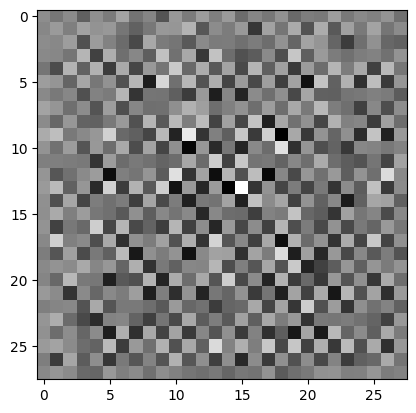

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = torch.randn((1, 100), device=device)

G.eval()    # 생성자 G를 함수로 쓸 때는 eval로 설정해야 함.
fake_image_test = G(test_noise)

plt.imshow(fake_image_test.reshape(28, 28).cpu().detach().numpy(), cmap='gray')

In [ ]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
D.eval()    # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
decision = D(fake_image_test)  

print(decision)

tensor([[0.4956]], device='cuda:0', grad_fn=<SigmoidBackward0>)


## GAN 목적함수
GAN의 목적함수는 다음과 같다.

$$
\begin{align}
    \min_{G}\max_{D} V(G, D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$

### Discriminator Loss
판별자 D 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최대화 문제를 풀고자 한다.
$$
\begin{align}
    \max_{D} V(D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(\mathbf{x}_{\textrm{fake}}))]
\end{align}
$$

### Generator Loss
생성자 G 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최소화 문제를 풀고자 한다.
$$
\begin{align}
    \min_{G} V(G) = \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$

In [ ]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# GAN 트레이닝에 쓰일 optimizer 정의
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

![GAN](https://cdn-images-1.medium.com/max/800/1*XKanAdkjQbg1eDDMF2-4ow.png)

[이미지 출처: Branko Blagojevic's Medium Post](https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229)

## Training

마이크 타이슨의 명언: **누구나 그럴싸한 계획을 가지고 있다... 얻어맞기 전까지는...**
![대체 텍스트](https://cdn-images-1.medium.com/max/800/1*ocjDDF4WbSZl-WAFVUlqrg.jpeg)

## TODO (2)

1. 고정된 noise 값을 몇 개 생성한다.
2. Training 과정 중 일정 시점마다 (ex. epoch % 10 == 0) <br> network G가 (1)의 noise 값으로부터 만들어낸 가짜 데이터를 가시화 하여, 학습이 진행되며 어떻게 변화하는지 확인한다.


## TODO (3)

매 epoch마다 network G와 network D의 loss를 저장한 뒤 그래프로 가시화 한다. 각 network의 loss가 어떻게 변화하는지 논의한다.

<br><br>

(학습이 충분이 진행되지 않았다고 판단될 경우 epoch 횟수를 늘리거나 다른 의미있는 변화들을 추가해 본다.)

- torch.randn을 통해 임의의 노이즈를 생성
- 10 epoch 만들어진 고정된 노이즈를 바탕으로 10개의 이미지를 생성
- epoch는 80으로 설정
- 실제 테스트시 학습이 잘 안되는 문제 발견 -> learning rate 증가

In [ ]:
# 고정된 noise 생성
noise = torch.randn(10, 100, device=device)

In [ ]:
EPOCHS = 80

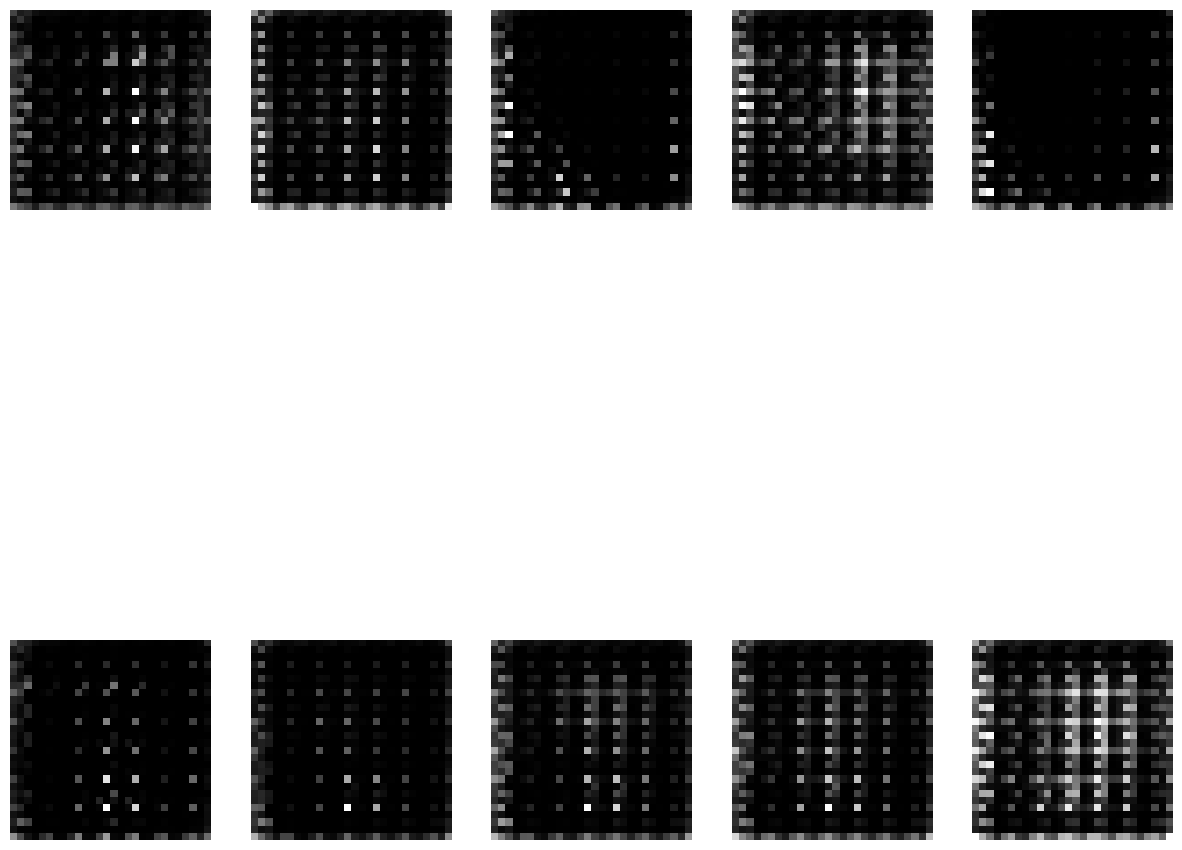

[1/80]	Loss_D: 0.0332	Loss_G: 5.0491	D(x): 0.9914	D(G(z)): 0.0217 / 0.0109
[2/80]	Loss_D: 0.1599	Loss_G: 7.5741	D(x): 0.9362	D(G(z)): 0.0056 / 0.0023
[3/80]	Loss_D: 0.0656	Loss_G: 6.7655	D(x): 0.9794	D(G(z)): 0.0057 / 0.0056
[4/80]	Loss_D: 0.2849	Loss_G: 5.3367	D(x): 0.8983	D(G(z)): 0.0700 / 0.0489
[5/80]	Loss_D: 0.3087	Loss_G: 4.3946	D(x): 0.9190	D(G(z)): 0.1019 / 0.0820
[6/80]	Loss_D: 0.5209	Loss_G: 3.1434	D(x): 0.8121	D(G(z)): 0.1315 / 0.1482
[7/80]	Loss_D: 0.4564	Loss_G: 2.4704	D(x): 0.8386	D(G(z)): 0.1720 / 0.1552
[8/80]	Loss_D: 0.6872	Loss_G: 1.9412	D(x): 0.8022	D(G(z)): 0.2748 / 0.2166
[9/80]	Loss_D: 1.0267	Loss_G: 1.5696	D(x): 0.7219	D(G(z)): 0.3479 / 0.3282
[10/80]	Loss_D: 0.6934	Loss_G: 1.9092	D(x): 0.7932	D(G(z)): 0.2640 / 0.2264


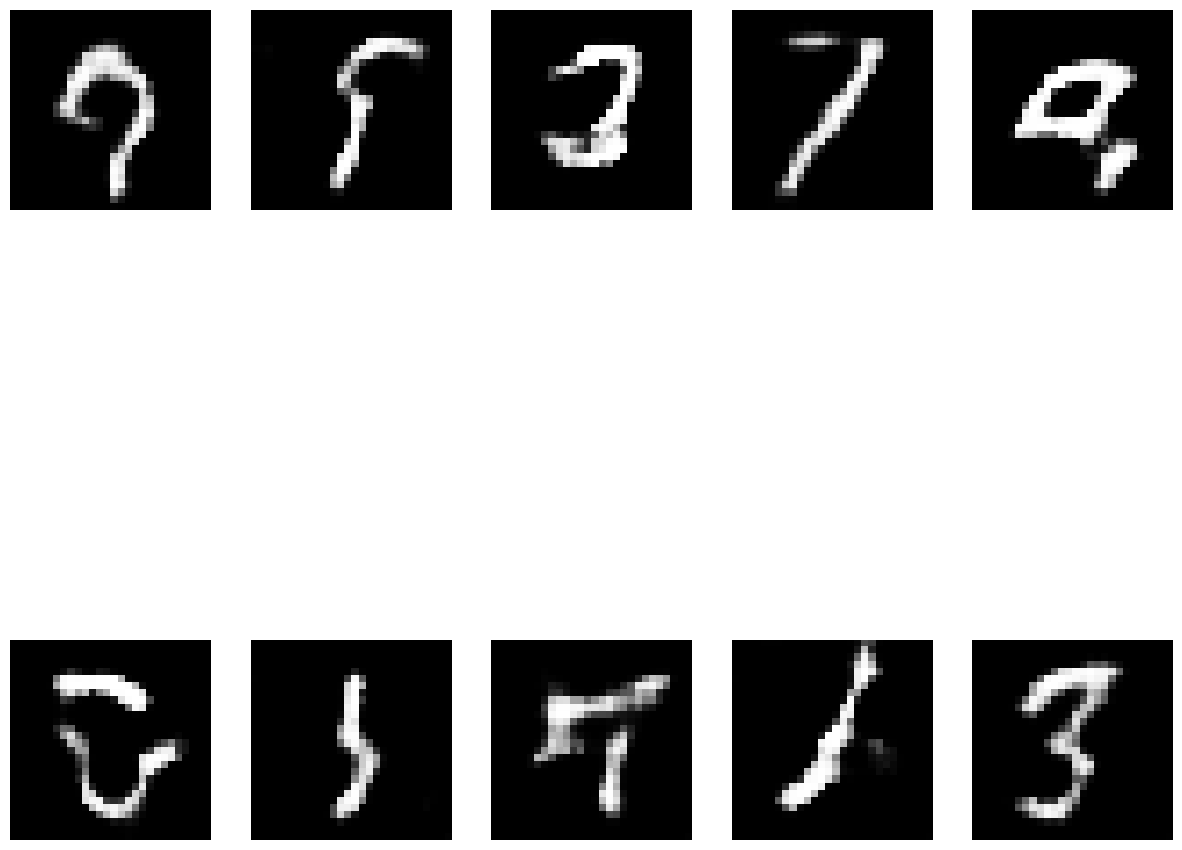

[11/80]	Loss_D: 0.8808	Loss_G: 1.4991	D(x): 0.6757	D(G(z)): 0.2745 / 0.3039
[12/80]	Loss_D: 0.8795	Loss_G: 1.7407	D(x): 0.6772	D(G(z)): 0.2522 / 0.2517
[13/80]	Loss_D: 0.9605	Loss_G: 1.9630	D(x): 0.6909	D(G(z)): 0.2701 / 0.2293
[14/80]	Loss_D: 1.0877	Loss_G: 1.4901	D(x): 0.7055	D(G(z)): 0.3496 / 0.3178
[15/80]	Loss_D: 0.8086	Loss_G: 2.1009	D(x): 0.7749	D(G(z)): 0.2893 / 0.2001
[16/80]	Loss_D: 1.1247	Loss_G: 1.5086	D(x): 0.6538	D(G(z)): 0.2927 / 0.3093
[17/80]	Loss_D: 1.1848	Loss_G: 1.2845	D(x): 0.5903	D(G(z)): 0.3370 / 0.3333
[18/80]	Loss_D: 0.7379	Loss_G: 1.6419	D(x): 0.7902	D(G(z)): 0.3100 / 0.2735
[19/80]	Loss_D: 0.8728	Loss_G: 1.9343	D(x): 0.7050	D(G(z)): 0.2470 / 0.2333
[20/80]	Loss_D: 1.5606	Loss_G: 1.2170	D(x): 0.5407	D(G(z)): 0.3910 / 0.3924


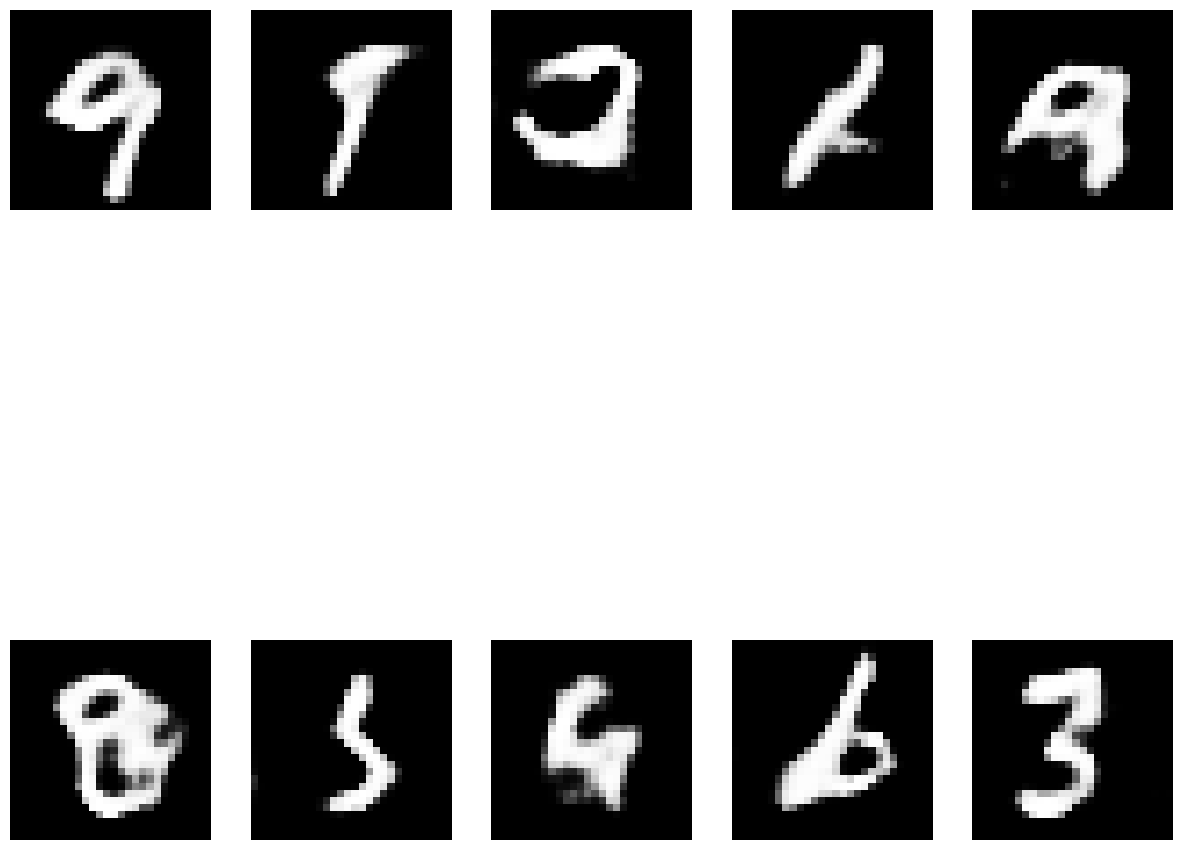

[21/80]	Loss_D: 0.9753	Loss_G: 1.7024	D(x): 0.6654	D(G(z)): 0.2787 / 0.2737
[22/80]	Loss_D: 0.7824	Loss_G: 1.6798	D(x): 0.7663	D(G(z)): 0.2961 / 0.2637
[23/80]	Loss_D: 1.1168	Loss_G: 1.6056	D(x): 0.7078	D(G(z)): 0.3774 / 0.3191
[24/80]	Loss_D: 1.3880	Loss_G: 1.4447	D(x): 0.5660	D(G(z)): 0.3395 / 0.3269
[25/80]	Loss_D: 0.9486	Loss_G: 1.3946	D(x): 0.7149	D(G(z)): 0.3580 / 0.3135
[26/80]	Loss_D: 0.9907	Loss_G: 1.3462	D(x): 0.6934	D(G(z)): 0.3629 / 0.3498
[27/80]	Loss_D: 0.9249	Loss_G: 1.6459	D(x): 0.7005	D(G(z)): 0.2840 / 0.2591
[28/80]	Loss_D: 1.1590	Loss_G: 1.1597	D(x): 0.5909	D(G(z)): 0.3532 / 0.3817
[29/80]	Loss_D: 1.6111	Loss_G: 1.6232	D(x): 0.5101	D(G(z)): 0.3622 / 0.3116
[30/80]	Loss_D: 1.2038	Loss_G: 1.4548	D(x): 0.5228	D(G(z)): 0.2729 / 0.2934


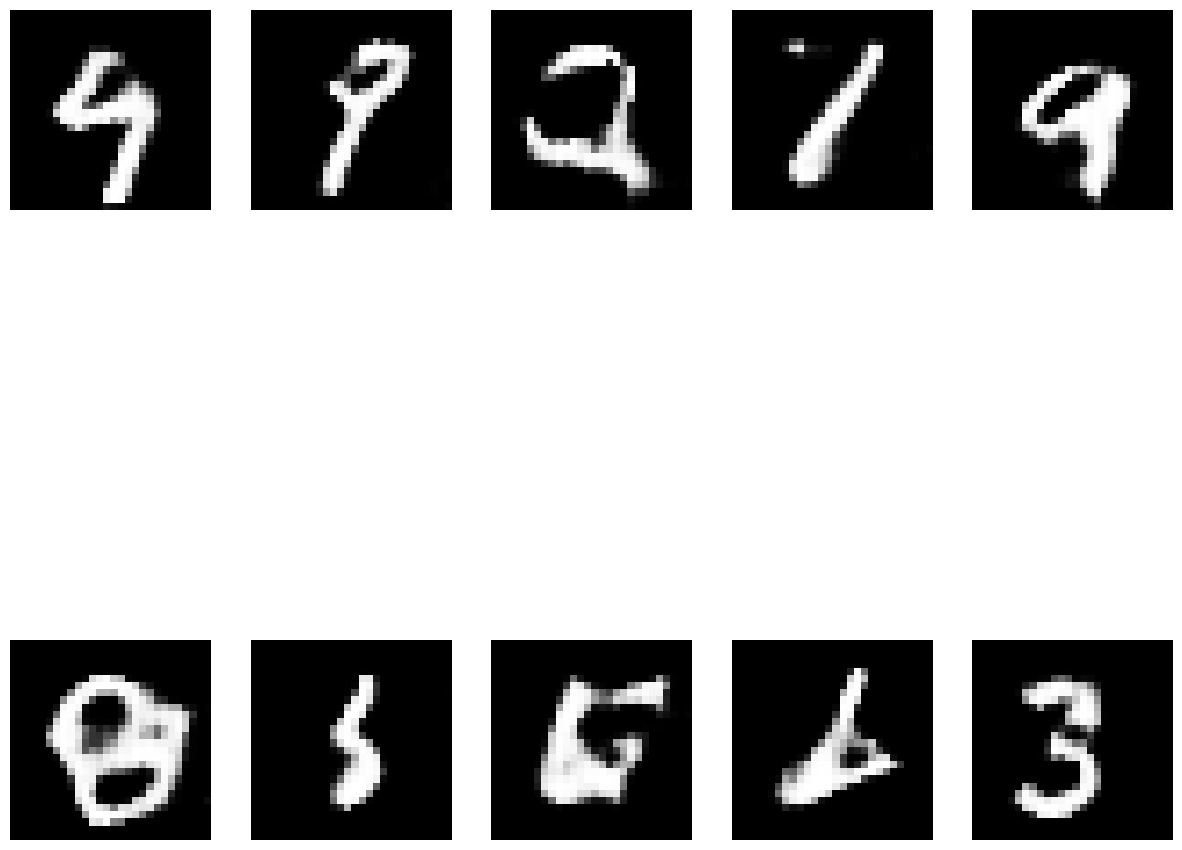

[31/80]	Loss_D: 1.4706	Loss_G: 1.2895	D(x): 0.4934	D(G(z)): 0.2940 / 0.3985
[32/80]	Loss_D: 1.0461	Loss_G: 1.6072	D(x): 0.6119	D(G(z)): 0.2977 / 0.2929
[33/80]	Loss_D: 1.0202	Loss_G: 1.5076	D(x): 0.6682	D(G(z)): 0.3342 / 0.2978
[34/80]	Loss_D: 1.0364	Loss_G: 1.2859	D(x): 0.7516	D(G(z)): 0.4013 / 0.3839
[35/80]	Loss_D: 1.0530	Loss_G: 1.1986	D(x): 0.7288	D(G(z)): 0.3902 / 0.3923
[36/80]	Loss_D: 1.0314	Loss_G: 1.3775	D(x): 0.6552	D(G(z)): 0.3459 / 0.3153
[37/80]	Loss_D: 1.2843	Loss_G: 1.2650	D(x): 0.6138	D(G(z)): 0.3926 / 0.3759
[38/80]	Loss_D: 1.0072	Loss_G: 1.5612	D(x): 0.6369	D(G(z)): 0.2705 / 0.2903
[39/80]	Loss_D: 0.8822	Loss_G: 1.7646	D(x): 0.7345	D(G(z)): 0.3240 / 0.2588
[40/80]	Loss_D: 1.1774	Loss_G: 1.1436	D(x): 0.6390	D(G(z)): 0.3982 / 0.3848


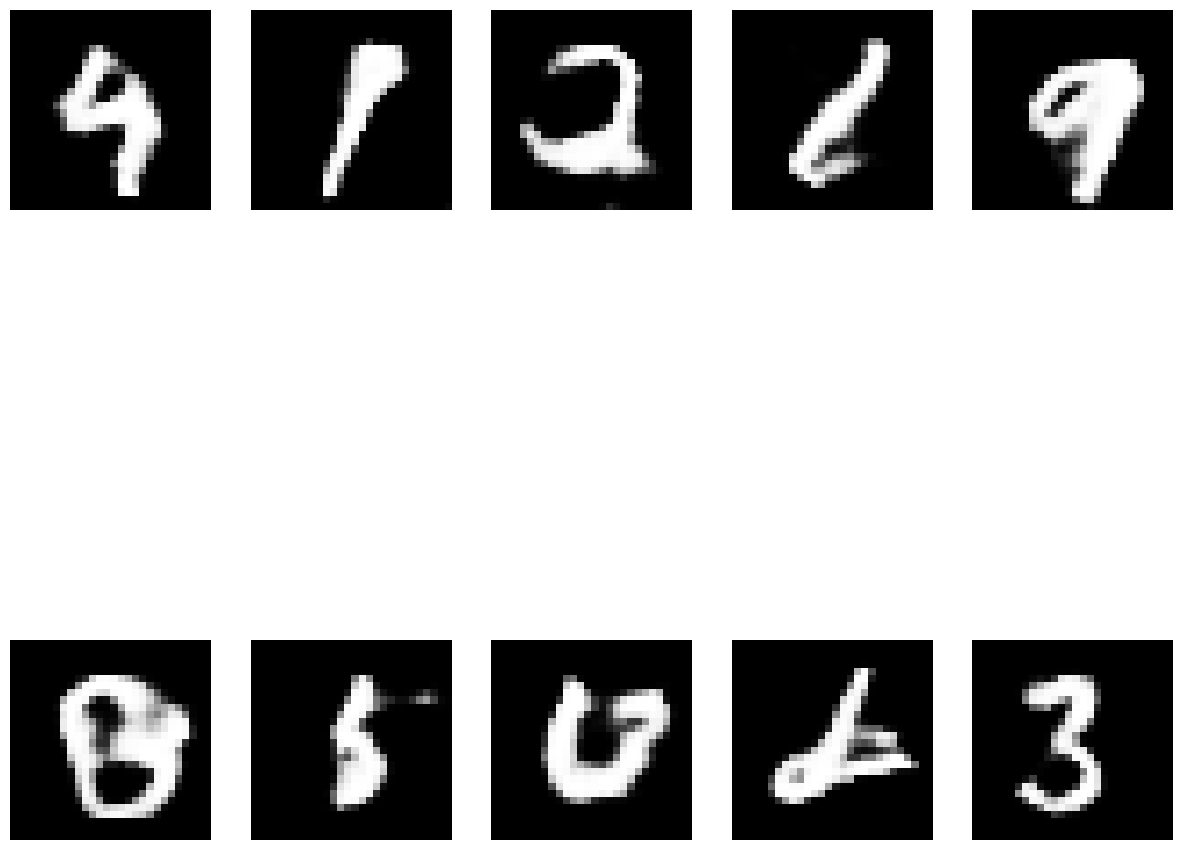

[41/80]	Loss_D: 1.0113	Loss_G: 1.1630	D(x): 0.6585	D(G(z)): 0.3552 / 0.3686
[42/80]	Loss_D: 0.8502	Loss_G: 1.6540	D(x): 0.6930	D(G(z)): 0.2818 / 0.2956
[43/80]	Loss_D: 1.1783	Loss_G: 1.4423	D(x): 0.5892	D(G(z)): 0.3452 / 0.3061
[44/80]	Loss_D: 1.1298	Loss_G: 1.3933	D(x): 0.5816	D(G(z)): 0.3241 / 0.3163
[45/80]	Loss_D: 1.4182	Loss_G: 1.3108	D(x): 0.5269	D(G(z)): 0.3552 / 0.3496
[46/80]	Loss_D: 0.9194	Loss_G: 1.1718	D(x): 0.7530	D(G(z)): 0.3973 / 0.3761
[47/80]	Loss_D: 1.1028	Loss_G: 1.4173	D(x): 0.7043	D(G(z)): 0.4166 / 0.3355
[48/80]	Loss_D: 0.9802	Loss_G: 1.4430	D(x): 0.7046	D(G(z)): 0.3600 / 0.3085
[49/80]	Loss_D: 1.1709	Loss_G: 1.4201	D(x): 0.6807	D(G(z)): 0.4269 / 0.3380
[50/80]	Loss_D: 1.2588	Loss_G: 1.2094	D(x): 0.5586	D(G(z)): 0.3348 / 0.3734


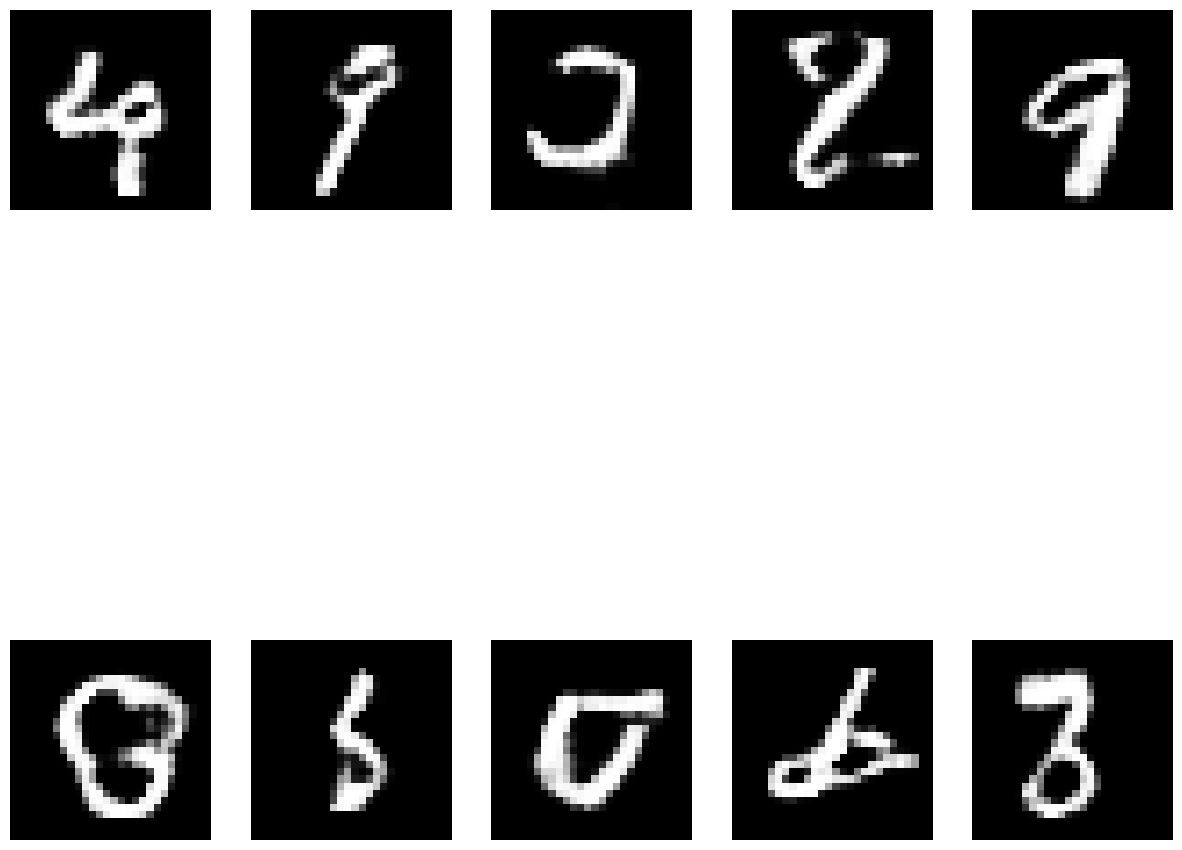

[51/80]	Loss_D: 1.0273	Loss_G: 1.2843	D(x): 0.6389	D(G(z)): 0.3291 / 0.3249
[52/80]	Loss_D: 0.9839	Loss_G: 1.5078	D(x): 0.6805	D(G(z)): 0.3211 / 0.3344
[53/80]	Loss_D: 1.0808	Loss_G: 1.4745	D(x): 0.6182	D(G(z)): 0.3258 / 0.3223
[54/80]	Loss_D: 0.8609	Loss_G: 1.4703	D(x): 0.6952	D(G(z)): 0.3269 / 0.2800
[55/80]	Loss_D: 0.9174	Loss_G: 1.3500	D(x): 0.7107	D(G(z)): 0.3524 / 0.3325
[56/80]	Loss_D: 0.9321	Loss_G: 1.2760	D(x): 0.6629	D(G(z)): 0.3184 / 0.3431
[57/80]	Loss_D: 0.9363	Loss_G: 1.3631	D(x): 0.6852	D(G(z)): 0.3304 / 0.3307
[58/80]	Loss_D: 1.1568	Loss_G: 1.1824	D(x): 0.5883	D(G(z)): 0.3495 / 0.3853
[59/80]	Loss_D: 1.1513	Loss_G: 1.3990	D(x): 0.6297	D(G(z)): 0.3554 / 0.3263
[60/80]	Loss_D: 1.0525	Loss_G: 1.3152	D(x): 0.6557	D(G(z)): 0.3793 / 0.3282


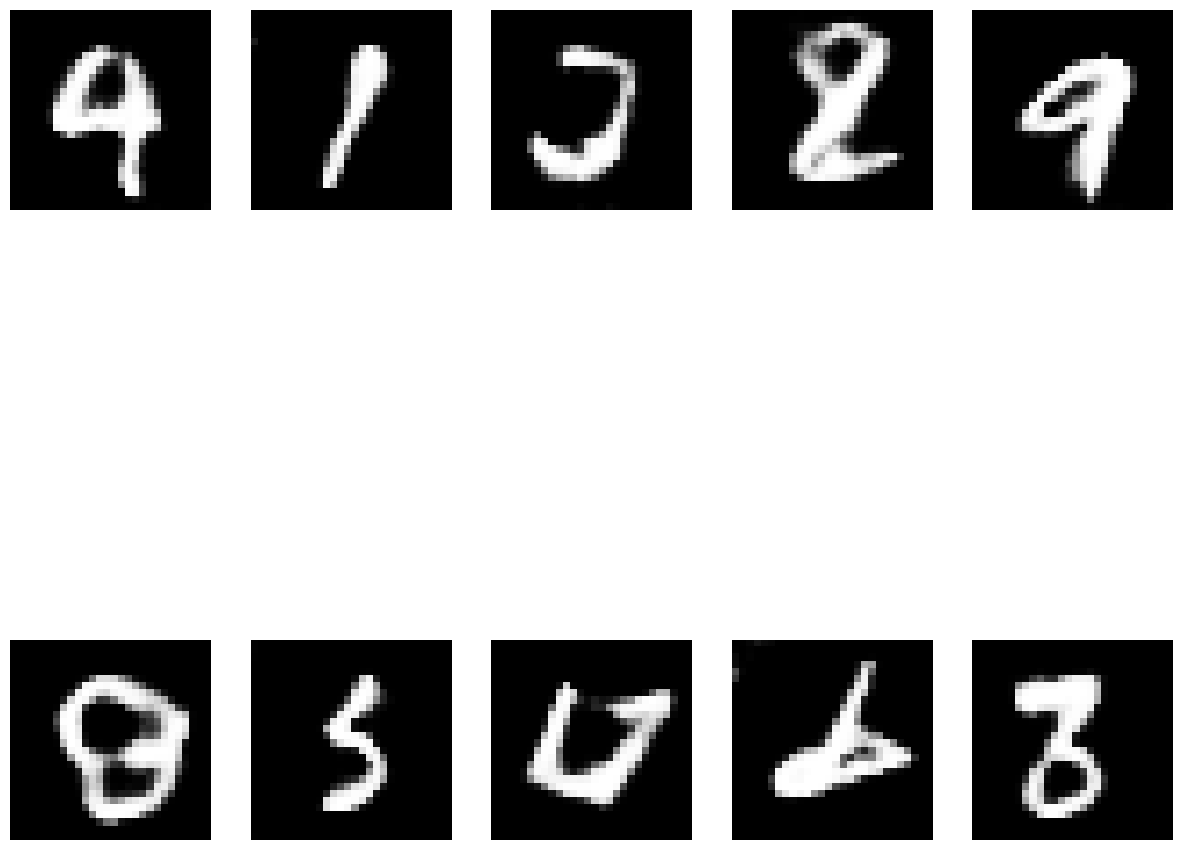

[61/80]	Loss_D: 1.1522	Loss_G: 1.1630	D(x): 0.6638	D(G(z)): 0.4022 / 0.3732
[62/80]	Loss_D: 0.8869	Loss_G: 1.3868	D(x): 0.7237	D(G(z)): 0.3019 / 0.3163
[63/80]	Loss_D: 0.9676	Loss_G: 1.2717	D(x): 0.6351	D(G(z)): 0.3172 / 0.3371
[64/80]	Loss_D: 0.9291	Loss_G: 1.2731	D(x): 0.7117	D(G(z)): 0.3490 / 0.3453
[65/80]	Loss_D: 0.9902	Loss_G: 1.4387	D(x): 0.6672	D(G(z)): 0.3318 / 0.3144
[66/80]	Loss_D: 1.1542	Loss_G: 1.1876	D(x): 0.6416	D(G(z)): 0.4060 / 0.3810
[67/80]	Loss_D: 1.1449	Loss_G: 1.3439	D(x): 0.5860	D(G(z)): 0.3377 / 0.3424
[68/80]	Loss_D: 1.3214	Loss_G: 1.0309	D(x): 0.6043	D(G(z)): 0.4481 / 0.4234
[69/80]	Loss_D: 1.0757	Loss_G: 1.2007	D(x): 0.6871	D(G(z)): 0.4080 / 0.3810
[70/80]	Loss_D: 1.1217	Loss_G: 1.2583	D(x): 0.6419	D(G(z)): 0.4105 / 0.3441


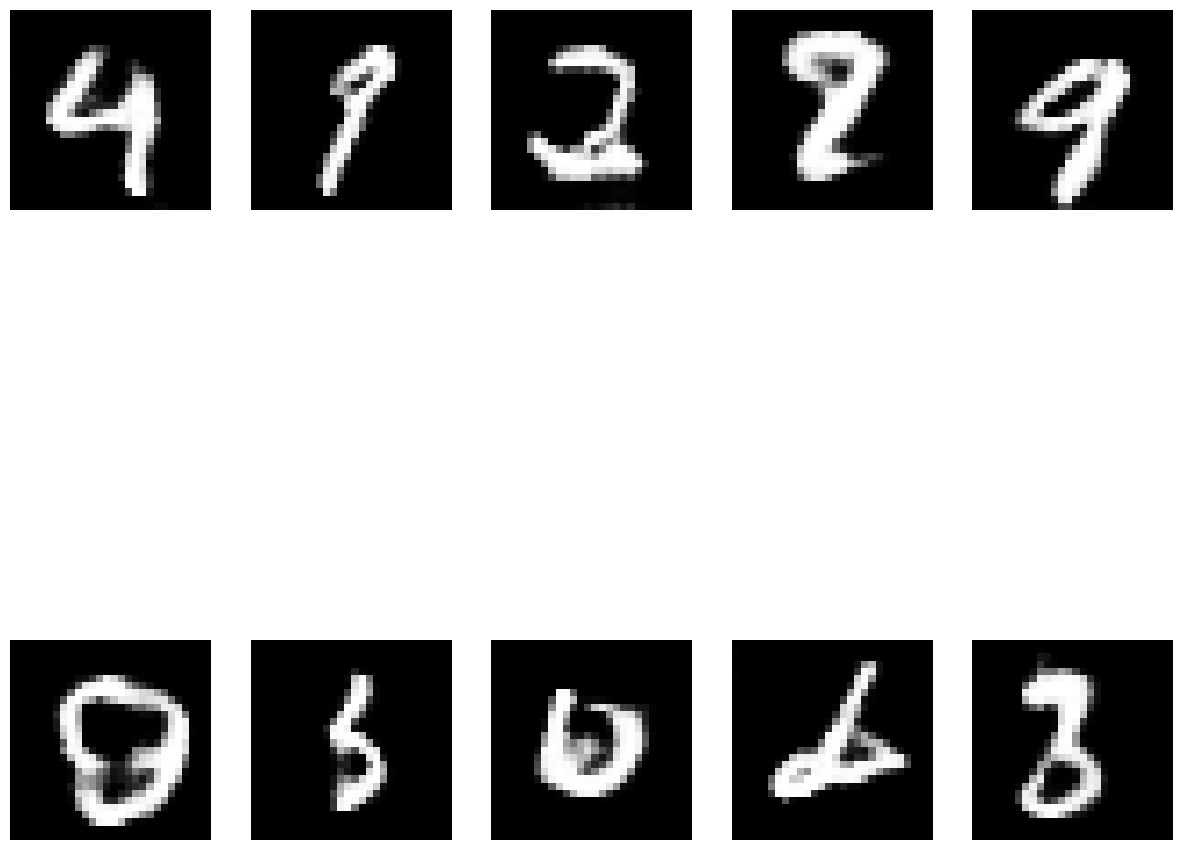

[71/80]	Loss_D: 1.1028	Loss_G: 1.4269	D(x): 0.6203	D(G(z)): 0.3448 / 0.3070
[72/80]	Loss_D: 1.1380	Loss_G: 1.0148	D(x): 0.6539	D(G(z)): 0.4037 / 0.4267
[73/80]	Loss_D: 0.9712	Loss_G: 1.3214	D(x): 0.6335	D(G(z)): 0.3298 / 0.3225
[74/80]	Loss_D: 1.1170	Loss_G: 1.3650	D(x): 0.6050	D(G(z)): 0.3322 / 0.3339
[75/80]	Loss_D: 1.1021	Loss_G: 1.1865	D(x): 0.6007	D(G(z)): 0.3537 / 0.3626
[76/80]	Loss_D: 1.2023	Loss_G: 1.0702	D(x): 0.5615	D(G(z)): 0.3585 / 0.3903
[77/80]	Loss_D: 1.2165	Loss_G: 1.1027	D(x): 0.5994	D(G(z)): 0.4178 / 0.3904
[78/80]	Loss_D: 0.9977	Loss_G: 1.7434	D(x): 0.6718	D(G(z)): 0.3129 / 0.2834
[79/80]	Loss_D: 1.1066	Loss_G: 1.0388	D(x): 0.5965	D(G(z)): 0.3625 / 0.4109
[80/80]	Loss_D: 1.1795	Loss_G: 1.1240	D(x): 0.6494	D(G(z)): 0.4257 / 0.4044
Training Finished!


In [ ]:
G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
  D_losses = []
  G_losses = []

  for i, (images, _) in enumerate(train_loader):
    #############################
    # 1) Update discriminator D #
    #############################
    D.zero_grad()

    images_real = images.to(device)
    y_pred_real = D(images_real).view(-1)    # 진짜 MNIST 데이터를 본 Discriminator의 판별값
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)    # 진짜 MNIST 데이터에 대한 label 값은 1
    
    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    D_real_loss = criterion(y_pred_real, label)
    D_real_loss.backward()

    D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)   # Generator에 입력으로 줄 noise 생성
    images_fake = G(noises)           # Generator는 noise로부터 가짜 데이터를 생성

    y_pred_fake = D(images_fake.detach()).view(-1)      # Generator가 만든 가짜 데이터를 본 Discriminator의 판별값
    label.fill_(0.)        # 가짜 데이터에 대한 label 값은 0

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    D_fake_loss = criterion(y_pred_fake, label)
    D_fake_loss.backward()

    D_G_z1 = y_pred_fake.mean().item()

    D_loss = D_real_loss + D_fake_loss

    # Update D
    D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    G.zero_grad()

    y_pred_fake = D(images_fake).view(-1)
    label.fill_(1.)       # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    G_loss = criterion(y_pred_fake, label)
    G_loss.backward()

    D_G_z2 = y_pred_fake.mean().item()

    # Update G
    G_optimizer.step()
    '''
    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
    '''
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
    
  if epoch % 10 == 0:
      generated_image = G(noise).cpu().detach().numpy().squeeze()

      fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

      for ax in axes.flat:
          ax.axis('off')

      axes[0, 0].imshow(generated_image[0], cmap='gray')
      axes[0, 1].imshow(generated_image[1], cmap='gray')
      axes[0, 2].imshow(generated_image[2], cmap='gray')
      axes[0, 3].imshow(generated_image[3], cmap='gray')
      axes[0, 4].imshow(generated_image[4], cmap='gray')
      axes[1, 0].imshow(generated_image[5], cmap='gray')
      axes[1, 1].imshow(generated_image[6], cmap='gray')
      axes[1, 2].imshow(generated_image[7], cmap='gray')
      axes[1, 3].imshow(generated_image[8], cmap='gray')
      axes[1, 4].imshow(generated_image[9], cmap='gray')

      plt.show()
  
  print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
         % (epoch+1, EPOCHS, D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
  
  train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
  train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))

print('Training Finished!')

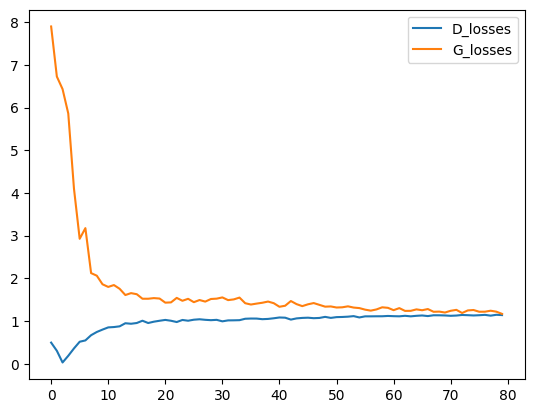

In [ ]:
x = [i for i in range(len(train_hist['D_losses']))]

plt.plot(x, train_hist['D_losses'], label='D_losses')
plt.plot(x, train_hist['G_losses'], label='G_losses')
plt.legend()
plt.show()

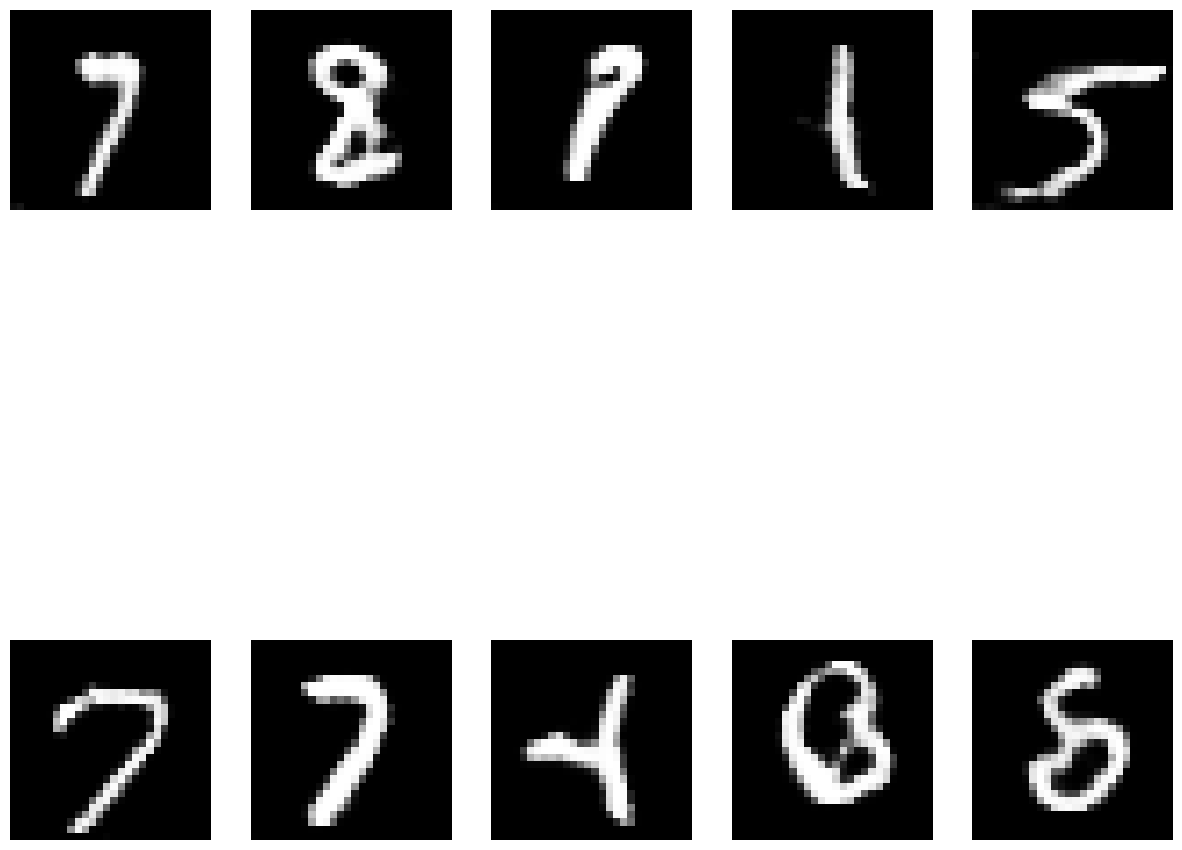

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

G.eval()
noises = torch.randn(10, 100, device=device)
generated_image = G(noises).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0, 0].imshow(generated_image[0], cmap='gray')
axes[0, 1].imshow(generated_image[1], cmap='gray')
axes[0, 2].imshow(generated_image[2], cmap='gray')
axes[0, 3].imshow(generated_image[3], cmap='gray')
axes[0, 4].imshow(generated_image[4], cmap='gray')
axes[1, 0].imshow(generated_image[5], cmap='gray')
axes[1, 1].imshow(generated_image[6], cmap='gray')
axes[1, 2].imshow(generated_image[7], cmap='gray')
axes[1, 3].imshow(generated_image[8], cmap='gray')
axes[1, 4].imshow(generated_image[9], cmap='gray')

plt.show()

## 결과 분석
- 처음에는 엉뚱한 이미지를 생성하는 반면 epoch이 증가할수록 구분 가능한 이미지를 생성
- 모든 좋은 이미지를 만드는게 아니라 구분이 불가능한 이미지도 존재
- loss의 경우 Generator와 Discriminator가 서로 수렴해가는것을 보임
- condition을 준다면 좀 더 명확한 이미지가 생성되지 않을까라는 생각을 함

## 추가 실험
- Condition 없이 GAN을 학습시켰을때 결과 이미지에 모호함 존재
- Condition이 있다면 어떠한 결과가 나올지 궁금하여 추가적인 실험 진행
- 기존 GAN은 불분명한 이미지를 만들었지만 condition이 주어진다면 좀 더 명확한 이미지를 만들것이라 생각
- Conditional GAN은 fc layer로만 구성

In [ ]:
G = CondGenerator().to(device)
D = CondDiscriminator().to(device)

In [ ]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# GAN 트레이닝에 쓰일 optimizer 정의
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

EPOCHS = 150

In [ ]:
noise2 = torch.randn(10, 100).to(device)

c = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                         ]).to(device)

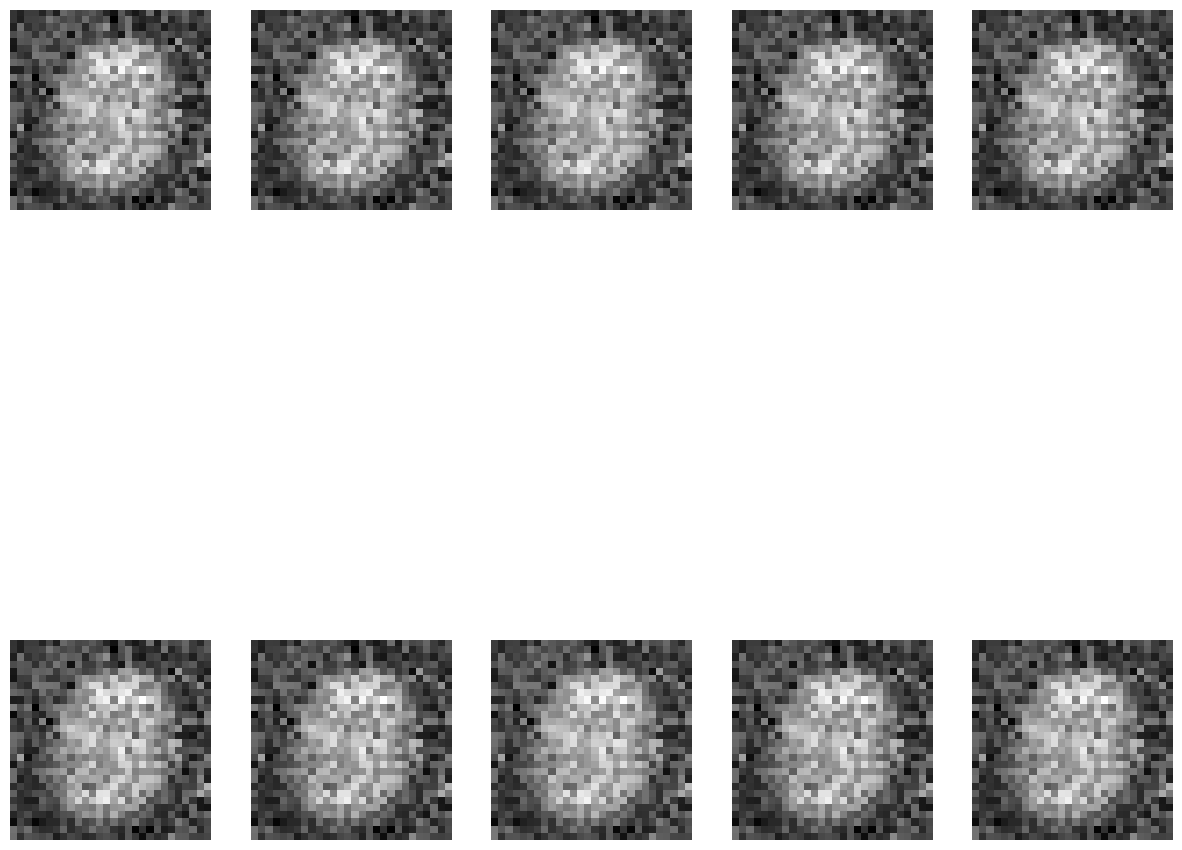

[1/150]	Loss_D: 0.1410	Loss_G: 5.0514	D(x): 0.9984	D(G(z)): 0.1168 / 0.0218
[2/150]	Loss_D: 0.4863	Loss_G: 3.9249	D(x): 0.9015	D(G(z)): 0.2290 / 0.0485
[3/150]	Loss_D: 0.1829	Loss_G: 2.3015	D(x): 0.9335	D(G(z)): 0.0293 / 0.2050
[4/150]	Loss_D: 0.1657	Loss_G: 3.9249	D(x): 0.9774	D(G(z)): 0.0904 / 0.0318
[5/150]	Loss_D: 0.2763	Loss_G: 6.6181	D(x): 0.9399	D(G(z)): 0.0638 / 0.0155
[6/150]	Loss_D: 0.1579	Loss_G: 3.7979	D(x): 0.9672	D(G(z)): 0.0771 / 0.0444
[7/150]	Loss_D: 0.3839	Loss_G: 4.7963	D(x): 0.9122	D(G(z)): 0.0853 / 0.0292
[8/150]	Loss_D: 0.4183	Loss_G: 2.8080	D(x): 0.8354	D(G(z)): 0.0839 / 0.1309
[9/150]	Loss_D: 0.2888	Loss_G: 3.5383	D(x): 0.9063	D(G(z)): 0.0985 / 0.0626
[10/150]	Loss_D: 0.2669	Loss_G: 4.3825	D(x): 0.9168	D(G(z)): 0.1052 / 0.0523


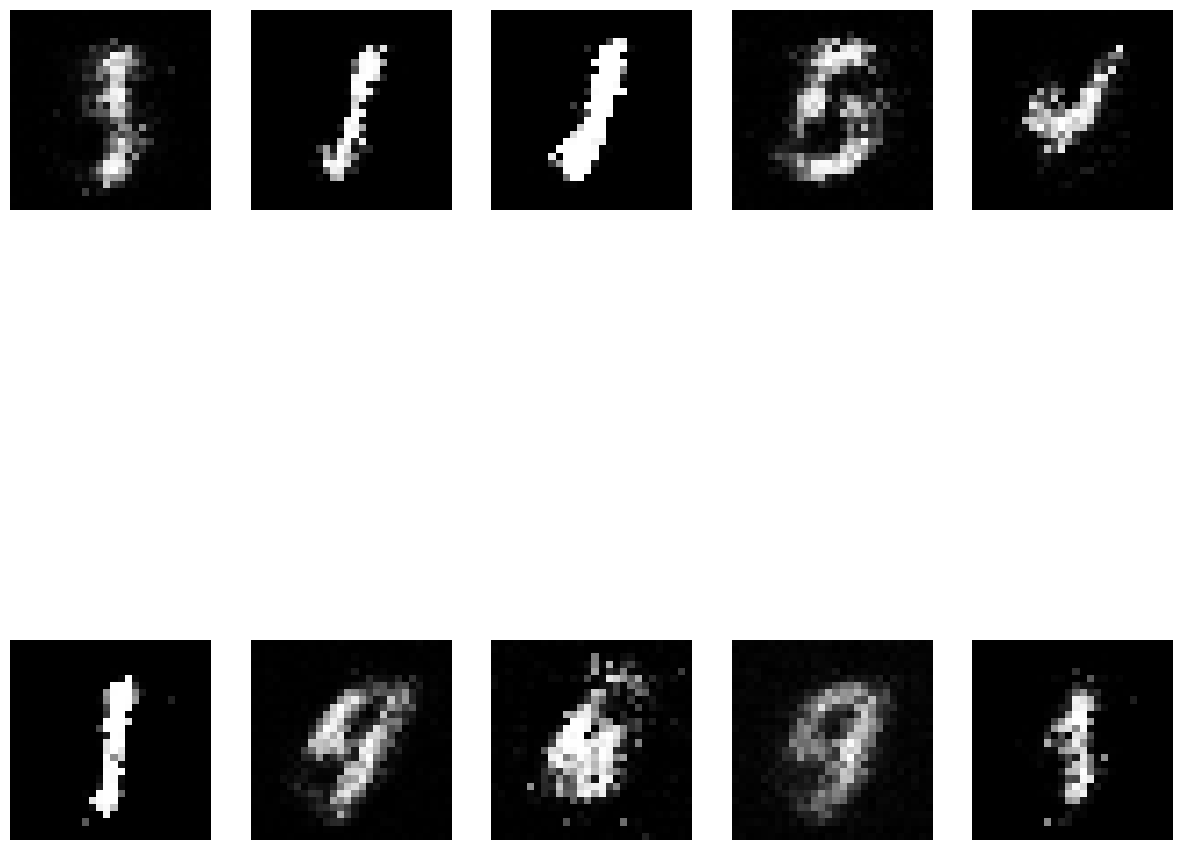

[11/150]	Loss_D: 0.4576	Loss_G: 2.6446	D(x): 0.8710	D(G(z)): 0.1402 / 0.1326
[12/150]	Loss_D: 0.5116	Loss_G: 3.4631	D(x): 0.8416	D(G(z)): 0.1423 / 0.1232
[13/150]	Loss_D: 0.5447	Loss_G: 3.2838	D(x): 0.8093	D(G(z)): 0.1328 / 0.1459
[14/150]	Loss_D: 0.5183	Loss_G: 3.1234	D(x): 0.8260	D(G(z)): 0.1162 / 0.1008
[15/150]	Loss_D: 0.7264	Loss_G: 2.1038	D(x): 0.8182	D(G(z)): 0.2600 / 0.2278
[16/150]	Loss_D: 0.6448	Loss_G: 2.4346	D(x): 0.8158	D(G(z)): 0.2344 / 0.1970
[17/150]	Loss_D: 0.6599	Loss_G: 2.3236	D(x): 0.7505	D(G(z)): 0.1458 / 0.2126
[18/150]	Loss_D: 0.5483	Loss_G: 2.4127	D(x): 0.7990	D(G(z)): 0.1610 / 0.1936
[19/150]	Loss_D: 0.6120	Loss_G: 3.1038	D(x): 0.8172	D(G(z)): 0.1747 / 0.1584
[20/150]	Loss_D: 0.9112	Loss_G: 1.8209	D(x): 0.7092	D(G(z)): 0.2883 / 0.2595


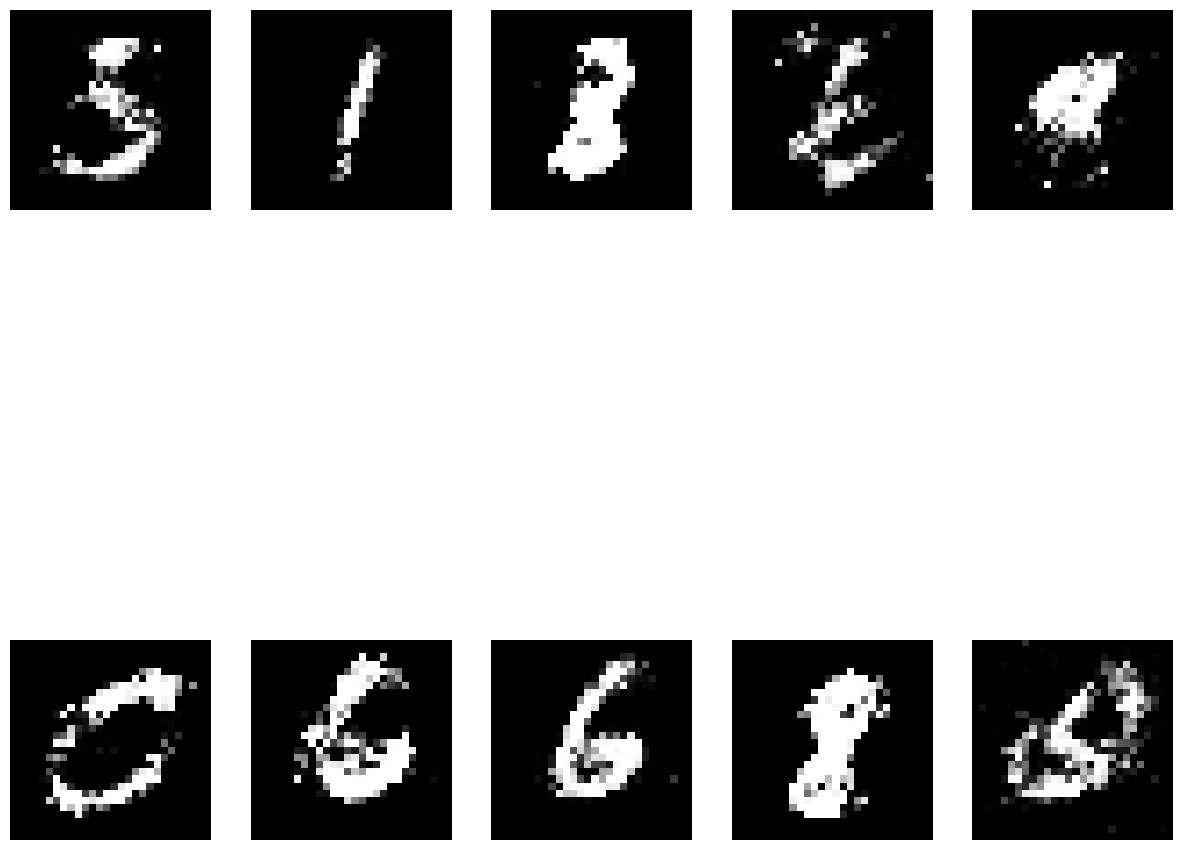

[21/150]	Loss_D: 0.8392	Loss_G: 1.9695	D(x): 0.7177	D(G(z)): 0.2292 / 0.2470
[22/150]	Loss_D: 0.8324	Loss_G: 2.5578	D(x): 0.7763	D(G(z)): 0.2765 / 0.1585
[23/150]	Loss_D: 0.7759	Loss_G: 1.5691	D(x): 0.7627	D(G(z)): 0.3115 / 0.2843
[24/150]	Loss_D: 1.0641	Loss_G: 1.2566	D(x): 0.6951	D(G(z)): 0.3780 / 0.3600
[25/150]	Loss_D: 0.8723	Loss_G: 1.5869	D(x): 0.7275	D(G(z)): 0.2984 / 0.2883
[26/150]	Loss_D: 0.9291	Loss_G: 1.9452	D(x): 0.7072	D(G(z)): 0.3106 / 0.2520
[27/150]	Loss_D: 0.9582	Loss_G: 1.3562	D(x): 0.6830	D(G(z)): 0.3443 / 0.3382
[28/150]	Loss_D: 1.0425	Loss_G: 1.3642	D(x): 0.6653	D(G(z)): 0.3645 / 0.3408
[29/150]	Loss_D: 1.0459	Loss_G: 1.6717	D(x): 0.5943	D(G(z)): 0.2757 / 0.2660
[30/150]	Loss_D: 1.0435	Loss_G: 1.5996	D(x): 0.6221	D(G(z)): 0.3064 / 0.2789


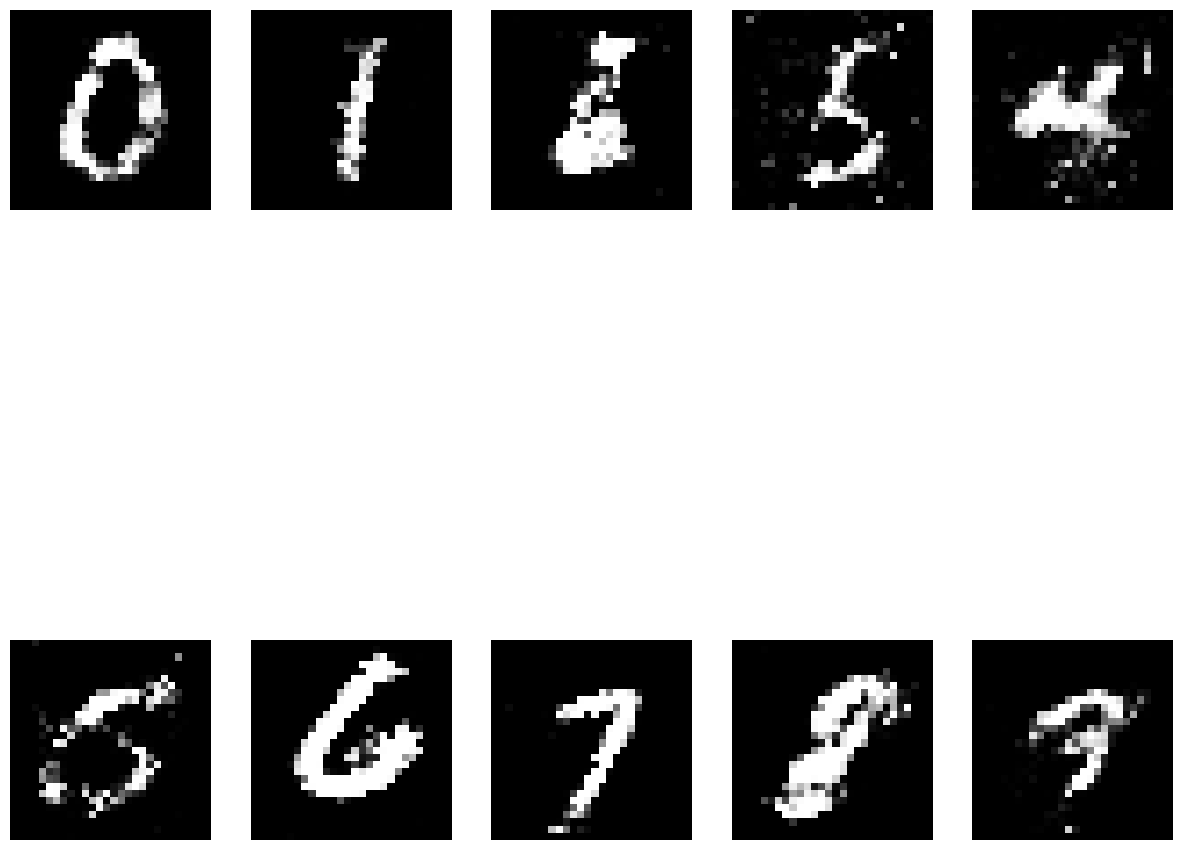

[31/150]	Loss_D: 0.9988	Loss_G: 1.1924	D(x): 0.6680	D(G(z)): 0.3848 / 0.3564
[32/150]	Loss_D: 1.1468	Loss_G: 1.4722	D(x): 0.5871	D(G(z)): 0.3298 / 0.3184
[33/150]	Loss_D: 0.9903	Loss_G: 1.3900	D(x): 0.6258	D(G(z)): 0.2966 / 0.3123
[34/150]	Loss_D: 1.3535	Loss_G: 1.1739	D(x): 0.5285	D(G(z)): 0.3884 / 0.3777
[35/150]	Loss_D: 1.0494	Loss_G: 1.3601	D(x): 0.6467	D(G(z)): 0.3663 / 0.3416
[36/150]	Loss_D: 1.1984	Loss_G: 1.1254	D(x): 0.6967	D(G(z)): 0.4642 / 0.3869
[37/150]	Loss_D: 1.0439	Loss_G: 1.1838	D(x): 0.6310	D(G(z)): 0.3575 / 0.3770
[38/150]	Loss_D: 1.2323	Loss_G: 0.9523	D(x): 0.5626	D(G(z)): 0.4030 / 0.4149
[39/150]	Loss_D: 1.2293	Loss_G: 0.8921	D(x): 0.6072	D(G(z)): 0.4577 / 0.4442
[40/150]	Loss_D: 1.2053	Loss_G: 0.9571	D(x): 0.6224	D(G(z)): 0.4438 / 0.4227


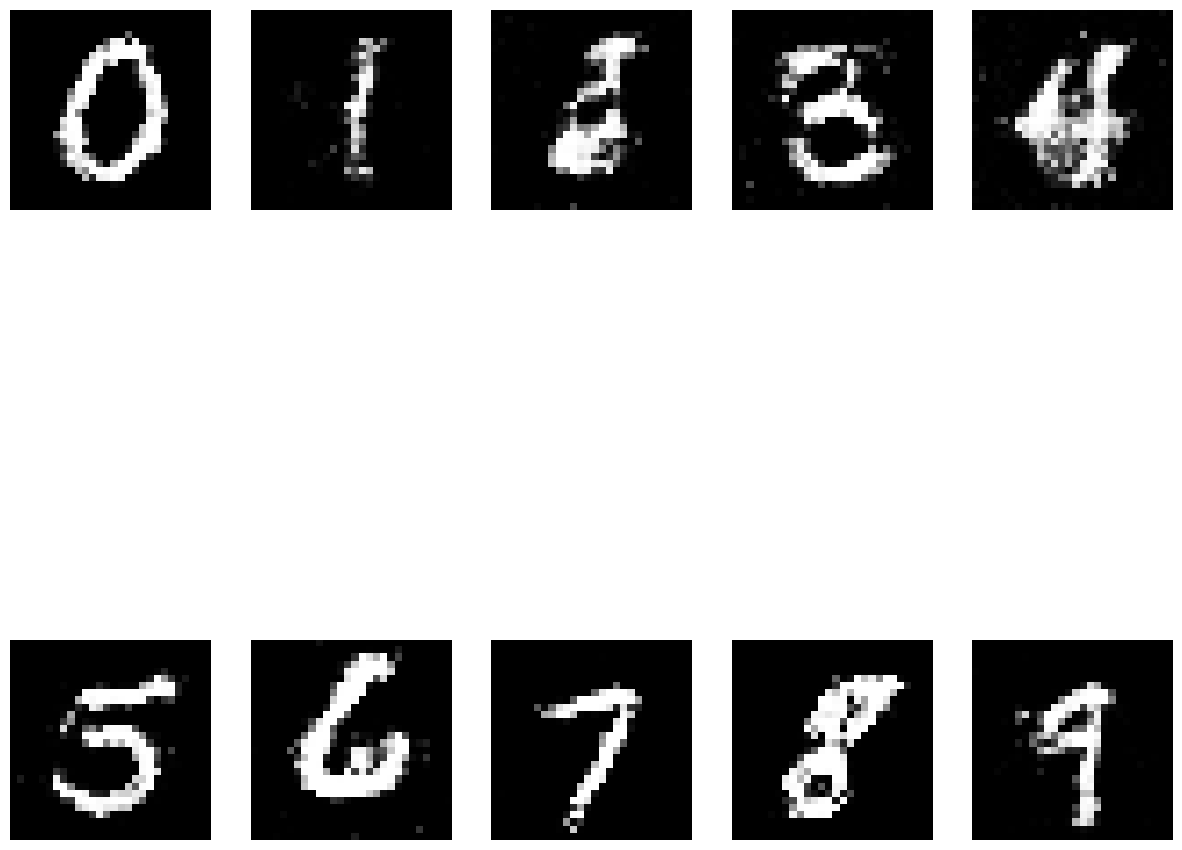

[41/150]	Loss_D: 1.2214	Loss_G: 0.7980	D(x): 0.6155	D(G(z)): 0.4597 / 0.4829
[42/150]	Loss_D: 1.3192	Loss_G: 1.1490	D(x): 0.5386	D(G(z)): 0.4278 / 0.3511
[43/150]	Loss_D: 1.1468	Loss_G: 1.0930	D(x): 0.5580	D(G(z)): 0.3467 / 0.3744
[44/150]	Loss_D: 1.1401	Loss_G: 1.0975	D(x): 0.5973	D(G(z)): 0.3978 / 0.3965
[45/150]	Loss_D: 1.2557	Loss_G: 1.0286	D(x): 0.5554	D(G(z)): 0.4245 / 0.3959
[46/150]	Loss_D: 1.2162	Loss_G: 1.0133	D(x): 0.5656	D(G(z)): 0.4334 / 0.3908
[47/150]	Loss_D: 1.1804	Loss_G: 0.9304	D(x): 0.6080	D(G(z)): 0.4414 / 0.4384
[48/150]	Loss_D: 1.2697	Loss_G: 0.9346	D(x): 0.5486	D(G(z)): 0.4460 / 0.4183
[49/150]	Loss_D: 1.2312	Loss_G: 0.8995	D(x): 0.6025	D(G(z)): 0.4617 / 0.4373
[50/150]	Loss_D: 1.3150	Loss_G: 0.8973	D(x): 0.5789	D(G(z)): 0.4750 / 0.4378


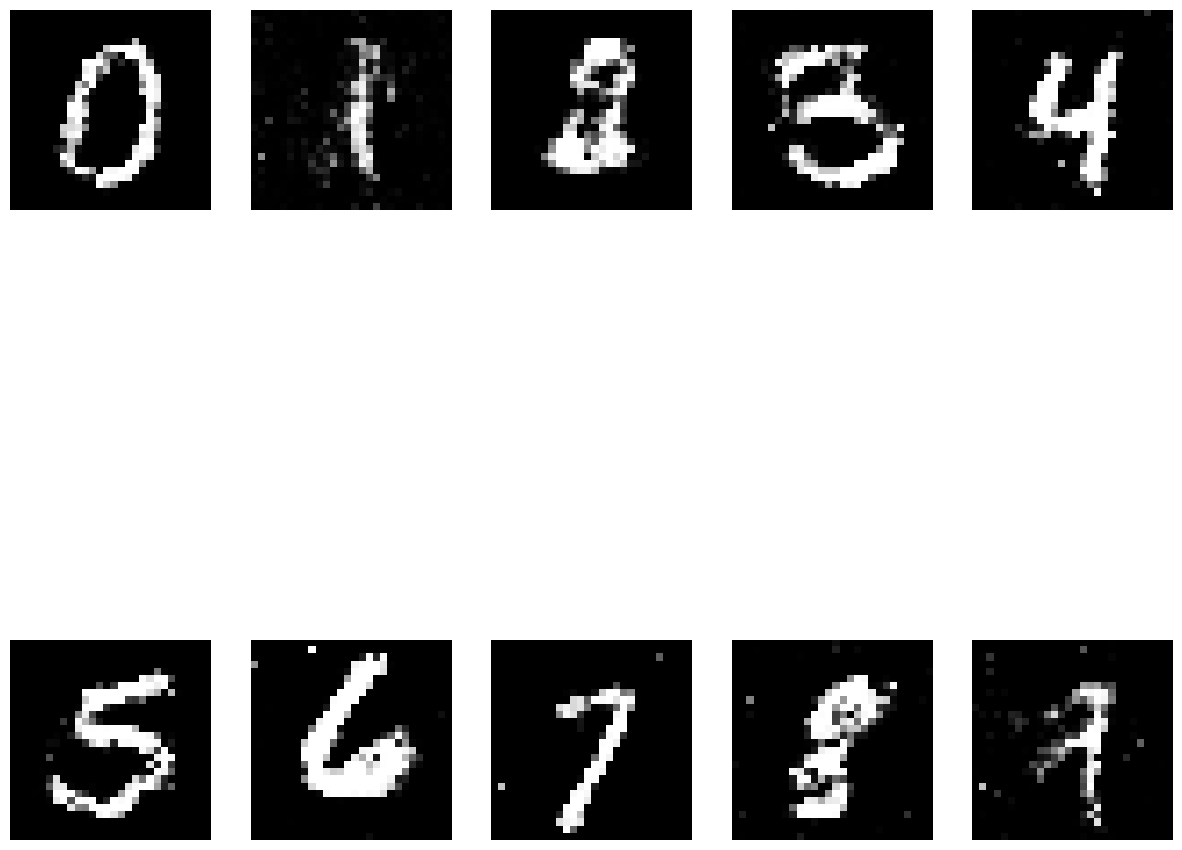

[51/150]	Loss_D: 1.2593	Loss_G: 0.9609	D(x): 0.5393	D(G(z)): 0.4278 / 0.4126
[52/150]	Loss_D: 1.2867	Loss_G: 0.8587	D(x): 0.5523	D(G(z)): 0.4440 / 0.4589
[53/150]	Loss_D: 1.3008	Loss_G: 0.8747	D(x): 0.5591	D(G(z)): 0.4509 / 0.4485
[54/150]	Loss_D: 1.1972	Loss_G: 0.8875	D(x): 0.5893	D(G(z)): 0.4422 / 0.4529
[55/150]	Loss_D: 1.2393	Loss_G: 0.9257	D(x): 0.5646	D(G(z)): 0.4323 / 0.4173
[56/150]	Loss_D: 1.2958	Loss_G: 0.8452	D(x): 0.5463	D(G(z)): 0.4596 / 0.4502
[57/150]	Loss_D: 1.3021	Loss_G: 0.8417	D(x): 0.5416	D(G(z)): 0.4605 / 0.4515
[58/150]	Loss_D: 1.2921	Loss_G: 0.8622	D(x): 0.5547	D(G(z)): 0.4419 / 0.4497
[59/150]	Loss_D: 1.2730	Loss_G: 0.8801	D(x): 0.5226	D(G(z)): 0.4103 / 0.4414
[60/150]	Loss_D: 1.2113	Loss_G: 0.8348	D(x): 0.5742	D(G(z)): 0.4386 / 0.4577


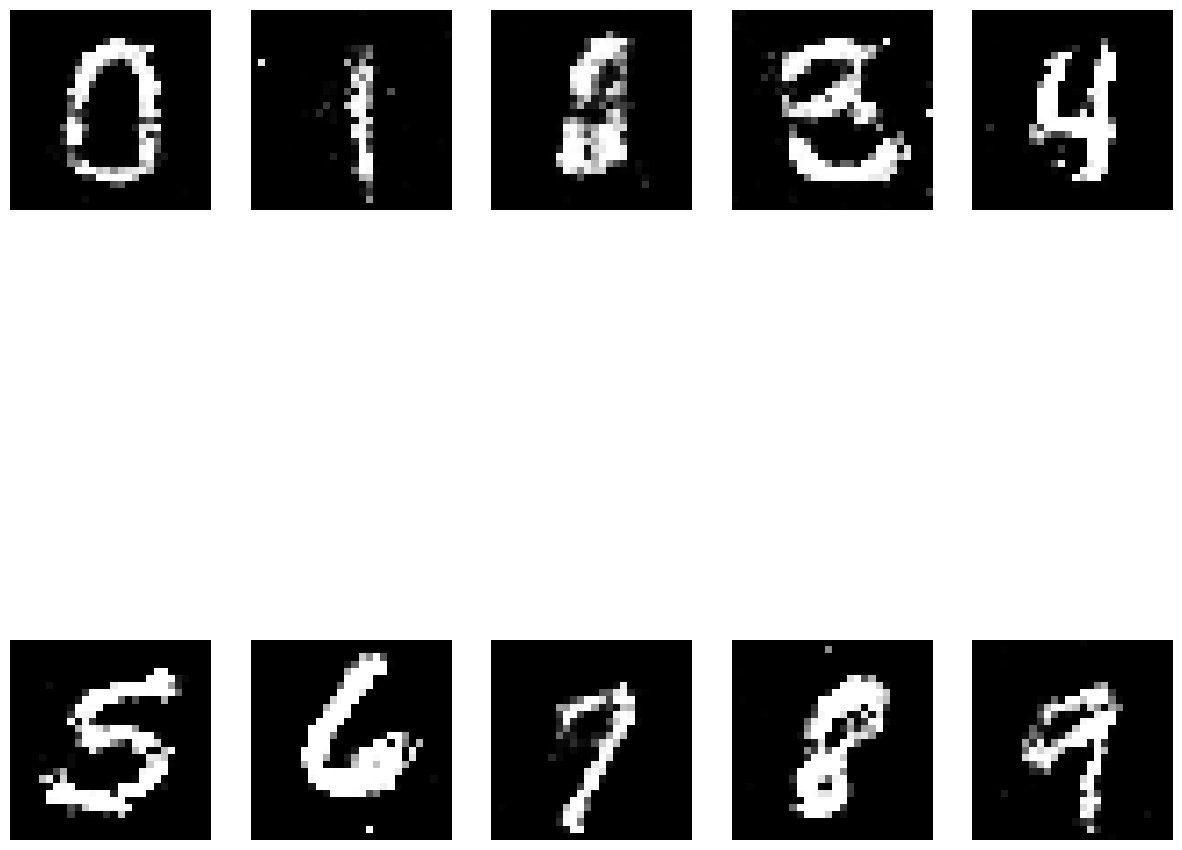

[61/150]	Loss_D: 1.3881	Loss_G: 0.9639	D(x): 0.4868	D(G(z)): 0.4185 / 0.4122
[62/150]	Loss_D: 1.3485	Loss_G: 1.0038	D(x): 0.5196	D(G(z)): 0.4279 / 0.4020
[63/150]	Loss_D: 1.2846	Loss_G: 0.8895	D(x): 0.5367	D(G(z)): 0.4548 / 0.4274
[64/150]	Loss_D: 1.3213	Loss_G: 0.8118	D(x): 0.5279	D(G(z)): 0.4676 / 0.4596
[65/150]	Loss_D: 1.2447	Loss_G: 0.8696	D(x): 0.5692	D(G(z)): 0.4488 / 0.4420
[66/150]	Loss_D: 1.3769	Loss_G: 0.8074	D(x): 0.5086	D(G(z)): 0.4673 / 0.4601
[67/150]	Loss_D: 1.2701	Loss_G: 0.8411	D(x): 0.5501	D(G(z)): 0.4495 / 0.4495
[68/150]	Loss_D: 1.2597	Loss_G: 0.8315	D(x): 0.5539	D(G(z)): 0.4531 / 0.4547
[69/150]	Loss_D: 1.3004	Loss_G: 0.9075	D(x): 0.5230	D(G(z)): 0.4336 / 0.4346
[70/150]	Loss_D: 1.2904	Loss_G: 0.7467	D(x): 0.5708	D(G(z)): 0.4878 / 0.4907


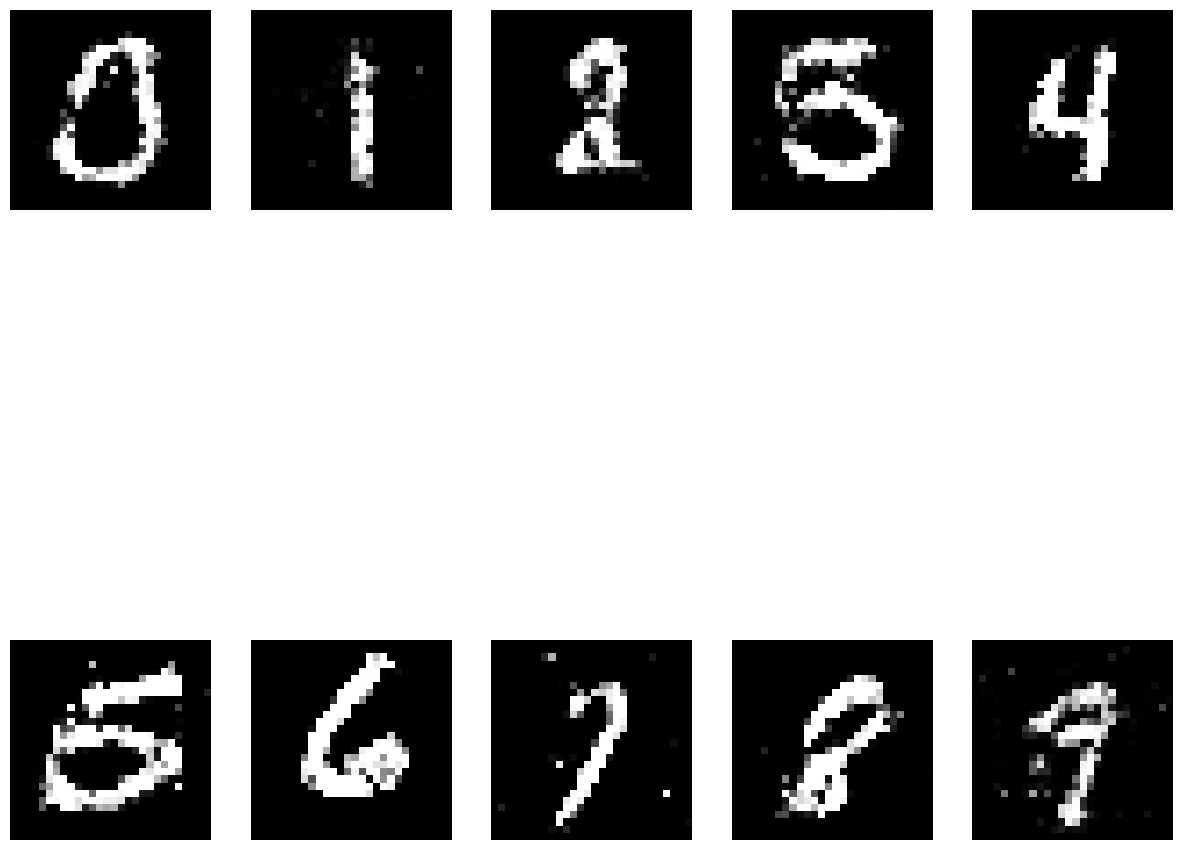

[71/150]	Loss_D: 1.2540	Loss_G: 0.9237	D(x): 0.5366	D(G(z)): 0.4171 / 0.4192
[72/150]	Loss_D: 1.2956	Loss_G: 0.7642	D(x): 0.5781	D(G(z)): 0.4912 / 0.4840
[73/150]	Loss_D: 1.2094	Loss_G: 0.8141	D(x): 0.5500	D(G(z)): 0.4258 / 0.4599
[74/150]	Loss_D: 1.2619	Loss_G: 0.8945	D(x): 0.5423	D(G(z)): 0.4426 / 0.4256
[75/150]	Loss_D: 1.3406	Loss_G: 0.9055	D(x): 0.5276	D(G(z)): 0.4481 / 0.4254
[76/150]	Loss_D: 1.3221	Loss_G: 0.7991	D(x): 0.5199	D(G(z)): 0.4571 / 0.4648
[77/150]	Loss_D: 1.2754	Loss_G: 0.7976	D(x): 0.5221	D(G(z)): 0.4316 / 0.4678
[78/150]	Loss_D: 1.2827	Loss_G: 0.9184	D(x): 0.5079	D(G(z)): 0.4177 / 0.4189
[79/150]	Loss_D: 1.2906	Loss_G: 0.7666	D(x): 0.5598	D(G(z)): 0.4663 / 0.4762
[80/150]	Loss_D: 1.2518	Loss_G: 0.8894	D(x): 0.5566	D(G(z)): 0.4416 / 0.4296


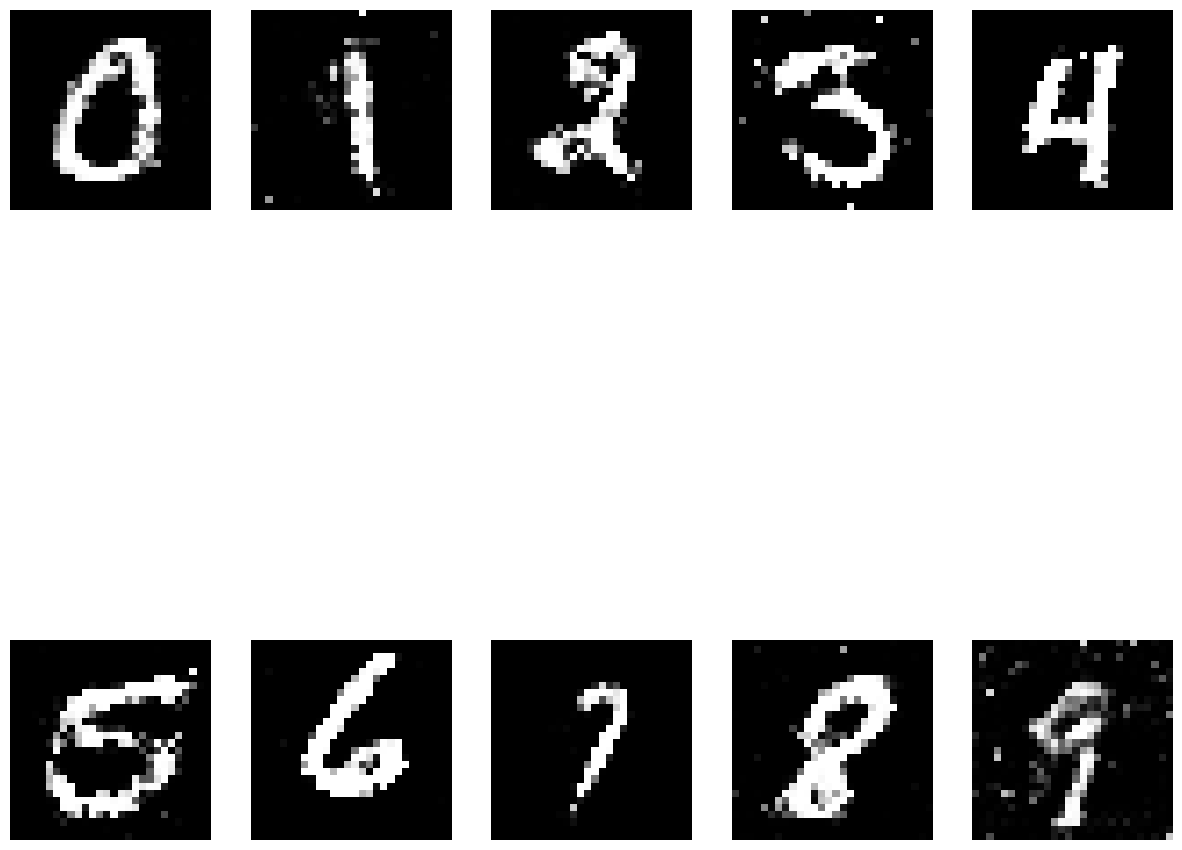

[81/150]	Loss_D: 1.3757	Loss_G: 0.7932	D(x): 0.5292	D(G(z)): 0.4835 / 0.4786
[82/150]	Loss_D: 1.2872	Loss_G: 0.8968	D(x): 0.5590	D(G(z)): 0.4567 / 0.4429
[83/150]	Loss_D: 1.2551	Loss_G: 0.8555	D(x): 0.5492	D(G(z)): 0.4569 / 0.4418
[84/150]	Loss_D: 1.2431	Loss_G: 0.8069	D(x): 0.5496	D(G(z)): 0.4331 / 0.4679
[85/150]	Loss_D: 1.3087	Loss_G: 0.7940	D(x): 0.5513	D(G(z)): 0.4794 / 0.4626
[86/150]	Loss_D: 1.2851	Loss_G: 0.8811	D(x): 0.5479	D(G(z)): 0.4580 / 0.4326
[87/150]	Loss_D: 1.3334	Loss_G: 0.7815	D(x): 0.5365	D(G(z)): 0.4777 / 0.4736
[88/150]	Loss_D: 1.2908	Loss_G: 0.7838	D(x): 0.5112	D(G(z)): 0.4358 / 0.4677
[89/150]	Loss_D: 1.3034	Loss_G: 0.8100	D(x): 0.5582	D(G(z)): 0.4784 / 0.4591
[90/150]	Loss_D: 1.3180	Loss_G: 0.7417	D(x): 0.5605	D(G(z)): 0.4936 / 0.4896


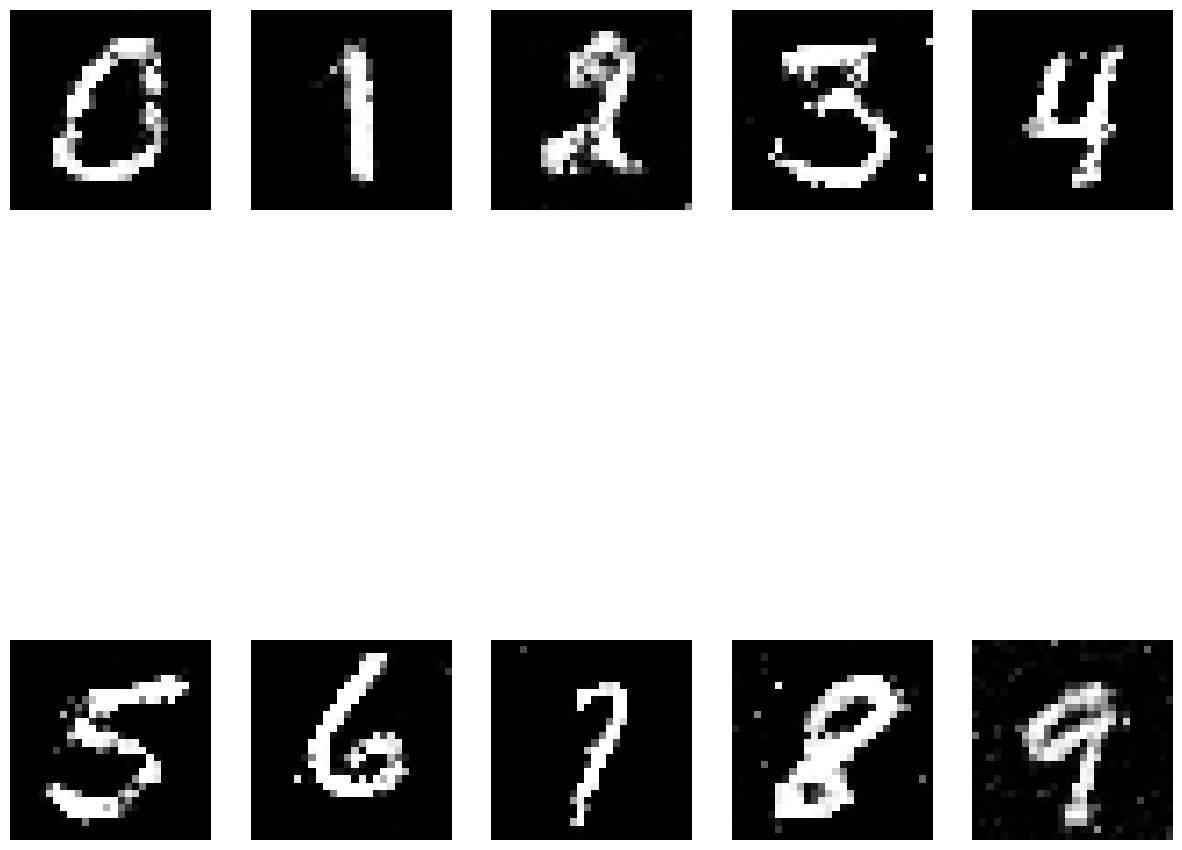

[91/150]	Loss_D: 1.3616	Loss_G: 0.8679	D(x): 0.5325	D(G(z)): 0.4812 / 0.4442
[92/150]	Loss_D: 1.3414	Loss_G: 0.7356	D(x): 0.5300	D(G(z)): 0.4760 / 0.4921
[93/150]	Loss_D: 1.3416	Loss_G: 0.8709	D(x): 0.5357	D(G(z)): 0.4753 / 0.4387
[94/150]	Loss_D: 1.3089	Loss_G: 0.7976	D(x): 0.5502	D(G(z)): 0.4734 / 0.4701
[95/150]	Loss_D: 1.2774	Loss_G: 0.8041	D(x): 0.5446	D(G(z)): 0.4566 / 0.4685
[96/150]	Loss_D: 1.2306	Loss_G: 0.9842	D(x): 0.5471	D(G(z)): 0.4203 / 0.4117
[97/150]	Loss_D: 1.2246	Loss_G: 0.7546	D(x): 0.5760	D(G(z)): 0.4453 / 0.4892
[98/150]	Loss_D: 1.2338	Loss_G: 0.8159	D(x): 0.5503	D(G(z)): 0.4474 / 0.4537
[99/150]	Loss_D: 1.2648	Loss_G: 0.8519	D(x): 0.5331	D(G(z)): 0.4395 / 0.4411
[100/150]	Loss_D: 1.3003	Loss_G: 0.8016	D(x): 0.5738	D(G(z)): 0.4910 / 0.4654


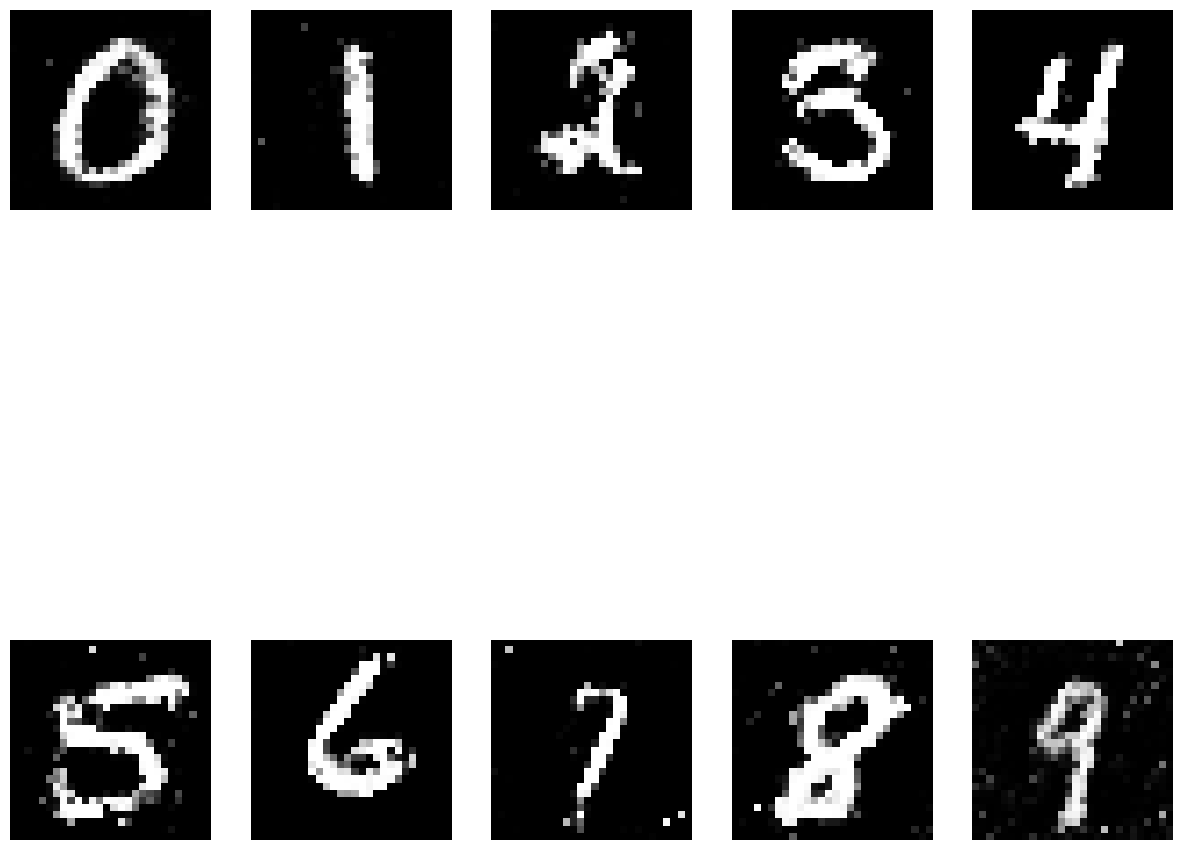

[101/150]	Loss_D: 1.2852	Loss_G: 0.8527	D(x): 0.5208	D(G(z)): 0.4445 / 0.4413
[102/150]	Loss_D: 1.2672	Loss_G: 0.8725	D(x): 0.5285	D(G(z)): 0.4425 / 0.4323
[103/150]	Loss_D: 1.3575	Loss_G: 0.8706	D(x): 0.5182	D(G(z)): 0.4667 / 0.4416
[104/150]	Loss_D: 1.2788	Loss_G: 0.8067	D(x): 0.5537	D(G(z)): 0.4625 / 0.4675
[105/150]	Loss_D: 1.3453	Loss_G: 0.8848	D(x): 0.5044	D(G(z)): 0.4460 / 0.4382
[106/150]	Loss_D: 1.3553	Loss_G: 0.7637	D(x): 0.5484	D(G(z)): 0.4938 / 0.4866
[107/150]	Loss_D: 1.2696	Loss_G: 0.8526	D(x): 0.5213	D(G(z)): 0.4356 / 0.4408
[108/150]	Loss_D: 1.2820	Loss_G: 0.8554	D(x): 0.5217	D(G(z)): 0.4397 / 0.4398
[109/150]	Loss_D: 1.3441	Loss_G: 0.8276	D(x): 0.5279	D(G(z)): 0.4732 / 0.4649
[110/150]	Loss_D: 1.2243	Loss_G: 0.8947	D(x): 0.5390	D(G(z)): 0.4319 / 0.4266


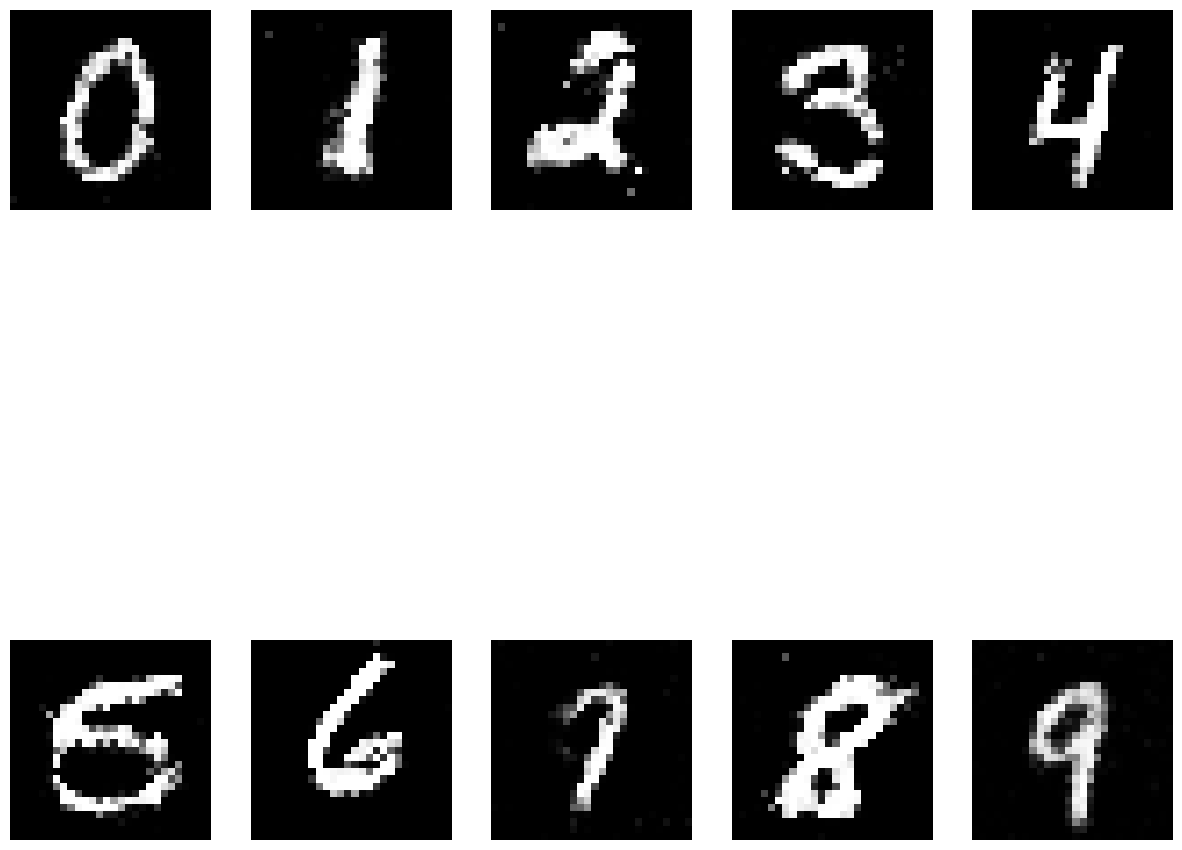

[111/150]	Loss_D: 1.3629	Loss_G: 0.8184	D(x): 0.5276	D(G(z)): 0.4590 / 0.4642
[112/150]	Loss_D: 1.3046	Loss_G: 0.8462	D(x): 0.5222	D(G(z)): 0.4453 / 0.4488
[113/150]	Loss_D: 1.3541	Loss_G: 0.9231	D(x): 0.5356	D(G(z)): 0.4663 / 0.4217
[114/150]	Loss_D: 1.3246	Loss_G: 0.8475	D(x): 0.5109	D(G(z)): 0.4362 / 0.4458
[115/150]	Loss_D: 1.3197	Loss_G: 0.8467	D(x): 0.5317	D(G(z)): 0.4535 / 0.4457
[116/150]	Loss_D: 1.3755	Loss_G: 0.8093	D(x): 0.5340	D(G(z)): 0.4917 / 0.4588
[117/150]	Loss_D: 1.2734	Loss_G: 0.8145	D(x): 0.5730	D(G(z)): 0.4694 / 0.4603
[118/150]	Loss_D: 1.2682	Loss_G: 0.8386	D(x): 0.5416	D(G(z)): 0.4411 / 0.4484
[119/150]	Loss_D: 1.2500	Loss_G: 0.9019	D(x): 0.5599	D(G(z)): 0.4432 / 0.4367
[120/150]	Loss_D: 1.3525	Loss_G: 0.8113	D(x): 0.5442	D(G(z)): 0.4831 / 0.4609


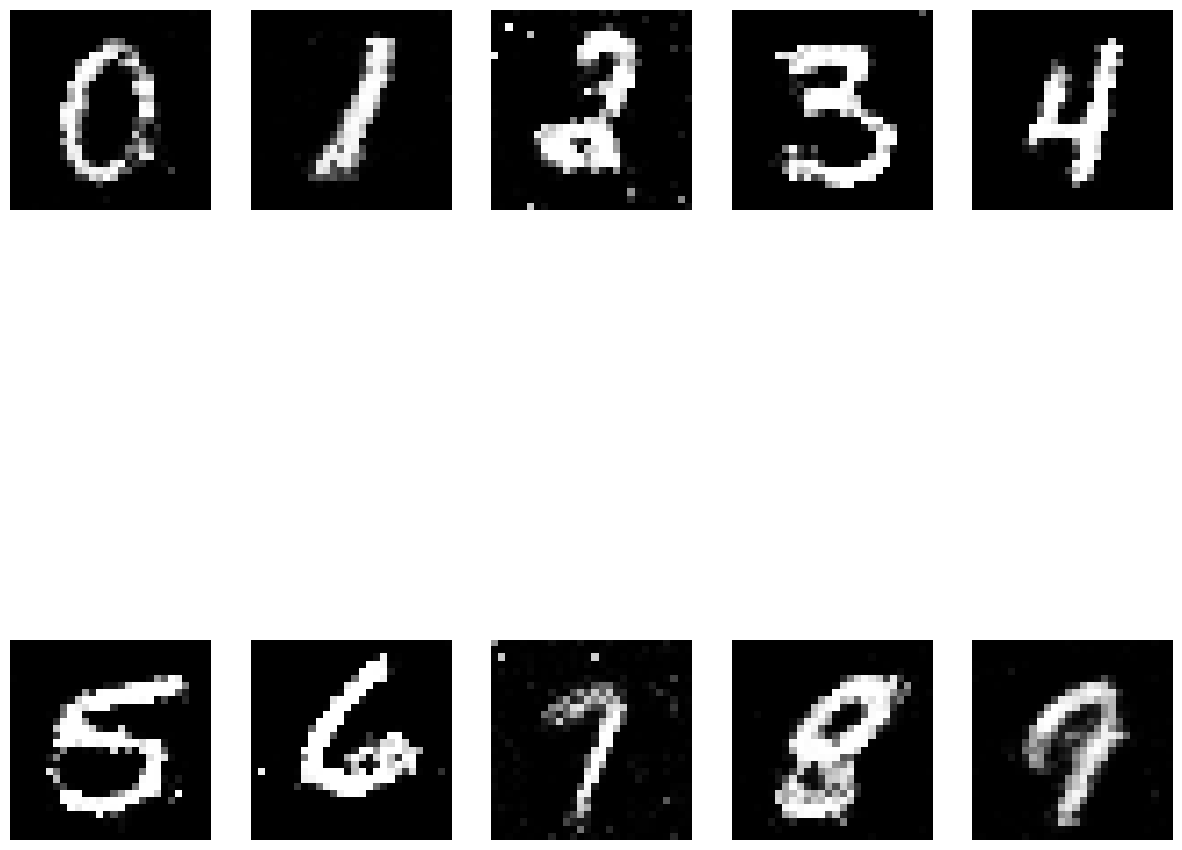

[121/150]	Loss_D: 1.2752	Loss_G: 0.7511	D(x): 0.5759	D(G(z)): 0.4753 / 0.4932
[122/150]	Loss_D: 1.3213	Loss_G: 0.9347	D(x): 0.5062	D(G(z)): 0.4392 / 0.4167
[123/150]	Loss_D: 1.2706	Loss_G: 0.8457	D(x): 0.5480	D(G(z)): 0.4517 / 0.4553
[124/150]	Loss_D: 1.3307	Loss_G: 0.8667	D(x): 0.5281	D(G(z)): 0.4668 / 0.4435
[125/150]	Loss_D: 1.2841	Loss_G: 0.9314	D(x): 0.5371	D(G(z)): 0.4481 / 0.4129
[126/150]	Loss_D: 1.3368	Loss_G: 0.9287	D(x): 0.5255	D(G(z)): 0.4481 / 0.4157
[127/150]	Loss_D: 1.2719	Loss_G: 0.8409	D(x): 0.5265	D(G(z)): 0.4378 / 0.4470
[128/150]	Loss_D: 1.2620	Loss_G: 0.8251	D(x): 0.5713	D(G(z)): 0.4647 / 0.4580
[129/150]	Loss_D: 1.2944	Loss_G: 0.7966	D(x): 0.5522	D(G(z)): 0.4750 / 0.4633
[130/150]	Loss_D: 1.3448	Loss_G: 0.8115	D(x): 0.5566	D(G(z)): 0.4890 / 0.4652


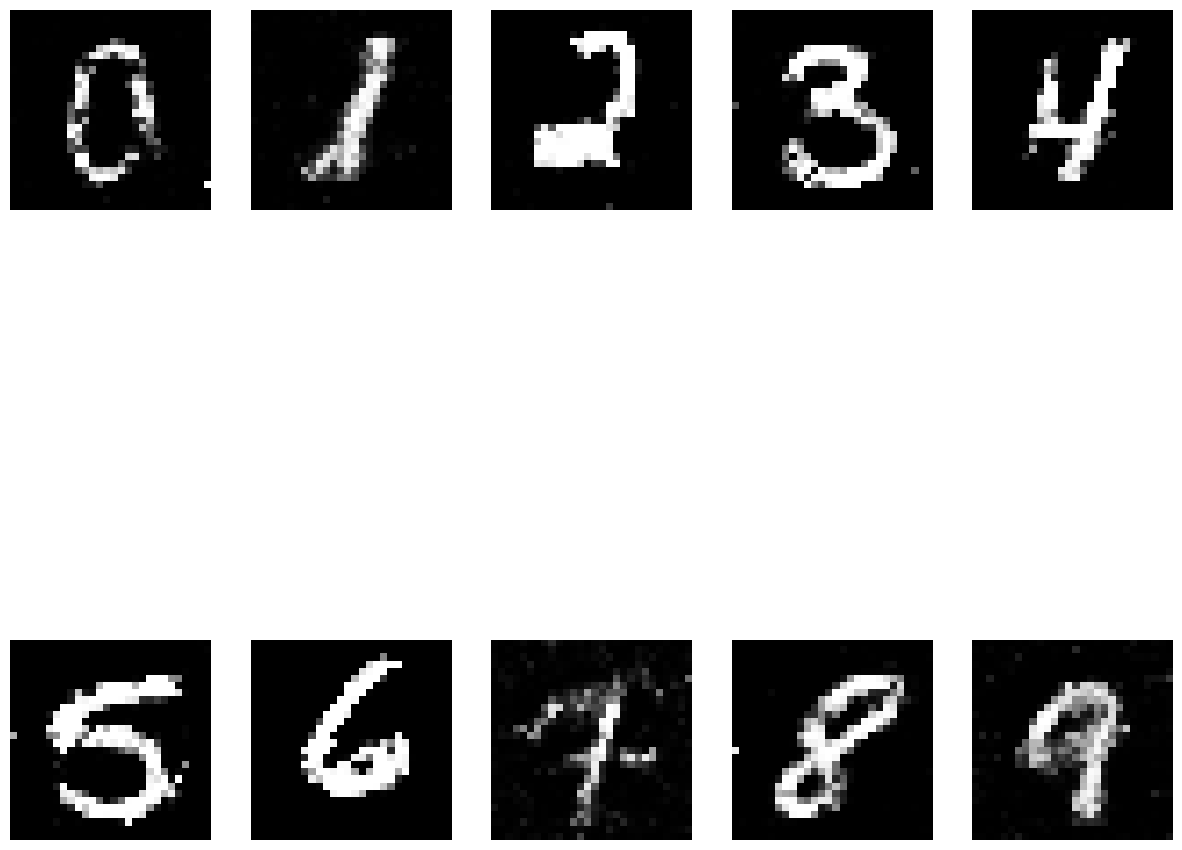

[131/150]	Loss_D: 1.2702	Loss_G: 0.8095	D(x): 0.5705	D(G(z)): 0.4695 / 0.4671
[132/150]	Loss_D: 1.3170	Loss_G: 0.8452	D(x): 0.5342	D(G(z)): 0.4566 / 0.4468
[133/150]	Loss_D: 1.3378	Loss_G: 0.8275	D(x): 0.5347	D(G(z)): 0.4764 / 0.4572
[134/150]	Loss_D: 1.2397	Loss_G: 0.8636	D(x): 0.5582	D(G(z)): 0.4448 / 0.4426
[135/150]	Loss_D: 1.2944	Loss_G: 0.8144	D(x): 0.5593	D(G(z)): 0.4740 / 0.4618
[136/150]	Loss_D: 1.3234	Loss_G: 0.8416	D(x): 0.5303	D(G(z)): 0.4634 / 0.4506
[137/150]	Loss_D: 1.2482	Loss_G: 0.8524	D(x): 0.5503	D(G(z)): 0.4497 / 0.4419
[138/150]	Loss_D: 1.3102	Loss_G: 0.9153	D(x): 0.5494	D(G(z)): 0.4647 / 0.4329
[139/150]	Loss_D: 1.2901	Loss_G: 0.8426	D(x): 0.5424	D(G(z)): 0.4566 / 0.4466
[140/150]	Loss_D: 1.2897	Loss_G: 0.8567	D(x): 0.5504	D(G(z)): 0.4674 / 0.4484


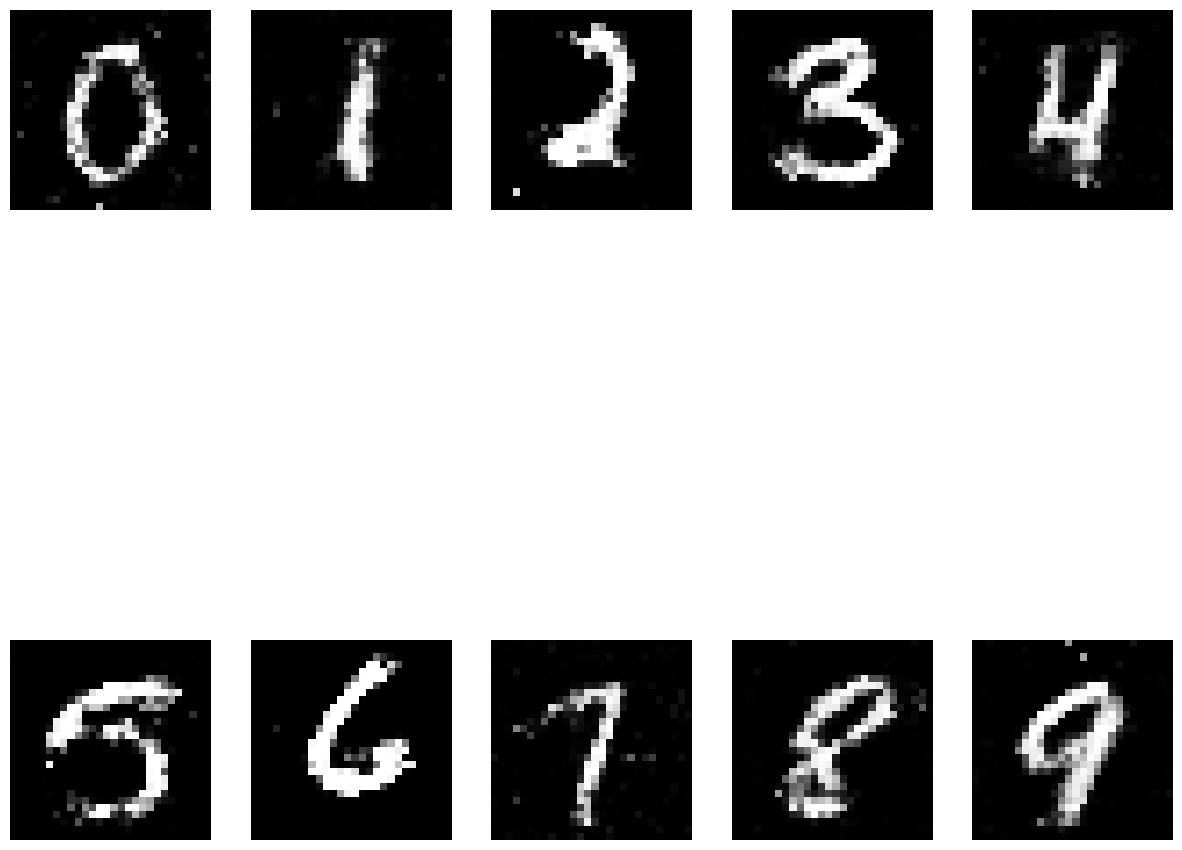

[141/150]	Loss_D: 1.3344	Loss_G: 0.7686	D(x): 0.5566	D(G(z)): 0.4865 / 0.4816
[142/150]	Loss_D: 1.3203	Loss_G: 0.8338	D(x): 0.5856	D(G(z)): 0.4991 / 0.4573
[143/150]	Loss_D: 1.2304	Loss_G: 0.8889	D(x): 0.5554	D(G(z)): 0.4295 / 0.4379
[144/150]	Loss_D: 1.2803	Loss_G: 0.8583	D(x): 0.5586	D(G(z)): 0.4671 / 0.4373
[145/150]	Loss_D: 1.3145	Loss_G: 0.8464	D(x): 0.5734	D(G(z)): 0.4868 / 0.4530
[146/150]	Loss_D: 1.3693	Loss_G: 0.8503	D(x): 0.5154	D(G(z)): 0.4684 / 0.4506
[147/150]	Loss_D: 1.2828	Loss_G: 0.8710	D(x): 0.5491	D(G(z)): 0.4538 / 0.4474
[148/150]	Loss_D: 1.3080	Loss_G: 0.8423	D(x): 0.5194	D(G(z)): 0.4471 / 0.4458
[149/150]	Loss_D: 1.3868	Loss_G: 0.8345	D(x): 0.5084	D(G(z)): 0.4546 / 0.4527
[150/150]	Loss_D: 1.2622	Loss_G: 0.9046	D(x): 0.5452	D(G(z)): 0.4449 / 0.4234
Training Finished!


In [ ]:
G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
  D_losses = []
  G_losses = []

  for i, (images, labels) in enumerate(train_loader):
    #############################
    # 1) Update discriminator D #
    #############################
    D.zero_grad()

    images_real = images.to(device)
    
    # real label
    labels_real = torch.zeros((labels.shape[0], 10), )
    labels_real = labels_real.type(torch.int64)
    labels_real.scatter_(1, labels.unsqueeze(1), 1)
    labels_real = labels_real.to(device)
    
    # fake label
    labels_fake_tmp = torch.randint(0, 10, (labels.shape[0], ))
    
    labels_fake = torch.zeros((labels.shape[0], 10), )
    labels_fake = labels_fake.type(torch.int64)
    labels_fake.scatter_(1, labels_fake_tmp.unsqueeze(1), 1)
    labels_fake = labels_fake.to(device)
    
    y_pred_real = D(images_real, labels_real).view(-1)
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)
    
    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    D_real_loss = criterion(y_pred_real, label)
    D_real_loss.backward()

    D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)
    images_fake = G(noises, labels_fake)

    y_pred_fake = D(images_fake.detach(), labels_fake).view(-1)
    label.fill_(0.)

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    D_fake_loss = criterion(y_pred_fake, label)
    D_fake_loss.backward()

    D_G_z1 = y_pred_fake.mean().item()

    D_loss = D_real_loss + D_fake_loss

    # Update D
    D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    G.zero_grad()

    y_pred_fake = D(images_fake, labels_fake).view(-1)
    label.fill_(1.)

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    G_loss = criterion(y_pred_fake, label)
    G_loss.backward()

    D_G_z2 = y_pred_fake.mean().item()

    # Update G
    G_optimizer.step()
    '''
    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
    '''
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
    
  if epoch % 10 == 0:
      generated_image = G(noise2, c).cpu().detach().numpy().squeeze()

      fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

      for ax in axes.flat:
          ax.axis('off')

      axes[0, 0].imshow(generated_image[0], cmap='gray')
      axes[0, 1].imshow(generated_image[1], cmap='gray')
      axes[0, 2].imshow(generated_image[2], cmap='gray')
      axes[0, 3].imshow(generated_image[3], cmap='gray')
      axes[0, 4].imshow(generated_image[4], cmap='gray')
      axes[1, 0].imshow(generated_image[5], cmap='gray')
      axes[1, 1].imshow(generated_image[6], cmap='gray')
      axes[1, 2].imshow(generated_image[7], cmap='gray')
      axes[1, 3].imshow(generated_image[8], cmap='gray')
      axes[1, 4].imshow(generated_image[9], cmap='gray')

      plt.show()
  
  print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
         % (epoch+1, EPOCHS, D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
  
  train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
  train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))

print('Training Finished!')

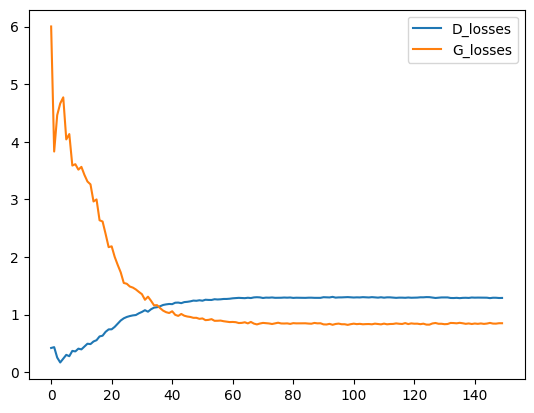

In [ ]:
x = [i for i in range(len(train_hist['D_losses']))]

plt.plot(x, train_hist['D_losses'], label='D_losses')
plt.plot(x, train_hist['G_losses'], label='G_losses')
plt.legend()
plt.show()

In [ ]:
# 학습 결과를 바탕으로 시각화
z = torch.randn(10, 100).to(device)

c = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                         ]).to(device)

y = G(z, c).reshape(10, 28, 28).to(device)

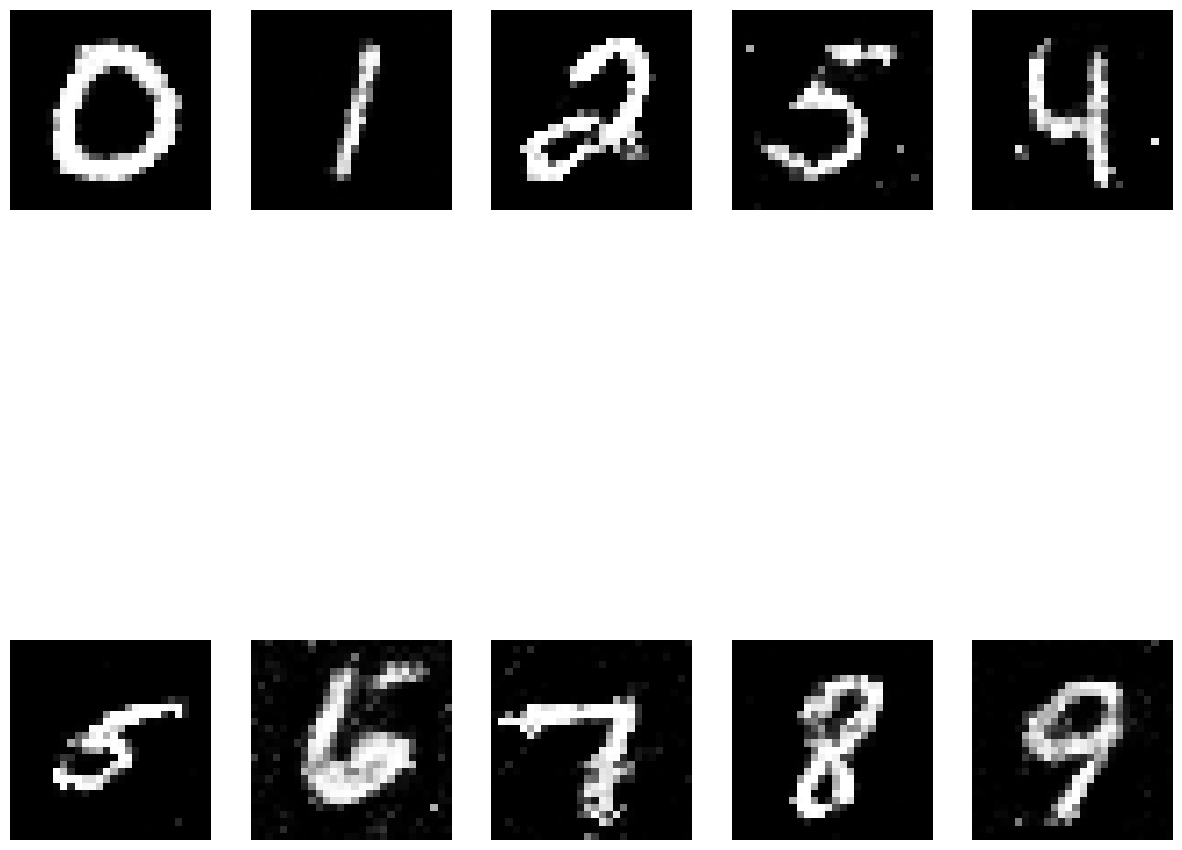

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

for ax in axes.flat:
    ax.axis('off')

axes[0,0].imshow(y[0].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,1].imshow(y[1].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,2].imshow(y[2].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,3].imshow(y[3].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,4].imshow(y[4].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,0].imshow(y[5].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,1].imshow(y[6].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,2].imshow(y[7].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,3].imshow(y[8].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,4].imshow(y[9].to('cpu').detach().numpy().reshape(28,28), cmap='gray')

## 결과분석
- epoch가 증가함에 따라 condition대로 이미지가 생성됨
- condition으로 인해 기존의 GAN 보다 좀 더 명확한 이미지를 생성 가능
- GAN의 경우 이상한 숫자도 있었지만 condition GAN에서는 형태를 알아 볼 수 있음
- condition으로 원하는 숫자의 이미지를 생성하는것도 가능 (제어능력 증가)
- 이미지의 퀄리티 자체는 비슷하지만 만들고 싶은 이미지를 만들수 있다는 점이 장점
- 그래프를 보면 일정 부분에서 수렴하는데 epoch를 크게 설정해서 overfitting이 발생했을 수 있음
- 3을 생성한 이미지로 보면 5에 조금 더 가까운 결과를 보임 -> overfitting?

## TODO (4)

위의 내용을 noise의 dim 값을 바꾸어 실험해 본다.
- learning rate 조절
- noise의 dim을 100 -> 50으로 변경
- linear layer 추가
- epoch = 50으로 설정

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.linear     = torch.nn.Linear(50, 512, bias=True)
        self.bn1        = torch.nn.BatchNorm1d(num_features=512)
        self.linear2    = torch.nn.Linear(512, 2048, bias=True)
        self.bn2        = torch.nn.BatchNorm1d(num_features=2048)
        self.linear3    = torch.nn.Linear(2048, 7*7*256, bias=True)
        # self.bn3        = torch.nn.BatchNorm1d(num_features=7*7*256)
        self.convt1     = torch.nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=2, bias=False)
        self.bn4        = torch.nn.BatchNorm2d(128)
        self.convt2     = torch.nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)
        self.bn5        = torch.nn.BatchNorm2d(64)
        self.convt3     = torch.nn.ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)

        self.lrelu      = torch.nn.LeakyReLU()
        self.tanh       = torch.nn.Tanh()

    def generator(self, z):
        z = self.lrelu(self.bn1(self.linear(z)))
        z = self.lrelu(self.bn2(self.linear2(z)))
        z = self.lrelu(self.linear3(z)).reshape(-1, 256, 7, 7)
        z = self.lrelu(self.bn4(self.convt1(z)))
        z = self.lrelu(self.bn5(self.convt2(z)))
        z = self.tanh(self.convt3(z)).reshape(-1, 1, 28, 28)

        return z

    def forward(self, z):
        z = self.generator(z)

        return z

G = Generator().to(device)

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1      = torch.nn.Conv2d(1, 64, (4, 4), stride=(2, 2), padding=1, bias=False)
        self.conv2      = torch.nn.Conv2d(64, 128, (4, 4), stride=(2, 2), padding=1, bias=False)
        self.flatten    = torch.nn.Flatten()
        self.linear     = torch.nn.Linear(7*7*128, 1, bias=False)

        self.lrelu      = torch.nn.LeakyReLU()
        self.sigmoid    = torch.nn.Sigmoid()
        self.dropout    = torch.nn.Dropout(0.3)

    def discriminator(self, z):
        z = self.dropout(self.lrelu(self.conv1(z)))
        z = self.flatten(self.dropout(self.lrelu(self.conv2(z))))
        z = self.sigmoid(self.linear(z))

        return z

    def forward(self, z):
        z = self.discriminator(z)

        return z

D = Discriminator().to(device)

In [ ]:
learning_rate = 0.0002

In [ ]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# GAN 트레이닝에 쓰일 optimizer 정의
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

In [ ]:
noise_dim = 50

In [ ]:
summary(G, (BATCH_SIZE, 50))
summary(D, (BATCH_SIZE, 1, 28, 28))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [256, 1]                  --
├─Conv2d: 1-1                            [256, 64, 14, 14]         1,024
├─LeakyReLU: 1-2                         [256, 64, 14, 14]         --
├─Dropout: 1-3                           [256, 64, 14, 14]         --
├─Conv2d: 1-4                            [256, 128, 7, 7]          131,072
├─LeakyReLU: 1-5                         [256, 128, 7, 7]          --
├─Dropout: 1-6                           [256, 128, 7, 7]          --
├─Flatten: 1-7                           [256, 6272]               --
├─Linear: 1-8                            [256, 1]                  6,272
├─Sigmoid: 1-9                           [256, 1]                  --
Total params: 138,368
Trainable params: 138,368
Non-trainable params: 0
Total mult-adds (G): 1.70
Input size (MB): 0.80
Forward/backward pass size (MB): 38.54
Params size (MB): 0.55
Estimated Total Size (MB): 39.89

In [ ]:
EPOCHS = 50
noise3 = torch.randn(10, 50).to(device)

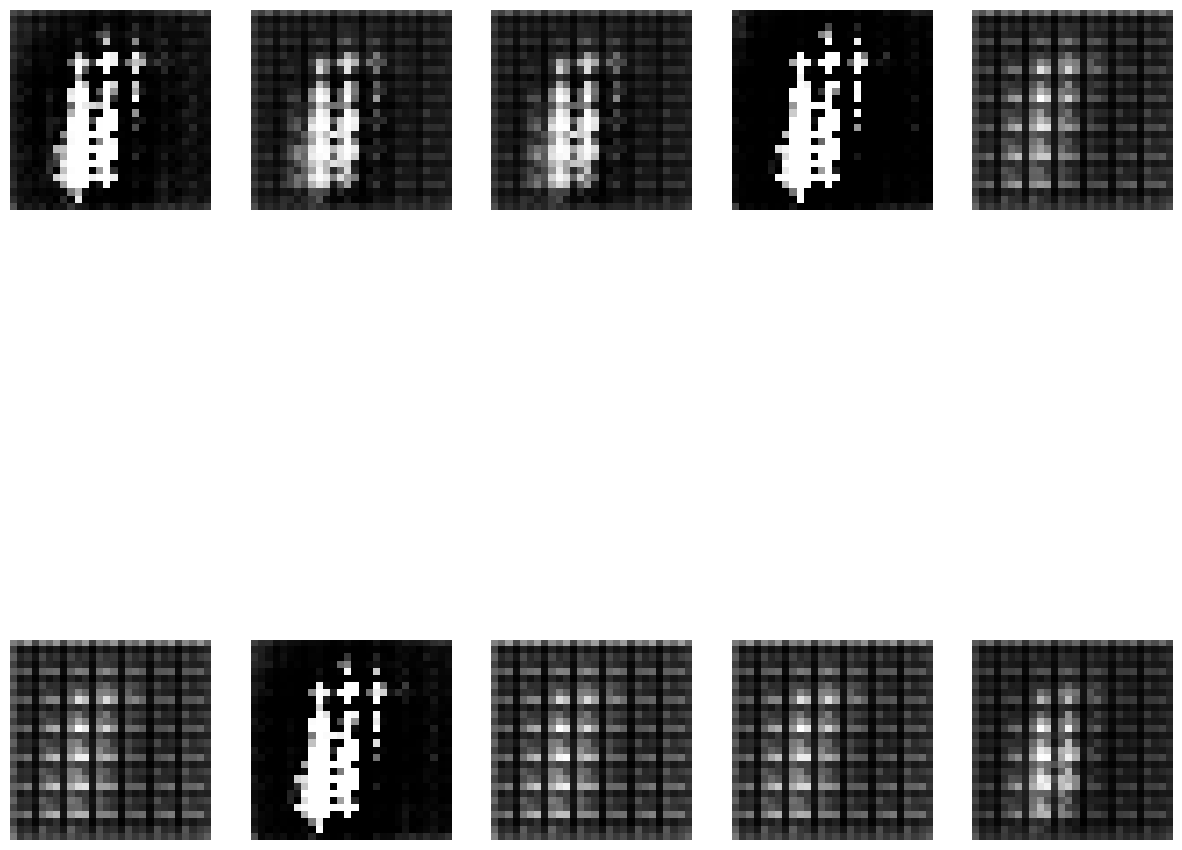

[1/50]	Loss_D: 0.8665	Loss_G: 1.3999	D(x): 0.6803	D(G(z)): 0.3223 / 0.2708
[2/50]	Loss_D: 0.8642	Loss_G: 1.3935	D(x): 0.7510	D(G(z)): 0.3701 / 0.2806
[3/50]	Loss_D: 0.7351	Loss_G: 1.4465	D(x): 0.8710	D(G(z)): 0.3825 / 0.3184
[4/50]	Loss_D: 0.8173	Loss_G: 0.9916	D(x): 0.8441	D(G(z)): 0.4175 / 0.4125
[5/50]	Loss_D: 0.5324	Loss_G: 1.2537	D(x): 0.9151	D(G(z)): 0.3371 / 0.3318
[6/50]	Loss_D: 0.7587	Loss_G: 0.9880	D(x): 0.8905	D(G(z)): 0.4390 / 0.4133
[7/50]	Loss_D: 0.6584	Loss_G: 1.1225	D(x): 0.9121	D(G(z)): 0.4007 / 0.3918
[8/50]	Loss_D: 0.6591	Loss_G: 0.8292	D(x): 0.9679	D(G(z)): 0.4546 / 0.4593
[9/50]	Loss_D: 0.4710	Loss_G: 1.5844	D(x): 0.9575	D(G(z)): 0.3291 / 0.3085
[10/50]	Loss_D: 0.3858	Loss_G: 1.8540	D(x): 0.9760	D(G(z)): 0.2809 / 0.2492


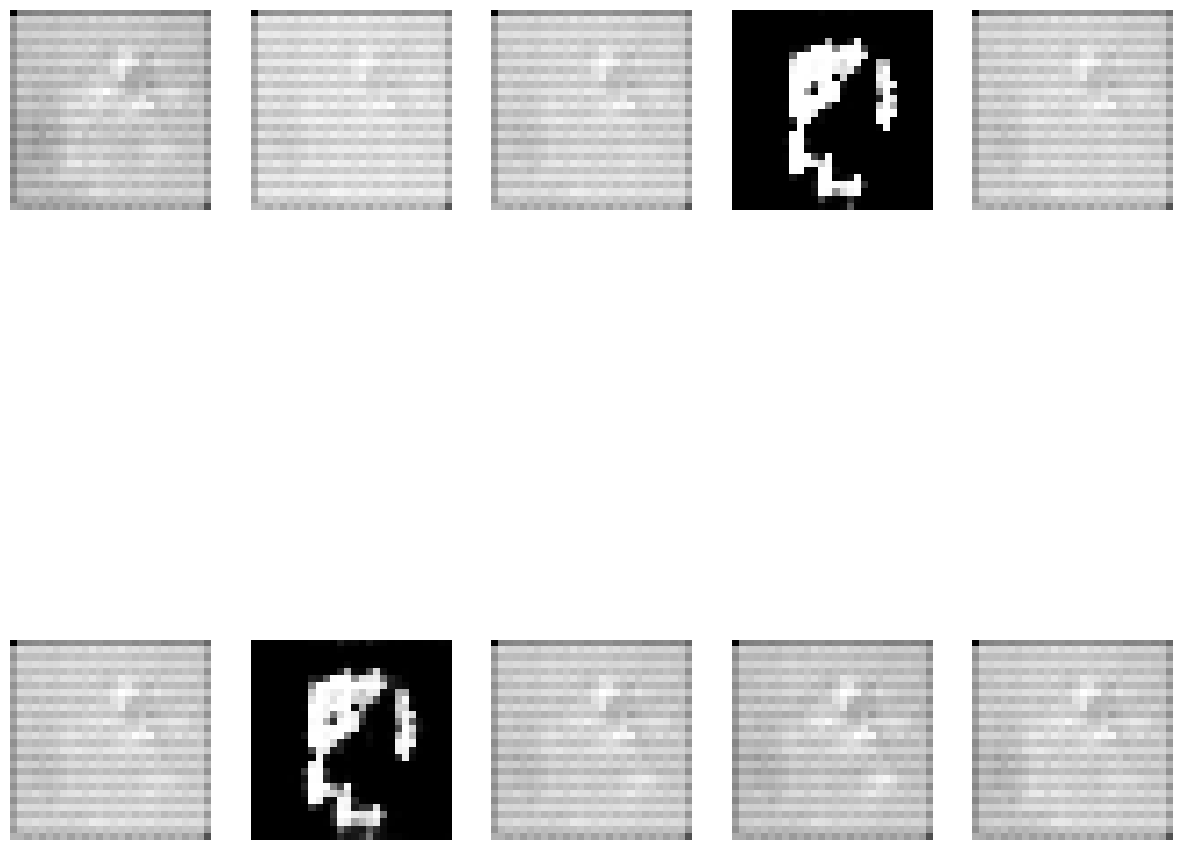

[11/50]	Loss_D: 0.4486	Loss_G: 1.4842	D(x): 0.9539	D(G(z)): 0.3075 / 0.3068
[12/50]	Loss_D: 0.5422	Loss_G: 1.2662	D(x): 0.9774	D(G(z)): 0.3866 / 0.3811
[13/50]	Loss_D: 0.6133	Loss_G: 0.8566	D(x): 0.9871	D(G(z)): 0.4354 / 0.4475
[14/50]	Loss_D: 0.5978	Loss_G: 1.0630	D(x): 0.9823	D(G(z)): 0.4267 / 0.4220
[15/50]	Loss_D: 0.5827	Loss_G: 0.9804	D(x): 0.9798	D(G(z)): 0.4209 / 0.4200
[16/50]	Loss_D: 0.4143	Loss_G: 1.4377	D(x): 0.9746	D(G(z)): 0.3080 / 0.3128
[17/50]	Loss_D: 0.5786	Loss_G: 1.1330	D(x): 0.9665	D(G(z)): 0.3779 / 0.3787
[18/50]	Loss_D: 0.6893	Loss_G: 0.8418	D(x): 0.9512	D(G(z)): 0.4443 / 0.4647
[19/50]	Loss_D: 0.5653	Loss_G: 1.1998	D(x): 0.9721	D(G(z)): 0.3673 / 0.3652
[20/50]	Loss_D: 0.5654	Loss_G: 0.8841	D(x): 0.9846	D(G(z)): 0.4155 / 0.4229


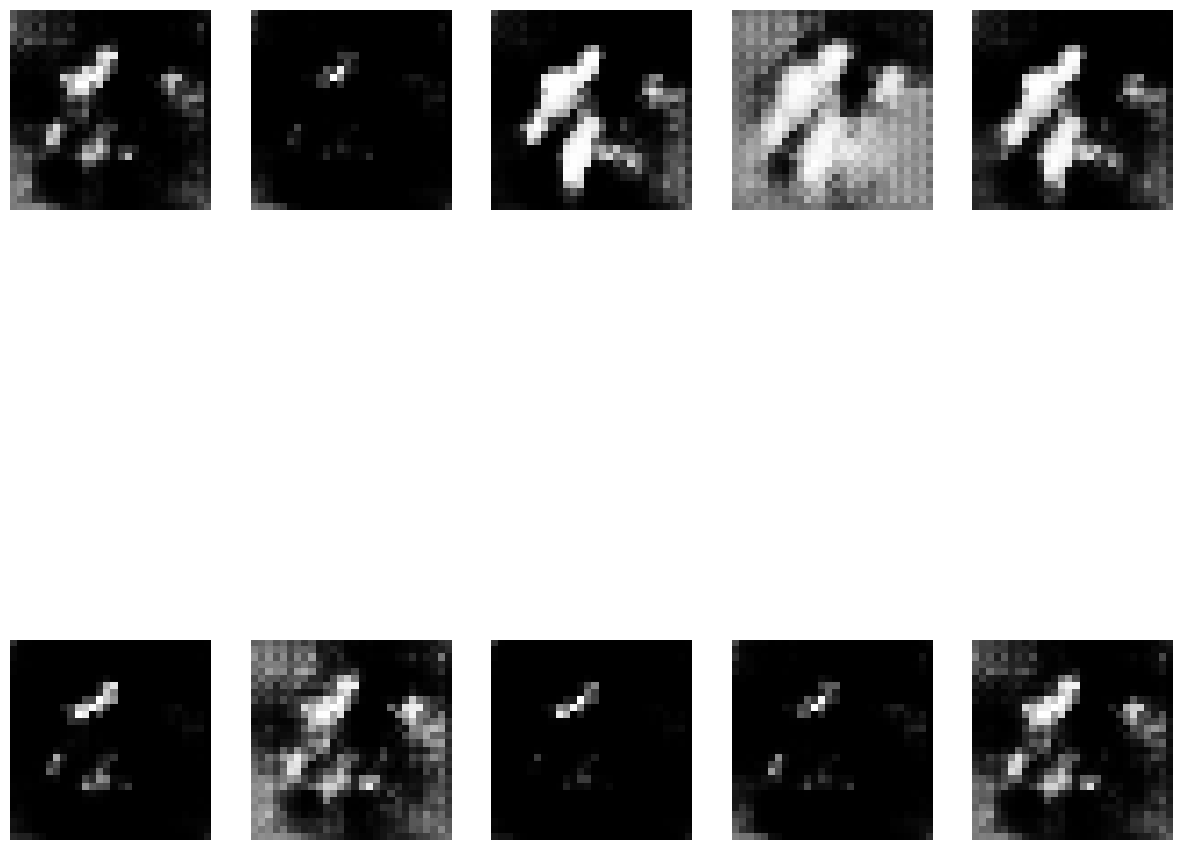

[21/50]	Loss_D: 0.5718	Loss_G: 0.9953	D(x): 0.9872	D(G(z)): 0.4229 / 0.4225
[22/50]	Loss_D: 0.6005	Loss_G: 1.0409	D(x): 0.9725	D(G(z)): 0.4033 / 0.3856
[23/50]	Loss_D: 0.5669	Loss_G: 0.9085	D(x): 0.9922	D(G(z)): 0.4253 / 0.4259
[24/50]	Loss_D: 0.6376	Loss_G: 0.8877	D(x): 0.9804	D(G(z)): 0.4367 / 0.4371
[25/50]	Loss_D: 0.4585	Loss_G: 1.0392	D(x): 0.9990	D(G(z)): 0.3640 / 0.3633
[26/50]	Loss_D: 0.6233	Loss_G: 1.0631	D(x): 0.9737	D(G(z)): 0.4322 / 0.4339
[27/50]	Loss_D: 0.5980	Loss_G: 0.8551	D(x): 0.9981	D(G(z)): 0.4477 / 0.4500
[28/50]	Loss_D: 0.5887	Loss_G: 0.9853	D(x): 0.9987	D(G(z)): 0.4366 / 0.4423
[29/50]	Loss_D: 0.6603	Loss_G: 0.8614	D(x): 0.9900	D(G(z)): 0.4506 / 0.4374
[30/50]	Loss_D: 0.6283	Loss_G: 0.9565	D(x): 0.9988	D(G(z)): 0.4617 / 0.4560


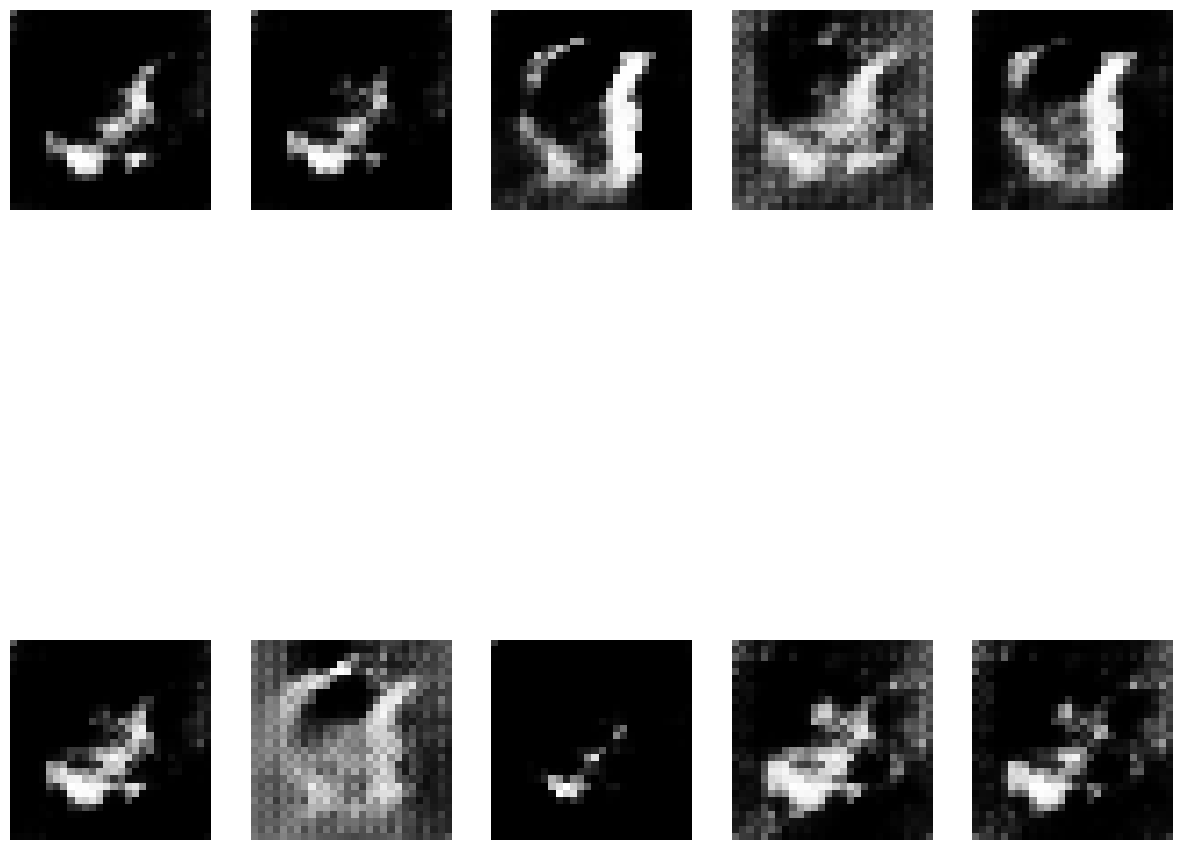

[31/50]	Loss_D: 0.6243	Loss_G: 0.8106	D(x): 0.9987	D(G(z)): 0.4589 / 0.4668
[32/50]	Loss_D: 0.6015	Loss_G: 1.1674	D(x): 1.0000	D(G(z)): 0.4408 / 0.4186
[33/50]	Loss_D: 0.6183	Loss_G: 0.9714	D(x): 0.9998	D(G(z)): 0.4569 / 0.4567
[34/50]	Loss_D: 0.6853	Loss_G: 0.8069	D(x): 0.9896	D(G(z)): 0.4447 / 0.4485
[35/50]	Loss_D: 0.6221	Loss_G: 0.7599	D(x): 0.9990	D(G(z)): 0.4618 / 0.4688
[36/50]	Loss_D: 0.7170	Loss_G: 0.7866	D(x): 0.9899	D(G(z)): 0.4800 / 0.4715
[37/50]	Loss_D: 0.6494	Loss_G: 0.8376	D(x): 0.9809	D(G(z)): 0.4588 / 0.4618
[38/50]	Loss_D: 0.5820	Loss_G: 0.9460	D(x): 0.9996	D(G(z)): 0.4342 / 0.4462
[39/50]	Loss_D: 0.6493	Loss_G: 0.8143	D(x): 0.9934	D(G(z)): 0.4719 / 0.4708
[40/50]	Loss_D: 0.6600	Loss_G: 0.8281	D(x): 0.9921	D(G(z)): 0.4758 / 0.4762


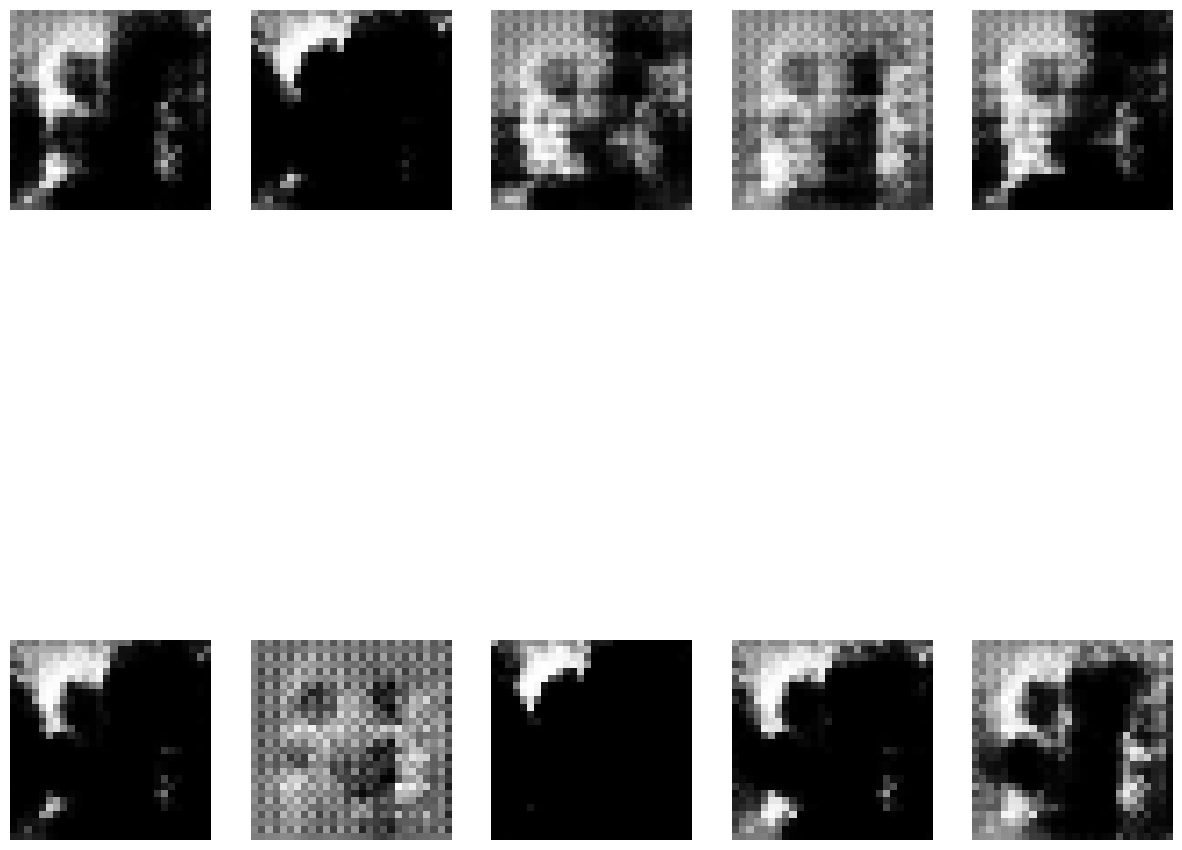

[41/50]	Loss_D: 0.6605	Loss_G: 0.7754	D(x): 0.9939	D(G(z)): 0.4639 / 0.4641
[42/50]	Loss_D: 0.5688	Loss_G: 0.9287	D(x): 0.9920	D(G(z)): 0.4245 / 0.4223
[43/50]	Loss_D: 0.6325	Loss_G: 0.8503	D(x): 0.9999	D(G(z)): 0.4659 / 0.4656
[44/50]	Loss_D: 0.4077	Loss_G: 1.5202	D(x): 0.9826	D(G(z)): 0.3013 / 0.2975
[45/50]	Loss_D: 0.6150	Loss_G: 0.8365	D(x): 1.0000	D(G(z)): 0.4546 / 0.4554
[46/50]	Loss_D: 0.5858	Loss_G: 0.8507	D(x): 0.9973	D(G(z)): 0.4392 / 0.4413
[47/50]	Loss_D: 0.6407	Loss_G: 0.8707	D(x): 0.9684	D(G(z)): 0.4299 / 0.4363
[48/50]	Loss_D: 0.6104	Loss_G: 0.8522	D(x): 0.9997	D(G(z)): 0.4560 / 0.4461
[49/50]	Loss_D: 0.0010	Loss_G: 20.5082	D(x): 0.9992	D(G(z)): 0.0001 / 0.0009
[50/50]	Loss_D: 0.3786	Loss_G: 1.3277	D(x): 0.9861	D(G(z)): 0.2932 / 0.3028
Training Finished!


In [ ]:
G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
  D_losses = []
  G_losses = []

  for i, (images, _) in enumerate(train_loader):
    #############################
    # 1) Update discriminator D #
    #############################
    D.zero_grad()

    images_real = images.to(device)
    y_pred_real = D(images_real).view(-1)    # 진짜 MNIST 데이터를 본 Discriminator의 판별값
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)    # 진짜 MNIST 데이터에 대한 label 값은 1
    
    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    D_real_loss = criterion(y_pred_real, label)
    D_real_loss.backward()

    D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)   # Generator에 입력으로 줄 noise 생성
    images_fake = G(noises)           # Generator는 noise로부터 가짜 데이터를 생성

    y_pred_fake = D(images_fake.detach()).view(-1)      # Generator가 만든 가짜 데이터를 본 Discriminator의 판별값
    label.fill_(0.)        # 가짜 데이터에 대한 label 값은 0

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    D_fake_loss = criterion(y_pred_fake, label)
    D_fake_loss.backward()

    D_G_z1 = y_pred_fake.mean().item()

    D_loss = D_real_loss + D_fake_loss

    # Update D
    D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    G.zero_grad()

    y_pred_fake = D(images_fake).view(-1)
    label.fill_(1.)       # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    G_loss = criterion(y_pred_fake, label)
    G_loss.backward()

    D_G_z2 = y_pred_fake.mean().item()

    # Update G
    G_optimizer.step()

    '''
    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
    '''
    
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())

  if epoch % 10 == 0:
    generated_image = G(noise3).cpu().detach().numpy().squeeze()

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

    for ax in axes.flat:
        ax.axis('off')

    axes[0, 0].imshow(generated_image[0], cmap='gray')
    axes[0, 1].imshow(generated_image[1], cmap='gray')
    axes[0, 2].imshow(generated_image[2], cmap='gray')
    axes[0, 3].imshow(generated_image[3], cmap='gray')
    axes[0, 4].imshow(generated_image[4], cmap='gray')
    axes[1, 0].imshow(generated_image[5], cmap='gray')
    axes[1, 1].imshow(generated_image[6], cmap='gray')
    axes[1, 2].imshow(generated_image[7], cmap='gray')
    axes[1, 3].imshow(generated_image[8], cmap='gray')
    axes[1, 4].imshow(generated_image[9], cmap='gray')

    plt.show()

  print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
         % (epoch+1, EPOCHS,D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
  
  train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
  train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))

print('Training Finished!')

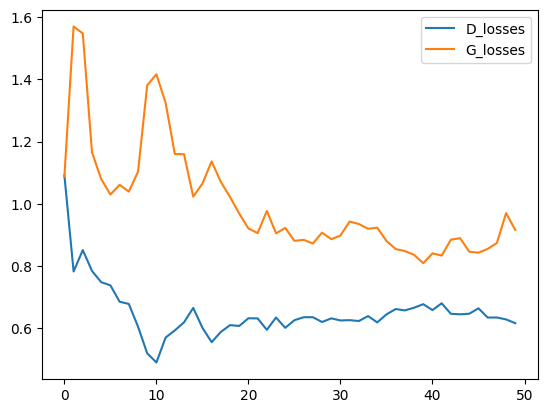

In [ ]:
x = [i for i in range(len(train_hist['D_losses']))]

plt.plot(x, train_hist['D_losses'], label='D_losses')
plt.plot(x, train_hist['G_losses'], label='G_losses')
plt.legend()
plt.show()

In [ ]:
noise4 = torch.randn(10, 50).to(device)

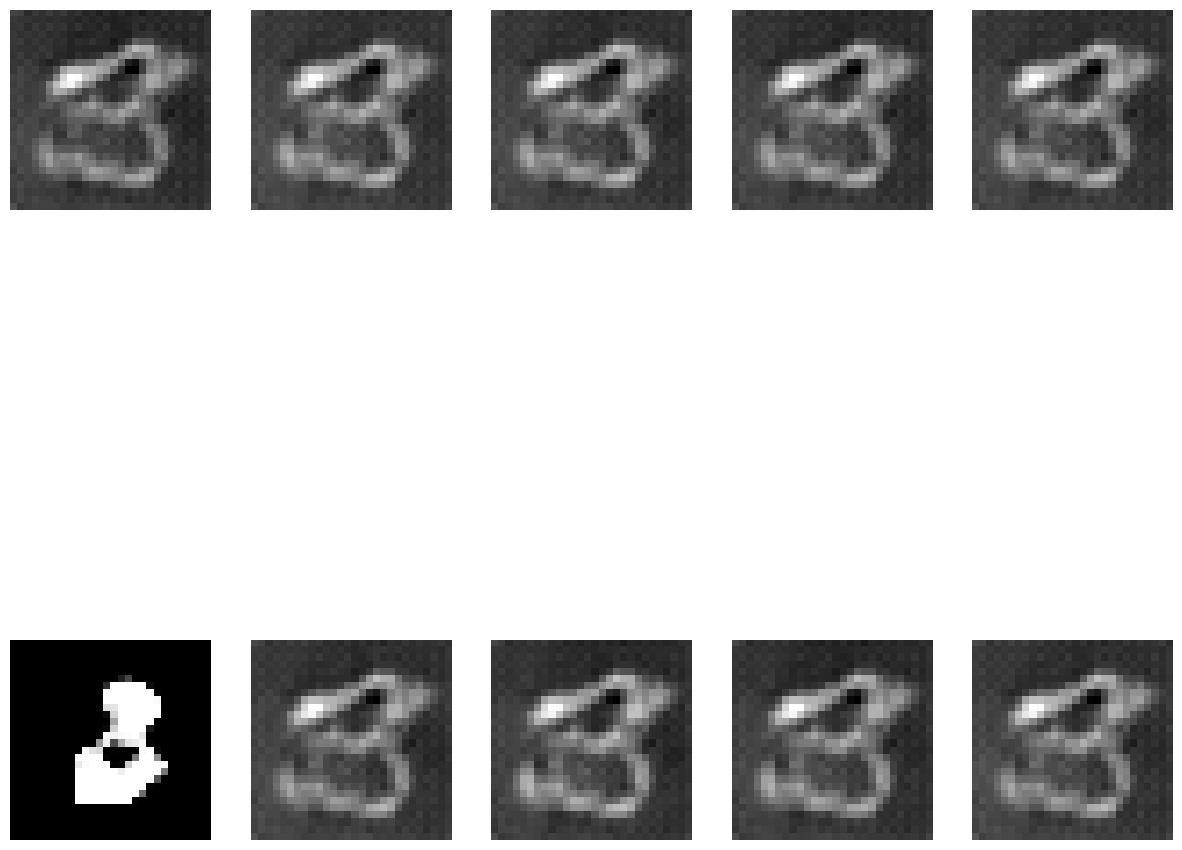

In [ ]:
G.eval()

generated_image = G(noise4).cpu().detach().numpy().squeeze()
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0, 0].imshow(generated_image[0], cmap='gray')
axes[0, 1].imshow(generated_image[1], cmap='gray')
axes[0, 2].imshow(generated_image[2], cmap='gray')
axes[0, 3].imshow(generated_image[3], cmap='gray')
axes[0, 4].imshow(generated_image[4], cmap='gray')
axes[1, 0].imshow(generated_image[5], cmap='gray')
axes[1, 1].imshow(generated_image[6], cmap='gray')
axes[1, 2].imshow(generated_image[7], cmap='gray')
axes[1, 3].imshow(generated_image[8], cmap='gray')
axes[1, 4].imshow(generated_image[9], cmap='gray')

plt.show()

## 결과분석
- generator의 학습이 잘 안되는것을 확인할 수 있음
- loss를 시각화 했을때 원래의 실험보다 loss도 불안정하고 좋지 못한 결과가 나옴
- noise의 크기가 작아서 그런 것 같다고 분석을 함
- 만들어낸 이미지 역시 좋지 못한 결과를 보임
- loss 그래프 역시 불안정한 모습을 보임

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.linear     = torch.nn.Linear(300, 512, bias=True)
        self.bn1        = torch.nn.BatchNorm1d(num_features=512)
        self.linear2    = torch.nn.Linear(512, 2048, bias=True)
        self.bn2        = torch.nn.BatchNorm1d(num_features=2048)
        self.linear3    = torch.nn.Linear(2048, 7*7*256, bias=True)
        # self.bn3        = torch.nn.BatchNorm1d(num_features=7*7*256)
        self.convt1     = torch.nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=2, bias=False)
        self.bn4        = torch.nn.BatchNorm2d(128)
        self.convt2     = torch.nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)
        self.bn5        = torch.nn.BatchNorm2d(64)
        self.convt3     = torch.nn.ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)

        self.lrelu      = torch.nn.LeakyReLU()
        self.tanh       = torch.nn.Tanh()

    def generator(self, z):
        z = self.lrelu(self.bn1(self.linear(z)))
        z = self.lrelu(self.bn2(self.linear2(z)))
        z = self.lrelu(self.linear3(z)).reshape(-1, 256, 7, 7)
        z = self.lrelu(self.bn4(self.convt1(z)))
        z = self.lrelu(self.bn5(self.convt2(z)))
        z = self.tanh(self.convt3(z)).reshape(-1, 1, 28, 28)

        return z

    def forward(self, z):
        z = self.generator(z)

        return z

G = Generator().to(device)

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1      = torch.nn.Conv2d(1, 64, (4, 4), stride=(2, 2), padding=1, bias=False)
        self.conv2      = torch.nn.Conv2d(64, 128, (4, 4), stride=(2, 2), padding=1, bias=False)
        self.flatten    = torch.nn.Flatten()
        self.linear     = torch.nn.Linear(7*7*128, 1, bias=False)

        self.lrelu      = torch.nn.LeakyReLU()
        self.sigmoid    = torch.nn.Sigmoid()
        self.dropout    = torch.nn.Dropout(0.3)

    def discriminator(self, z):
        z = self.dropout(self.lrelu(self.conv1(z)))
        z = self.flatten(self.dropout(self.lrelu(self.conv2(z))))
        z = self.sigmoid(self.linear(z))

        return z

    def forward(self, z):
        z = self.discriminator(z)

        return z

D = Discriminator().to(device)

In [ ]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# GAN 트레이닝에 쓰일 optimizer 정의
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

In [ ]:
noise_dim = 300

In [ ]:
summary(G, (BATCH_SIZE, 300))
summary(D, (BATCH_SIZE, 1, 28, 28))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [256, 1]                  --
├─Conv2d: 1-1                            [256, 64, 14, 14]         1,024
├─LeakyReLU: 1-2                         [256, 64, 14, 14]         --
├─Dropout: 1-3                           [256, 64, 14, 14]         --
├─Conv2d: 1-4                            [256, 128, 7, 7]          131,072
├─LeakyReLU: 1-5                         [256, 128, 7, 7]          --
├─Dropout: 1-6                           [256, 128, 7, 7]          --
├─Flatten: 1-7                           [256, 6272]               --
├─Linear: 1-8                            [256, 1]                  6,272
├─Sigmoid: 1-9                           [256, 1]                  --
Total params: 138,368
Trainable params: 138,368
Non-trainable params: 0
Total mult-adds (G): 1.70
Input size (MB): 0.80
Forward/backward pass size (MB): 38.54
Params size (MB): 0.55
Estimated Total Size (MB): 39.89

In [ ]:
EPOCHS = 50
noise5 = torch.randn(10, 300).to(device)

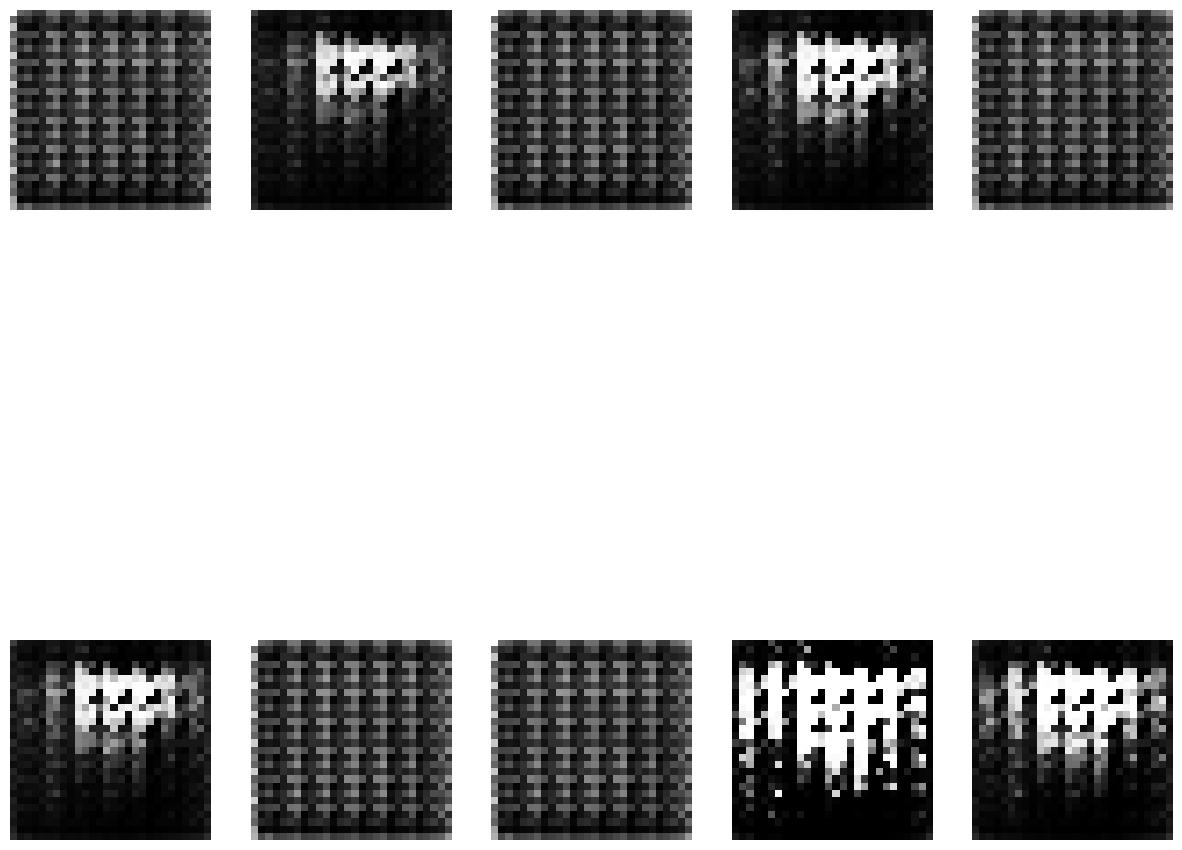

[1/50]	Loss_D: 0.6891	Loss_G: 1.2280	D(x): 0.7435	D(G(z)): 0.2980 / 0.3029
[2/50]	Loss_D: 0.8354	Loss_G: 1.4129	D(x): 0.7681	D(G(z)): 0.3544 / 0.3065
[3/50]	Loss_D: 0.7845	Loss_G: 0.9852	D(x): 0.8976	D(G(z)): 0.4586 / 0.4100
[4/50]	Loss_D: 0.5235	Loss_G: 1.1478	D(x): 0.9521	D(G(z)): 0.3576 / 0.3541
[5/50]	Loss_D: 0.5340	Loss_G: 1.3706	D(x): 0.9208	D(G(z)): 0.3206 / 0.3023
[6/50]	Loss_D: 0.7235	Loss_G: 1.0648	D(x): 0.9266	D(G(z)): 0.4395 / 0.3947
[7/50]	Loss_D: 0.7627	Loss_G: 0.9301	D(x): 0.8795	D(G(z)): 0.4208 / 0.4159
[8/50]	Loss_D: 0.5323	Loss_G: 1.1701	D(x): 0.9694	D(G(z)): 0.3759 / 0.3728
[9/50]	Loss_D: 0.5912	Loss_G: 1.1545	D(x): 0.9497	D(G(z)): 0.3904 / 0.3827
[10/50]	Loss_D: 0.6576	Loss_G: 1.1051	D(x): 0.9674	D(G(z)): 0.4396 / 0.4323


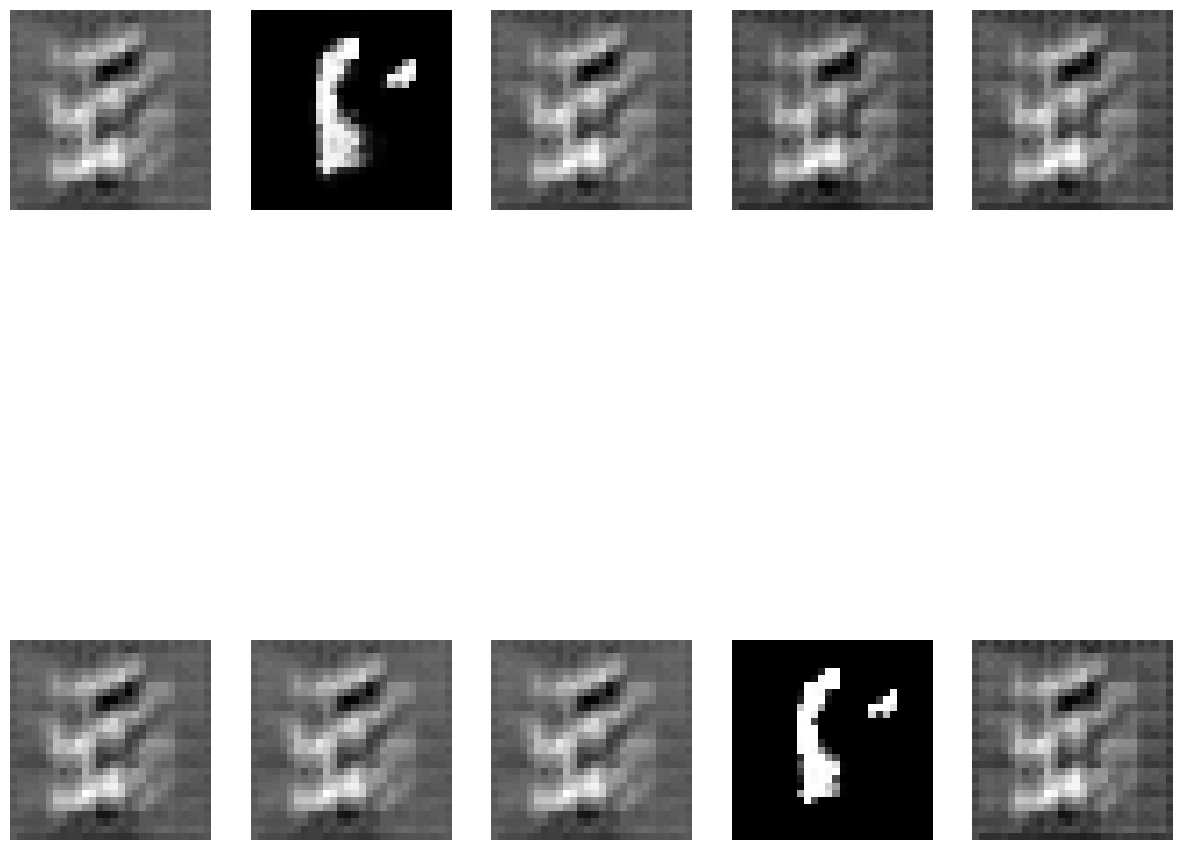

[11/50]	Loss_D: 0.7050	Loss_G: 0.8437	D(x): 0.9512	D(G(z)): 0.4694 / 0.4674
[12/50]	Loss_D: 0.7590	Loss_G: 0.8784	D(x): 0.9627	D(G(z)): 0.4916 / 0.4689
[13/50]	Loss_D: 0.6535	Loss_G: 1.1155	D(x): 0.9519	D(G(z)): 0.4201 / 0.4172
[14/50]	Loss_D: 0.6812	Loss_G: 0.9263	D(x): 0.9846	D(G(z)): 0.4729 / 0.4572
[15/50]	Loss_D: 0.6333	Loss_G: 0.9606	D(x): 0.9842	D(G(z)): 0.4485 / 0.4373
[16/50]	Loss_D: 0.6080	Loss_G: 0.9422	D(x): 0.9775	D(G(z)): 0.4356 / 0.4325
[17/50]	Loss_D: 0.6715	Loss_G: 0.9698	D(x): 0.9750	D(G(z)): 0.4352 / 0.4376
[18/50]	Loss_D: 0.6254	Loss_G: 0.9510	D(x): 0.9594	D(G(z)): 0.4298 / 0.4276
[19/50]	Loss_D: 0.7113	Loss_G: 0.8392	D(x): 0.9528	D(G(z)): 0.4640 / 0.4565
[20/50]	Loss_D: 0.5603	Loss_G: 1.0535	D(x): 0.9955	D(G(z)): 0.4210 / 0.4002


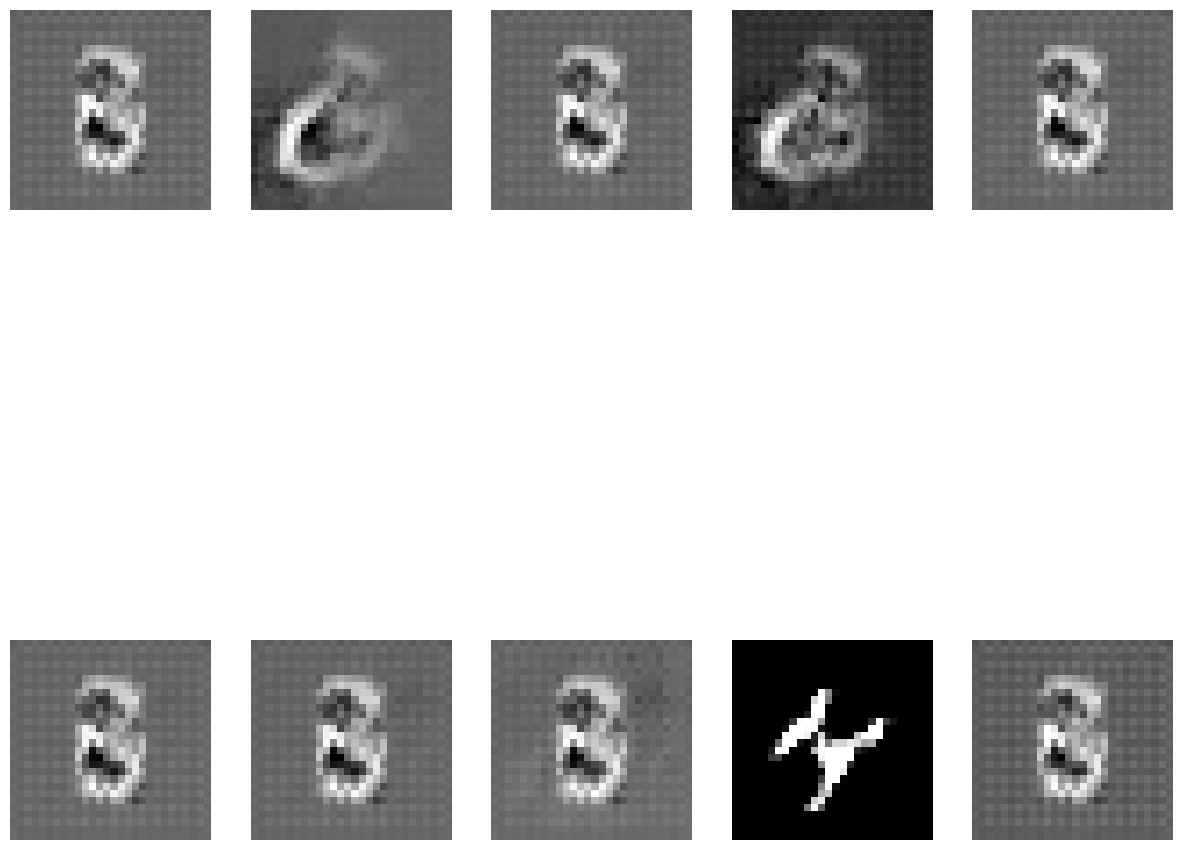

[21/50]	Loss_D: 0.6892	Loss_G: 0.8679	D(x): 0.9628	D(G(z)): 0.4561 / 0.4344
[22/50]	Loss_D: 0.5713	Loss_G: 1.0638	D(x): 0.9879	D(G(z)): 0.3895 / 0.3586
[23/50]	Loss_D: 0.5318	Loss_G: 1.1654	D(x): 0.9781	D(G(z)): 0.3521 / 0.3396
[24/50]	Loss_D: 0.7040	Loss_G: 0.8814	D(x): 0.9706	D(G(z)): 0.4704 / 0.4501
[25/50]	Loss_D: 0.5341	Loss_G: 0.9275	D(x): 0.9978	D(G(z)): 0.4099 / 0.4183
[26/50]	Loss_D: 0.7219	Loss_G: 0.7677	D(x): 0.9904	D(G(z)): 0.4879 / 0.4731
[27/50]	Loss_D: 0.6102	Loss_G: 0.8066	D(x): 0.9989	D(G(z)): 0.4526 / 0.4622
[28/50]	Loss_D: 0.6959	Loss_G: 0.8084	D(x): 0.9989	D(G(z)): 0.4868 / 0.4715
[29/50]	Loss_D: 0.6661	Loss_G: 0.7725	D(x): 0.9715	D(G(z)): 0.4614 / 0.4631
[30/50]	Loss_D: 0.6526	Loss_G: 0.8131	D(x): 0.9880	D(G(z)): 0.4590 / 0.4557


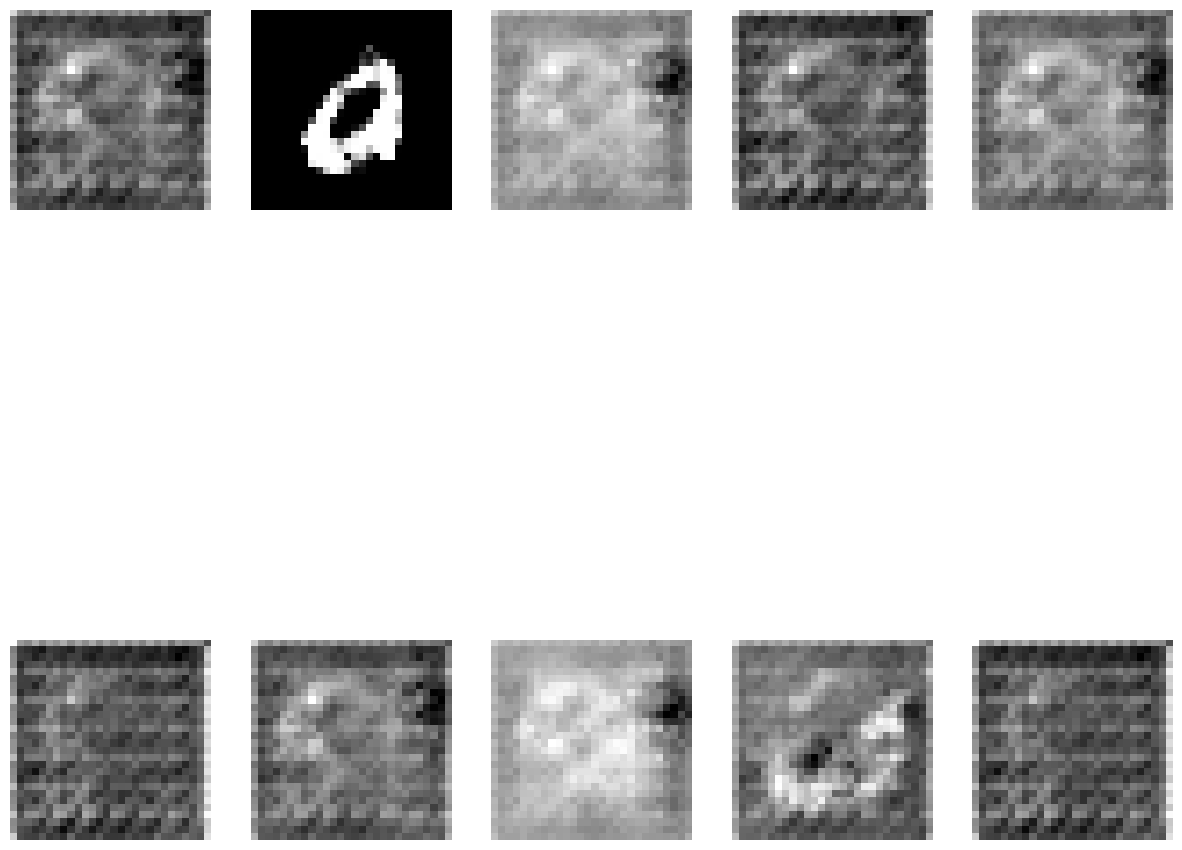

[31/50]	Loss_D: 0.6844	Loss_G: 0.7417	D(x): 0.9856	D(G(z)): 0.4810 / 0.4815
[32/50]	Loss_D: 0.6242	Loss_G: 0.9047	D(x): 0.9792	D(G(z)): 0.4341 / 0.4303
[33/50]	Loss_D: 0.2493	Loss_G: 2.1099	D(x): 0.9885	D(G(z)): 0.1974 / 0.2027
[34/50]	Loss_D: 0.6228	Loss_G: 0.8420	D(x): 0.9970	D(G(z)): 0.4561 / 0.4594
[35/50]	Loss_D: 0.7260	Loss_G: 0.7749	D(x): 0.9768	D(G(z)): 0.4650 / 0.4718
[36/50]	Loss_D: 0.6715	Loss_G: 0.8238	D(x): 0.9993	D(G(z)): 0.4659 / 0.4598
[37/50]	Loss_D: 0.7151	Loss_G: 0.7987	D(x): 0.9827	D(G(z)): 0.4888 / 0.4781
[38/50]	Loss_D: 0.6555	Loss_G: 0.7920	D(x): 0.9922	D(G(z)): 0.4715 / 0.4703
[39/50]	Loss_D: 0.7252	Loss_G: 0.8648	D(x): 0.9820	D(G(z)): 0.4885 / 0.4657
[40/50]	Loss_D: 0.6667	Loss_G: 0.9194	D(x): 0.9989	D(G(z)): 0.4775 / 0.4630


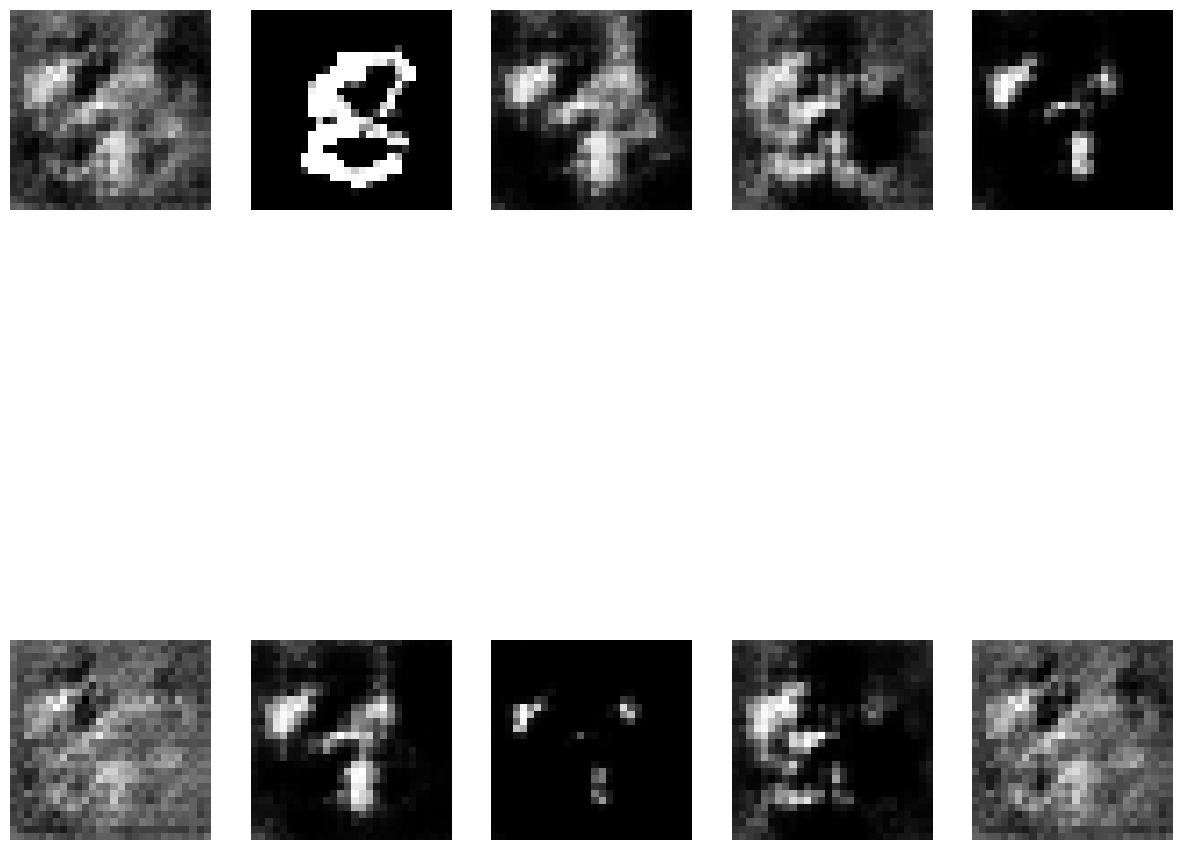

[41/50]	Loss_D: 0.4979	Loss_G: 1.0107	D(x): 0.9998	D(G(z)): 0.3894 / 0.3853
[42/50]	Loss_D: 0.6781	Loss_G: 0.8733	D(x): 0.9725	D(G(z)): 0.4572 / 0.4648
[43/50]	Loss_D: 0.6220	Loss_G: 0.8883	D(x): 0.9991	D(G(z)): 0.4445 / 0.4267
[44/50]	Loss_D: 0.7068	Loss_G: 0.8469	D(x): 0.9997	D(G(z)): 0.4812 / 0.4501
[45/50]	Loss_D: 0.6012	Loss_G: 0.8863	D(x): 0.9956	D(G(z)): 0.4450 / 0.4383
[46/50]	Loss_D: 0.5665	Loss_G: 1.0600	D(x): 0.9991	D(G(z)): 0.4258 / 0.4254
[47/50]	Loss_D: 0.7016	Loss_G: 0.9718	D(x): 0.9816	D(G(z)): 0.4641 / 0.4627
[48/50]	Loss_D: 0.6155	Loss_G: 0.9177	D(x): 0.9993	D(G(z)): 0.4565 / 0.4579
[49/50]	Loss_D: 0.6165	Loss_G: 0.8327	D(x): 0.9961	D(G(z)): 0.4550 / 0.4573
[50/50]	Loss_D: 0.6174	Loss_G: 0.8930	D(x): 0.9993	D(G(z)): 0.4470 / 0.4434
Training Finished!


In [ ]:
G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
  D_losses = []
  G_losses = []

  for i, (images, _) in enumerate(train_loader):
    #############################
    # 1) Update discriminator D #
    #############################
    D.zero_grad()

    images_real = images.to(device)
    y_pred_real = D(images_real).view(-1)    # 진짜 MNIST 데이터를 본 Discriminator의 판별값
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)    # 진짜 MNIST 데이터에 대한 label 값은 1
    
    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    D_real_loss = criterion(y_pred_real, label)
    D_real_loss.backward()

    D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)   # Generator에 입력으로 줄 noise 생성
    images_fake = G(noises)           # Generator는 noise로부터 가짜 데이터를 생성

    y_pred_fake = D(images_fake.detach()).view(-1)      # Generator가 만든 가짜 데이터를 본 Discriminator의 판별값
    label.fill_(0.)        # 가짜 데이터에 대한 label 값은 0

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    D_fake_loss = criterion(y_pred_fake, label)
    D_fake_loss.backward()

    D_G_z1 = y_pred_fake.mean().item()

    D_loss = D_real_loss + D_fake_loss

    # Update D
    D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    G.zero_grad()

    y_pred_fake = D(images_fake).view(-1)
    label.fill_(1.)       # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    G_loss = criterion(y_pred_fake, label)
    G_loss.backward()

    D_G_z2 = y_pred_fake.mean().item()

    # Update G
    G_optimizer.step()

    '''
    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
    '''
    
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())

  if epoch % 10 == 0:
    generated_image = G(noise5).cpu().detach().numpy().squeeze()

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

    for ax in axes.flat:
        ax.axis('off')

    axes[0, 0].imshow(generated_image[0], cmap='gray')
    axes[0, 1].imshow(generated_image[1], cmap='gray')
    axes[0, 2].imshow(generated_image[2], cmap='gray')
    axes[0, 3].imshow(generated_image[3], cmap='gray')
    axes[0, 4].imshow(generated_image[4], cmap='gray')
    axes[1, 0].imshow(generated_image[5], cmap='gray')
    axes[1, 1].imshow(generated_image[6], cmap='gray')
    axes[1, 2].imshow(generated_image[7], cmap='gray')
    axes[1, 3].imshow(generated_image[8], cmap='gray')
    axes[1, 4].imshow(generated_image[9], cmap='gray')

    plt.show()

  print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
         % (epoch+1, EPOCHS,D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
  
  train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
  train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))

print('Training Finished!')

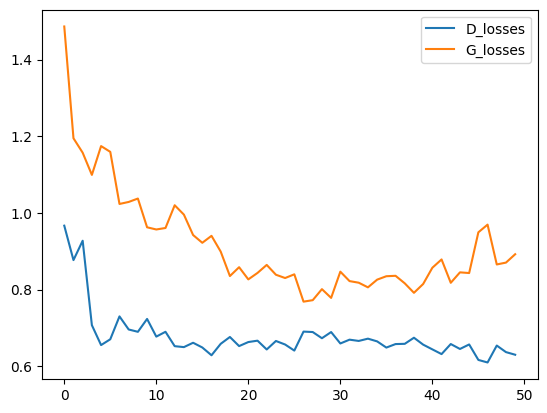

In [ ]:
x = [i for i in range(len(train_hist['D_losses']))]

plt.plot(x, train_hist['D_losses'], label='D_losses')
plt.plot(x, train_hist['G_losses'], label='G_losses')
plt.legend()
plt.show()

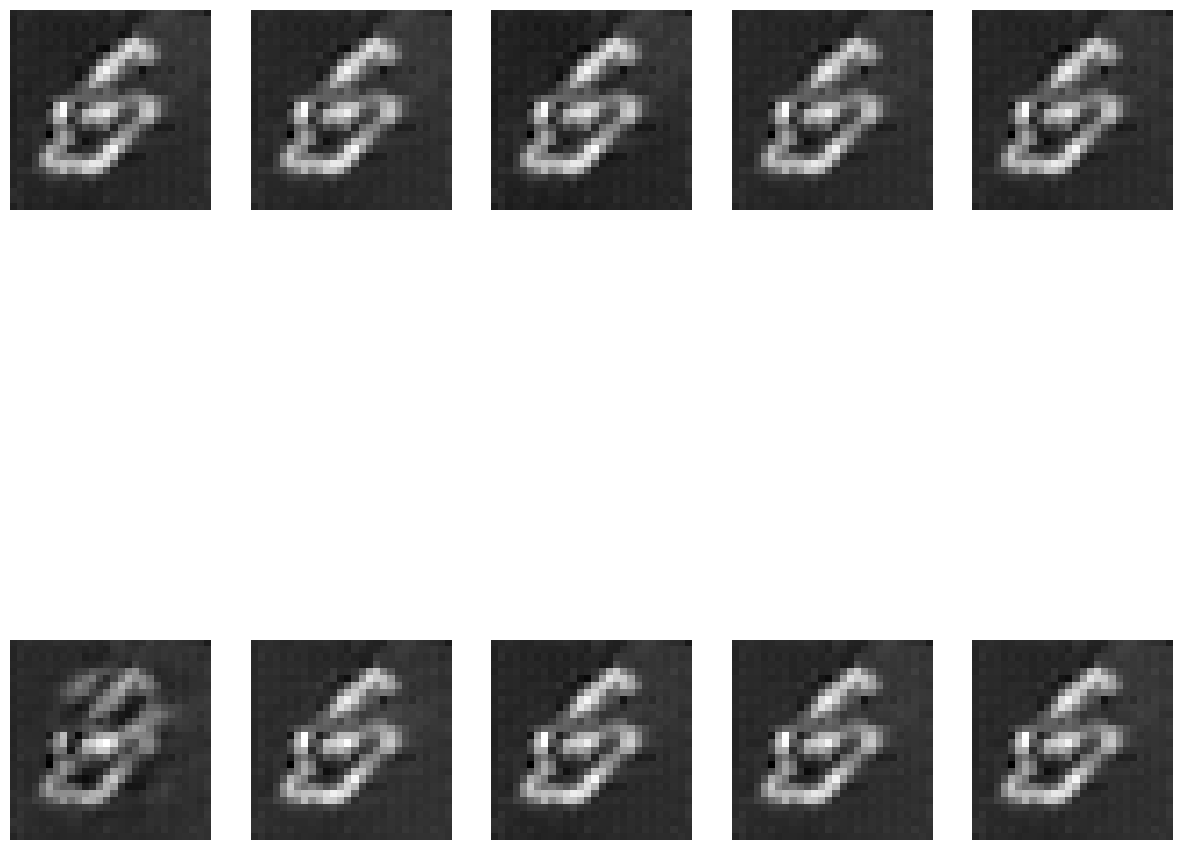

In [ ]:
noise6 = torch.randn(10, 300).to(device)

G.eval()

generated_image = G(noise6).cpu().detach().numpy().squeeze()
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0, 0].imshow(generated_image[0], cmap='gray')
axes[0, 1].imshow(generated_image[1], cmap='gray')
axes[0, 2].imshow(generated_image[2], cmap='gray')
axes[0, 3].imshow(generated_image[3], cmap='gray')
axes[0, 4].imshow(generated_image[4], cmap='gray')
axes[1, 0].imshow(generated_image[5], cmap='gray')
axes[1, 1].imshow(generated_image[6], cmap='gray')
axes[1, 2].imshow(generated_image[7], cmap='gray')
axes[1, 3].imshow(generated_image[8], cmap='gray')
axes[1, 4].imshow(generated_image[9], cmap='gray')

plt.show()

## 최종결과 분석
- 노이즈의 크기를 키웠을때도 역시 좋은 성능을 보이지는 못함
- loss 그래프 역시 불안정함
- 추가적인 fc layer로 인해 성능이 저하된것을 의심해볼만 함
- 무작정 layer를 깊게 쌓는다고 좋은 성능을 보장하지는 않는다는 생각을 함
- 추후에 fc layer의 추가 없이 noise의 크기만 변경해서 실험해보고자 함(GPU 사용량 제한)
